# Flight data classification

- Using the most recent version of the manualy classified events - events classified until **2019/07/28**
- Classified using model 20200415_2_randomforest
- Compared to the events classified until approximatelly 2020/05/01 (20200415_2_randomforest) 
- Considered events in GTU range **ending after GTU 40 and starting not later then GTU 45**

In [1]:
import sys
import os
import subprocess
import re
import numpy as np
import psycopg2 as pg
import pandas as pd
import pandas.io.sql as psql
import getpass
import matplotlib as mpl
import argparse
import glob
import traceback
import hashlib
import math
import collections
import functools

import sklearn.preprocessing
import sklearn.feature_selection
import sklearn.ensemble 
import sklearn.neural_network
import sklearn.model_selection
import sklearn.metrics
import sklearn.pipeline
from sklearn.externals import joblib

# mpl.use('Agg')
mpl.rcParams['figure.dpi'] = 80

import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.stats.proportion as sm_stats_proportion

/home/vrabel/EUSO-Balloon/vrabel/venv/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
app_base_dir = '/home/spbproc/euso-spb-patt-reco-v1'
if app_base_dir not in sys.path:
    sys.path.append(app_base_dir)

import event_processing_v3
import event_processing_v4
import postgresql_v3_event_storage
import dataset_query_functions_v3

import tool.acqconv
from data_analysis_utils import *
from data_analysis_utils_dataframes import *
from data_analysis_utils_trigger_rate import *
# import supervised_classification as supc    

Welcome to JupyROOT 6.13/02


In [3]:
inverse_means_map = np.load('/home/spbproc/euso-spb-patt-reco-v1/resources/inverse_flat_average_directions_4m_flipud.npy')

In [4]:
classification_id = '20200415_2_randomforest'
model_data_snippets_dir = 'ver4_machine_learning_w_labeled_flight_' + classification_id
data_snippets_dir = 'ver4_machine_learning_flight_classification_tsne_cfg3_' + classification_id  + '_gtu_40_overlap_cls20200501'
model_evaluation_data_snippets_dir = model_data_snippets_dir + '_evaluation'

subset_classification_slug = 'ver4_ml_tsne_cfg3_' + classification_id + '_gtu_40_overlap_cls20200501'

os.makedirs(data_snippets_dir, exist_ok=True)

In [5]:
data_snippets_dir_data = os.path.join(data_snippets_dir, 'data')

# Selecting the flight data

In [6]:
event_processing_cls = event_processing_v4.EventProcessingV4
event_v3_storage_provider_flight = dataset_query_functions_v3.build_event_v3_storage_provider(
    event_storage_provider_config_file=os.path.join(app_base_dir,'config_w_flatmap.ini'), 
    table_names_version='ver4',
    event_storage_class=postgresql_v3_event_storage.PostgreSqlEventV3StorageProvider,
    event_processing_class=event_processing_cls,
    readonly=False
)

query_functions_flight = dataset_query_functions_v3.Ver3DatasetQueryFunctions(event_v3_storage_provider_flight)

## Columns

In [7]:
rfecv_selector_on_randomforest__column_names = []

columns_list_file_pathname = os.path.join(model_data_snippets_dir, 'rfecv_selector_on_randomforest__column_names.txt')
print(columns_list_file_pathname)
with open(columns_list_file_pathname, 'r') as columns_list_file:
    rfecv_selector_on_randomforest__column_names = columns_list_file.read().splitlines()

ver4_machine_learning_w_labeled_flight_20200415_2_randomforest/rfecv_selector_on_randomforest__column_names.txt


In [8]:
rfecv_selector_on_randomforest__column_names__special = []

special_columns_list_file_pathname = os.path.join(model_data_snippets_dir, 'rfecv_selector_on_randomforest__column_names__special.txt')
print(special_columns_list_file_pathname)
with open(special_columns_list_file_pathname, 'r') as special_columns_list_file:
    rfecv_selector_on_randomforest__column_names__special = special_columns_list_file.read().splitlines()

ver4_machine_learning_w_labeled_flight_20200415_2_randomforest/rfecv_selector_on_randomforest__column_names__special.txt


In [9]:
# This should be empty for now
rfecv_selector_on_randomforest__column_names__special

[]

In [10]:
rfecv_selector_on_randomforest__column_names

['trg_box_per_gtu_max',
 'trg_box_per_gtu_sum',
 'trg_box_per_gtu_mean',
 'trg_x_y_clusters_sizes_max',
 'trg_x_y_clusters_clu_areas_max',
 'trg_x_y_clusters_max_size_clu_height',
 'trg_gtu_y_clusters_max_size_clu_height',
 'orig_x_y_sum',
 'orig_x_y_max',
 'orig_x_y_mean',
 'orig_x_y_mean_gz',
 'proc1_x_y_clusters_sizes_min',
 'proc1_x_y_clusters_sizes_max',
 'proc1_x_y_clusters_max_peak_clu_size',
 'proc2_x_y_clusters_sizes_max',
 'proc2_x_y_clusters_max_peak_clu_size',
 'proc3_x_y_clusters_sizes_max',
 'proc3_x_y_clusters_max_peak_clu_size',
 'proc2_gtu_x_clusters_sizes_max',
 'proc3_gtu_x_clusters_max_peak_clu_size',
 'proc1_gtu_y_clusters_sizes_min',
 'proc1_gtu_y_clusters_sizes_max',
 'proc1_gtu_y_clusters_clu_areas_max',
 'proc1_gtu_y_clusters_max_peak_clu_width',
 'proc1_gtu_y_clusters_max_peak_clu_size',
 'proc3_gtu_y_clusters_sizes_max',
 'proc3_gtu_y_clusters_max_peak_clu_size',
 'alt1_gtu_x_clusters_max_size_clu_width',
 'alt1_gtu_x_clusters_max_peak_clu_width',
 'trg_count

In [11]:
trg_phi_col = 'trg_x_y_hough_peak_thr2_max_peak_clu_major_line_phi'

additional_column_names = [
    trg_phi_col,
    'proc2_x_y_hough_peak_thr2_max_peak_clu_major_line_phi',
    'proc2_x_y_hough_peak_thr2_max_peak_clu_major_line_rho',
    'proc2_gtu_x_hough_peak_thr2_major_line_phi',
    'proc2_gtu_x_hough_peak_thr2_major_line_rho',
    'proc2_gtu_y_hough_peak_thr2_major_line_phi',
    'proc2_gtu_y_hough_peak_thr2_major_line_rho',
]
for a in rfecv_selector_on_randomforest__column_names:
    if a in additional_column_names:
        additional_column_names.remove(a)

In [12]:
flight_columns_for_analysis_dict = query_functions_flight.get_columns_for_classification_dict__by_excluding(
    excluded_columns_re_list=('^.+$',),
    default_excluded_columns_re_list=[],
    included_columns_re_list=[
        ('^$','source_file_(acquisition|trigger)(_full)?|global_gtu|packet_id|gtu_in_packet|event_id|num_gtu|timestamp'),
        ('gps_datetime_min')
    ] + rfecv_selector_on_randomforest__column_names + additional_column_names
)

classification_flight_columns_for_analysis_dict = query_functions_flight.get_columns_for_classification_dict__by_excluding(
    excluded_columns_re_list=('^.+$',),
    default_excluded_columns_re_list=[],
    included_columns_re_list=rfecv_selector_on_randomforest__column_names
)

print_columns_dict(flight_columns_for_analysis_dict)

spb_processing_v4_flatmap.event
	- event_id
	- timestamp
	- source_file_acquisition_full
	- source_file_trigger_full
	- source_file_acquisition
	- source_file_trigger
	- global_gtu
	- packet_id
	- gtu_in_packet
	- num_gtu

spb_processing_v4_flatmap.event_trg_box_per_gtu
	- max
	- sum
	- mean
	- mean_gz

spb_processing_v4_flatmap.event_gps_datetime
	- min

spb_processing_v4_flatmap.event_trg_x_y_clusters
	- sizes_max
	- clu_areas_max
	- max_size_clu_height

spb_processing_v4_flatmap.event_trg_gtu_y_clusters
	- max_size_clu_height

spb_processing_v4_flatmap.event_orig_x_y
	- sum
	- max
	- mean
	- mean_gz

spb_processing_v4_flatmap.event_proc1_x_y_clusters
	- sizes_min
	- sizes_max
	- max_peak_clu_size

spb_processing_v4_flatmap.event_proc2_x_y_clusters
	- sizes_max
	- max_peak_clu_size

spb_processing_v4_flatmap.event_proc3_x_y_clusters
	- sizes_max
	- max_peak_clu_size

spb_processing_v4_flatmap.event_proc2_gtu_x_clusters
	- sizes_max

spb_processing_v4_flatmap.event_proc3_gtu_x_cluster

WARNING: not selecting NULL trg lines

## Event classes

In [13]:
EVENT_CLASSES = {
    'pixel': 2,
    'top_left_ec': 5,
    'blob': 12,
    'large_blob': 11,
    'short_single_gtu_track': 7,
    'single_gtu_track': 3,
    'noise': 1,
    'cartesian_line': 4,
    'strong_pmt_edge': 9,
    'few_pixels': 6,
    'bg_increased_suddenly': 10,
    'persistent_pixel': 14,
    'noise_unspecified': 0,
    'unspecified': 8,
    'shower': 13,
    '2pix_line': 15,
    'bright_blob': 16,
    'blob_and_pixels': 17,
    'pixel_w_blob_behind': 18,
    'storng_light': 19,
    'sparse_blobs': 20,
    'noise_with_weak_pixel': 21,
    #
    'unclassified': -1
}

In [14]:
EVENT_CLASSES_LABELS = {
    'Pixel': 2,
    'Top-left EC': 5,
    'Blob': 12,
    'Large blob': 11,
    'Short single GTU track': 7,
    'Single GTU track': 3,
    'Noise': 1,
    'Cartesian line': 4,
    'Strong MA-PMT edge': 9,
    'Few pixels': 6,
    'Sudden bg. increase': 10,
    'Persistent pixel': 14,
    'Unspecified noise': 0,
    'Unspecified': 8,
    'Air shower': 13,
    '2 pix line': 15,
    'Bright blob': 16,
    'Blob and pixels': 17,
    'Pixel with a blob behind': 18,
    'Storng light': 19,
    'Sparse blobs': 20,
    'Noise with a weak pixel': 21,
    #
    'Unclassified': -1
}

In [15]:
len(EVENT_CLASSES)

23

In [16]:
INVERSE_EVENT_CLASSES = {v: k for k, v in EVENT_CLASSES.items()}

In [17]:
INVERSE_EVENT_CLASSES_LABELS = {v: k for k, v in EVENT_CLASSES_LABELS.items()}

## Constructing the query

In [18]:
manual_classification_table_name_w_schema = event_v3_storage_provider_flight.database_schema_name + '.event_manual_classification'
manual_classification_attr_prefix = event_v3_storage_provider_flight.get_group_from_table_name(manual_classification_table_name_w_schema)

manual_classification_class_number_column_base = 'class_number'
manual_classification_last_mod_column_base = 'last_modification'

manual_classification_class_number_column = manual_classification_attr_prefix + '_' + manual_classification_class_number_column_base
manual_classification_last_mod_column = manual_classification_attr_prefix + '_' + manual_classification_last_mod_column_base

In [19]:
classification_table_name = event_v3_storage_provider_flight.database_schema_name + '.event_manual_classification'

current_columns_for_analysis_dict = flight_columns_for_analysis_dict

flight_select_clause_str, flight_tables_list = \
    query_functions_flight.get_query_clauses__select({
    **current_columns_for_analysis_dict,
    classification_table_name: ['class_number']
})

flight_clauses_str = \
    query_functions_flight.get_query_clauses__join(flight_tables_list)

flight_source_data_type_num = 1

# AND abs(gtu_in_packet-42) < 20
flight_where_clauses_str = ''' 
    AND {database_schema_name}.event_orig_x_y.count_nonzero > 256*6
'''

for table, cols_list in classification_flight_columns_for_analysis_dict.items():
    for col in cols_list:
        flight_where_clauses_str += ' AND {}.{} IS NOT NULL\n'.format(table, col)

flight_events_selection_query = query_functions_flight.get_events_selection_query_plain(
    source_data_type_num=flight_source_data_type_num,
    select_additional=flight_select_clause_str, 
    join_additional=flight_clauses_str,
    where_additional=flight_where_clauses_str,
    order_by='{data_table_name}.event_id', 
    offset=0, limit=350000,
    base_select='')

In [20]:
print(flight_events_selection_query)


    SELECT 
        
        spb_processing_v4_flatmap.event.event_id, spb_processing_v4_flatmap.event.timestamp, spb_processing_v4_flatmap.event.source_file_acquisition_full, spb_processing_v4_flatmap.event.source_file_trigger_full, spb_processing_v4_flatmap.event.source_file_acquisition, spb_processing_v4_flatmap.event.source_file_trigger, spb_processing_v4_flatmap.event.global_gtu, spb_processing_v4_flatmap.event.packet_id, spb_processing_v4_flatmap.event.gtu_in_packet, spb_processing_v4_flatmap.event.num_gtu, spb_processing_v4_flatmap.event_trg_box_per_gtu.max AS trg_box_per_gtu_max, spb_processing_v4_flatmap.event_trg_box_per_gtu.sum AS trg_box_per_gtu_sum, spb_processing_v4_flatmap.event_trg_box_per_gtu.mean AS trg_box_per_gtu_mean, spb_processing_v4_flatmap.event_trg_box_per_gtu.mean_gz AS trg_box_per_gtu_mean_gz, spb_processing_v4_flatmap.event_gps_datetime.min AS gps_datetime_min, spb_processing_v4_flatmap.event_trg_x_y_clusters.sizes_max AS trg_x_y_clusters_sizes_max, spb_pr

## Data selection

In [21]:
flight_df = psql.read_sql(flight_events_selection_query, event_v3_storage_provider_flight.connection)

In [22]:
len(flight_df)

206428

In [23]:
flight_df.query('event_id > 146116')

,event_id,timestamp,source_file_acquisition_full,source_file_trigger_full,source_file_acquisition,source_file_trigger,global_gtu,packet_id,gtu_in_packet,num_gtu,...,proc3_gtu_y_hough_peak_thr1_line_clusters_sizes_max,proc3_gtu_y_hough_peak_thr1_line_clusters_max_area_clu_size,proc3_gtu_y_hough_peak_thr1_line_clusters_max_sum_clu_size,proc3_gtu_y_hough_peak_thr2_major_line_phi,alt1_x_y_hough_peak_thr1_line_clusters_count,alt1_x_y_hough_peak_thr1_line_clusters_sizes_max,alt1_x_y_hough_peak_thr1_line_clusters_clu_widths_max,alt1_x_y_hough_peak_thr1_line_clusters_max_area_clu_size,alt1_x_y_hough_peak_thr1_line_clusters_max_sum_clu_size,manual_classification_class_number
128154,146117,1537156389,/home/spbproc/SPBDATA_flight/allpackets-SPBEUS...,/home/spbproc/SPBDATA_processed/allpackets-SPB...,allpackets-SPBEUSO-ACQUISITION-20170429-080135...,trn_20170429-080135-025.001_C_inverse_flat_ave...,5625,43,121,9,...,204,204,204,2.121490,4,66,36,66,66,NaN
128155,146118,1537156388,/home/spbproc/SPBDATA_flight/allpackets-SPBEUS...,/home/spbproc/SPBDATA_processed/allpackets-SPB...,allpackets-SPBEUSO-ACQUISITION-20170428-151019...,trn_20170428-151019-022.001_C_inverse_flat_ave...,19345,151,17,10,...,16,16,16,0.666930,3,23,28,23,23,NaN
128156,146119,1537156389,/home/spbproc/SPBDATA_flight/allpackets-SPBEUS...,/home/spbproc/SPBDATA_processed/allpackets-SPB...,allpackets-SPBEUSO-ACQUISITION-20170427-125407...,trn_20170427-125407-026.001_C_inverse_flat_ave...,6312,49,40,13,...,43,43,43,0.011075,3,82,64,82,82,NaN
128157,146120,1537156390,/home/spbproc/SPBDATA_flight/allpackets-SPBEUS...,/home/spbproc/SPBDATA_processed/allpackets-SPB...,allpackets-SPBEUSO-ACQUISITION-20170428-081726...,trn_20170428-081726-012.001_C_inverse_flat_ave...,5927,46,39,11,...,45,45,45,2.712730,3,9,15,9,9,NaN
128158,146121,1537156390,/home/spbproc/SPBDATA_flight/allpackets-SPBEUS...,/home/spbproc/SPBDATA_processed/allpackets-SPB...,allpackets-SPBEUSO-ACQUISITION-20170426-125930...,trn_20170426-125930-029.001_C_inverse_flat_ave...,26914,210,34,9,...,89,89,89,2.431410,3,138,40,138,138,NaN
128159,146122,1537156390,/home/spbproc/SPBDATA_flight/allpackets-SPBEUS...,/home/spbproc/SPBDATA_processed/allpackets-SPB...,allpackets-SPBEUSO-ACQUISITION-20170428-092901...,trn_20170428-092901-001.001_C_inverse_flat_ave...,21642,169,10,9,...,35,26,35,6.277830,4,33,25,33,33,NaN
128160,146123,1537156389,/home/spbproc/SPBDATA_flight/allpackets-SPBEUS...,/home/spbproc/SPBDATA_processed/allpackets-SPB...,allpackets-SPBEUSO-ACQUISITION-20170427-105159...,trn_20170427-105159-003.001_C_inverse_flat_ave...,86953,679,41,9,...,25,25,25,3.040070,9,58,51,58,58,NaN
128161,146124,1537156391,/home/spbproc/SPBDATA_flight/allpackets-SPBEUS...,/home/spbproc/SPBDATA_processed/allpackets-SPB...,allpackets-SPBEUSO-ACQUISITION-20170428-151019...,trn_20170428-151019-022.001_C_inverse_flat_ave...,19477,152,21,9,...,25,25,25,3.036760,4,198,101,198,198,NaN
128162,146125,1537156391,/home/spbproc/SPBDATA_flight/allpackets-SPBEUS...,/home/spbproc/SPBDATA_processed/allpackets-SPB...,allpackets-SPBEUSO-ACQUISITION-20170429-080135...,trn_20170429-080135-025.001_C_inverse_flat_ave...,5688,44,56,9,...,40,40,40,0.135835,9,77,38,77,77,NaN
128163,146126,1537156392,/home/spbproc/SPBDATA_flight/allpackets-SPBEUS...,/home/spbproc/SPBDATA_processed/allpackets-SPB...,allpackets-SPBEUSO-ACQUISITION-20170428-092901...,trn_20170428-092901-001.001_C_inverse_flat_ave...,21648,169,16,9,...,75,75,75,5.987340,7,98,43,98,98,NaN


### Distance from GTU 40

In [24]:
flight_df['dist_gtu_40'] = np.abs(flight_df['gtu_in_packet'] - 40)

### Event manual classification

In [25]:
np.count_nonzero(~flight_df[manual_classification_class_number_column].isnull())

4833

In [26]:
flight_df.loc[flight_df[manual_classification_class_number_column].isnull(), 
              manual_classification_class_number_column] = EVENT_CLASSES['unclassified']

In [27]:
manual_classification_class_name_column = 'manual_classification_class_name'
manual_classification_class_label_column = 'manual_classification_class_label'

In [28]:
flight_df[manual_classification_class_name_column] = INVERSE_EVENT_CLASSES[-1]
flight_df[manual_classification_class_label_column] = INVERSE_EVENT_CLASSES_LABELS[-1]
for class_name, class_number in EVENT_CLASSES.items():
    flight_df.loc[flight_df[manual_classification_class_number_column]==class_number, 
                  manual_classification_class_name_column] = class_name
for class_label, class_number in EVENT_CLASSES_LABELS.items():
    flight_df.loc[flight_df[manual_classification_class_number_column]==class_number, 
                  manual_classification_class_label_column] = class_label

### Event manual classification (model training/testing version)

skipped for now needs to be solved

In [29]:
# flight_data_csv_20200415_2_randomforest_df = pd.read_csv(
#     'ver4_machine_learning_flight_classification_tsne_cfg3_20200415_2_randomforest/flight_data.tsv.gz', 
#     usecols=['event_id', manual_classification_class_number_column], sep='\t')

In [30]:
manual_classification_class_number_column_from_csv = manual_classification_class_number_column + '_from_csv'
flight_df[manual_classification_class_number_column_from_csv] = \
    flight_data_csv_20200415_2_randomforest_df.set_index('event_id').loc[flight_df['event_id'].values] \
        .fillna(EVENT_CLASSES['unclassified'])[manual_classification_class_number_column].values

NameError: name 'flight_data_csv_20200415_2_randomforest_df' is not defined

In [ ]:
np.count_nonzero(flight_data_csv_20200415_2_randomforest_df[manual_classification_class_number_column] != EVENT_CLASSES['unclassified'])

In [ ]:
np.count_nonzero(flight_df[manual_classification_class_number_column_from_csv] != EVENT_CLASSES['unclassified'])

In [ ]:
np.count_nonzero(
    (flight_df[manual_classification_class_number_column_from_csv] == flight_df[manual_classification_class_number_column]) \
    & (flight_df[manual_classification_class_number_column_from_csv] != EVENT_CLASSES['unclassified'])
)

### NaN fields

In [31]:
np.count_nonzero(flight_df['event_id'].isnull())

0

In [32]:
flight_df['had_nan_fields'] = flight_df[rfecv_selector_on_randomforest__column_names].isnull().any(axis=1)

In [33]:
np.count_nonzero(flight_df['had_nan_fields'])

0

In [34]:
flight_df_nonan = flight_df[~flight_df['had_nan_fields']]

In [35]:
len(flight_df_nonan)

206428

## Additional counts for comparson

In [36]:
cur = event_v3_storage_provider_flight.connection.cursor()

In [37]:
cur.execute('''
    SELECT COUNT(*) FROM (
        SELECT DISTINCT source_file_acquisition, packet_id 
        FROM spb_processing_v4_flatmap.event WHERE source_data_type_num={source_data_type_num}
    ) AS s
'''.format(source_data_type_num=flight_source_data_type_num))
num_all_packets = cur.fetchone()[0]

cur.execute('''
    SELECT COUNT(*) FROM (
        SELECT DISTINCT source_file_acquisition, packet_id 
        FROM spb_processing_v4_flatmap.event WHERE source_data_type_num={source_data_type_num}
        AND 36 <= gtu_in_packet AND gtu_in_packet <= 60
    ) AS s
'''.format(source_data_type_num=flight_source_data_type_num))
num_gtu_36_60_packets = cur.fetchone()[0]

cur.execute('''
    SELECT COUNT(*) FROM (
        SELECT DISTINCT source_file_acquisition, packet_id 
        FROM spb_processing_v4_flatmap.event WHERE source_data_type_num={source_data_type_num}
        AND 31 <= gtu_in_packet AND gtu_in_packet <= 67
    ) AS s
'''.format(source_data_type_num=flight_source_data_type_num))
num_gtu_31_67_packets = cur.fetchone()[0]

cur.execute('''
    SELECT COUNT(*) FROM (
        SELECT DISTINCT source_file_acquisition, packet_id 
        FROM spb_processing_v4_flatmap.event WHERE source_data_type_num={source_data_type_num}
        AND 36 <= gtu_in_packet AND gtu_in_packet <= 45
    ) AS s
'''.format(source_data_type_num=flight_source_data_type_num))
num_gtu_36_45_packets = cur.fetchone()[0]

cur.execute('''
    SELECT COUNT(*) FROM (
        SELECT DISTINCT source_file_acquisition, packet_id 
        FROM spb_processing_v4_flatmap.event
        JOIN spb_processing_v4_flatmap.event_orig_x_y USING (event_id) 
        WHERE source_data_type_num={source_data_type_num}
        AND 36 <= gtu_in_packet AND gtu_in_packet <= 45
        AND spb_processing_v4_flatmap.event_orig_x_y.count_nonzero > 256*6
    ) AS s
'''.format(source_data_type_num=flight_source_data_type_num))
num_gtu_36_45_cnz6ec_packets = cur.fetchone()[0]


cur.execute('''
    SELECT COUNT(event_id) FROM spb_processing_v4_flatmap.event 
    WHERE source_data_type_num={source_data_type_num}
'''.format(source_data_type_num=flight_source_data_type_num))
num_all_events = cur.fetchone()[0]

cur.execute('''
    SELECT COUNT(event_id) FROM spb_processing_v4_flatmap.event 
    WHERE source_data_type_num={source_data_type_num} 
    AND gtu_in_packet BETWEEN 36 AND 60
'''.format(source_data_type_num=flight_source_data_type_num))
num_gtu_36_60_events = cur.fetchone()[0]

cur.execute('''
    SELECT COUNT(event_id) FROM spb_processing_v4_flatmap.event 
    WHERE source_data_type_num={source_data_type_num} 
    AND gtu_in_packet BETWEEN 31 AND 67
'''.format(source_data_type_num=flight_source_data_type_num))
num_gtu_31_67_events = cur.fetchone()[0]

cur.execute('''
    SELECT COUNT(event_id) FROM spb_processing_v4_flatmap.event 
    WHERE source_data_type_num={source_data_type_num} 
    AND gtu_in_packet BETWEEN 36 AND 45
'''.format(source_data_type_num=flight_source_data_type_num))
num_gtu_36_45_events = cur.fetchone()[0]


cur.execute('''
    SELECT COUNT(event_id) 
    FROM spb_processing_v4_flatmap.event 
    JOIN spb_processing_v4_flatmap.event_orig_x_y USING (event_id)
    WHERE source_data_type_num={source_data_type_num} 
    AND gtu_in_packet BETWEEN 36 AND 45
    AND spb_processing_v4_flatmap.event_orig_x_y.count_nonzero > 256*6
'''.format(source_data_type_num=flight_source_data_type_num))
num_gtu_36_45_cnz6ec_events = cur.fetchone()[0]

In [38]:
print('number of all         packets', num_all_packets)
print('number of gtu [36,60] packets', num_gtu_36_60_packets)
print('number of gtu [31,67] packets', num_gtu_31_67_packets)
print('number of gtu [36,45] packets', num_gtu_36_45_packets)
print('number of gtu [36,45] packets (6EC+)', num_gtu_36_45_cnz6ec_packets)
print('-'*50)
print('number of all         events ', num_all_events)
print('number of gtu [36,60] events ', num_gtu_36_60_events)
print('number of gtu [31,67] events ', num_gtu_31_67_events)
print('number of gtu [36,45] events ', num_gtu_36_45_events)
print('number of gtu [36,45] events (6EC6)', num_gtu_36_45_cnz6ec_events)
print('-'*50)
print('sel. fraction of all         events {:.3f}'.format(len(flight_df_nonan) / num_all_events))
print('sel. fraction of gtu [36,60] events {:.3f}'.format(len(flight_df_nonan) / num_gtu_36_60_events))
print('sel. fraction of gtu [31,67] events {:.3f}'.format(len(flight_df_nonan) / num_gtu_31_67_events))
print('sel. fraction of gtu [36,45] events {:.3f}, inv: {:.3f} (not exact)'.format(len(flight_df_nonan) / num_gtu_36_45_events, num_gtu_36_45_events / len(flight_df_nonan))) 
print('sel. fraction of gtu [36,45] events {:.3f}, inv: {:.3f} (6EC+)'.format(len(flight_df_nonan) / num_gtu_36_45_cnz6ec_events, num_gtu_36_45_cnz6ec_events / len(flight_df_nonan))) 

number of all         packets 148327
number of gtu [36,60] packets 139865
number of gtu [31,67] packets 142478
number of gtu [36,45] packets 135021
number of gtu [36,45] packets (6EC+) 118141
--------------------------------------------------
number of all         events  247316
number of gtu [36,60] events  159080
number of gtu [31,67] events  170427
number of gtu [36,45] events  135799
number of gtu [36,45] events (6EC6) 118820
--------------------------------------------------
sel. fraction of all         events 0.835
sel. fraction of gtu [36,60] events 1.298
sel. fraction of gtu [31,67] events 1.211
sel. fraction of gtu [36,45] events 1.520, inv: 0.658 (not exact)
sel. fraction of gtu [36,45] events 1.737, inv: 0.576 (6EC+)


Note: Fractions should be recalculated after refining the selection of events

In [39]:
# TODO
# SELECT COUNT(*) FROM spb_processing_v4_flatmap.event JOIN spb_processing_v4_flatmap.event_orig_x_y USING(event_id) WHERE source_data_type_num = 1 AND abs(gtu_in_packet-42) < 20 AND spb_processing_v4_flatmap.event_orig_x_y.count_nonzero > 256*6 LIMIT 5;
# SELECT COUNT( DISTINCT (source_file_acquisition, packet_id)) FROM spb_processing_v4_flatmap.event JOIN spb_processing_v4_flatmap.event_orig_x_y USING(event_id) WHERE source_data_type_num = 1 AND abs(gtu_in_packet-42) < 20 AND spb_processing_v4_flatmap.event_orig_x_y.count_nonzero > 256*6 LIMIT 5;
# SELECT COUNT(*) FROM (SELECT DISTINCT source_file_acquisition, packet_id  FROM spb_processing_v4_flatmap.event WHERE source_data_type_num=1) AS s;

# Applying models

This model does not use scaled data

In [40]:
# standard_scaler_on_train_rfecv_columns_pathname = \
#      os.path.join(model_data_snippets_dir, 'standard_scaler_on_train_rfecv_columns.pkl')
# standard_scaler_on_train_rfecv_columns = joblib.load(standard_scaler_on_train_rfecv_columns_pathname)

In [41]:
# flight__rfecv_columns_scaled_X = \
#     standard_scaler_on_train_rfecv_columns.transform(
#         flight_df[rfecv_selector_on_randomforest__column_names].values)
# if np.count_nonzero(flight_df['had_nan_fields']) > 0:
#     flight_nonan__rfecv_columns_scaled_X = \
#         standard_scaler_on_train_rfecv_columns.transform(
#             flight_df_nonan[rfecv_selector_on_randomforest__column_names].values)
# else:
#     flight_nonan__rfecv_columns_scaled_X = flight__rfecv_columns_scaled_X

## Random Forest classifier

In [42]:
flight_rfecv_columns__X  = flight_df_nonan[rfecv_selector_on_randomforest__column_names].values

In [44]:
randomforest_cls_on_train_rfecv__model_plk_pathname = \
    os.path.join(model_data_snippets_dir, 'randomforest_cls_on_train_rfecv_s_1.pkl')
randomforest_cls_on_train_rfecv_est = joblib.load(randomforest_cls_on_train_rfecv__model_plk_pathname)

In [45]:
cls_column_base = 'randomforest_cls_on_train_rfecv_est'
cls_column = cls_column_base + '_dropna'
cls_proba_column = 'randomforest_cls_on_train_rfecv_est_dropna_proba'

In [46]:
# this might not be correct (but for this particular selection it should be fine becaus flight_df_nonan == flight_df )
flight_df[cls_column_base] = \
    randomforest_cls_on_train_rfecv_est.predict(flight_rfecv_columns__X)

flight_df[cls_column] = \
    ((flight_df[cls_column_base]==1) & ~flight_df['had_nan_fields']).astype('int8')

In [47]:
flight_df[cls_proba_column] = np.nan
flight_df.loc[flight_df['event_id'].isin(flight_df_nonan['event_id']), cls_proba_column] = \
    randomforest_cls_on_train_rfecv_est.predict_proba(flight_rfecv_columns__X)[:,1]

# Full data dump

In [48]:
out_pathname = os.path.join(data_snippets_dir, 'flight_df.tsv.gz')
if not os.path.exists(out_pathname):
    print('SAVING', out_pathname)
    flight_df.to_csv(out_pathname, sep='\t', compression='gzip')
else:
    print('ALREADY EXISTS', out_pathname)

SAVING ver4_machine_learning_flight_classification_tsne_cfg3_20200415_2_randomforest_gtu_40_overlap_cls20200501/flight_df.tsv.gz


# Refining the selection

In [49]:
def dump_entries_list_df(
        df, name, data_snippets_dir_data=data_snippets_dir_data, 
        dump_columns=('event_id', 'packet_id', 'gtu_in_packet', cls_proba_column, cls_column), 
        sep='\t', overwrite=False):
    if os.path.splitext(name)[1] == '':
        name = name + '.tsv.gz'
    out_pathname = os.path.join(data_snippets_dir_data, name)
    if not overwrite and os.path.exists(out_pathname):
        print('ALREADY EXISTS:', out_pathname)
    else:
        os.makedirs(os.path.dirname(out_pathname), exist_ok=True)
        print('SAVING:', out_pathname)
        df.to_csv(out_pathname, sep=sep, columns=dump_columns, compression='gzip')

In [50]:
flight_df_pack = flight_df \
    .reset_index() \
    .sort_values(['source_file_acquisition', 'packet_id', 'dist_gtu_40', 'gtu_in_packet'], ascending=True) \
    .groupby(['source_file_acquisition', 'packet_id'], as_index=False).first() \
    .set_index('index')

In [51]:
len(flight_df_pack)

129174

In [52]:
dump_entries_list_df(flight_df, 'flight_df')
dump_entries_list_df(flight_df_pack, 'flight_df_pack')

SAVING: ver4_machine_learning_flight_classification_tsne_cfg3_20200415_2_randomforest_gtu_40_overlap_cls20200501/data/flight_df.tsv.gz
SAVING: ver4_machine_learning_flight_classification_tsne_cfg3_20200415_2_randomforest_gtu_40_overlap_cls20200501/data/flight_df_pack.tsv.gz


## Same as 20200415_2_randomforest_gtu_40

In [53]:
flight_df_as_gtu_40 = flight_df[(flight_df['gtu_in_packet'] - 42).abs() < 20]

In [54]:
len(flight_df_as_gtu_40)

148972

In [55]:
flight_df_as_gtu_40_pack = flight_df_as_gtu_40 \
    .reset_index() \
    .sort_values(['source_file_acquisition', 'packet_id', 'dist_gtu_40', 'gtu_in_packet'], ascending=True) \
    .groupby(['source_file_acquisition', 'packet_id'], as_index=False).first() \
    .set_index('index')
flight_df_as_gtu_40_pack_nonan = flight_df_as_gtu_40.dropna()

In [56]:
len(flight_df_as_gtu_40_pack)

124426

In [57]:
dump_entries_list_df(flight_df_as_gtu_40, 'flight_df_as_gtu_40')
dump_entries_list_df(flight_df_as_gtu_40_pack, 'flight_df_as_gtu_40_pack')

SAVING: ver4_machine_learning_flight_classification_tsne_cfg3_20200415_2_randomforest_gtu_40_overlap_cls20200501/data/flight_df_as_gtu_40.tsv.gz
SAVING: ver4_machine_learning_flight_classification_tsne_cfg3_20200415_2_randomforest_gtu_40_overlap_cls20200501/data/flight_df_as_gtu_40_pack.tsv.gz


## GTU range overlapping GTU 40-45

In [58]:
flight_df_gtu_overlap = flight_df[
    ((flight_df.gtu_in_packet -4 + flight_df.num_gtu) > 40)  & 
    (flight_df['gtu_in_packet'] <= 45) 
 ]

### Only single packet

In [59]:
flight_df_gtu_overlap_pack = flight_df_gtu_overlap \
    .reset_index() \
    .sort_values(['source_file_acquisition', 'packet_id', 'dist_gtu_40', 'gtu_in_packet'], ascending=True) \
    .groupby(['source_file_acquisition', 'packet_id'], as_index=False).first() \
    .set_index('index')

In [60]:
len(flight_df_gtu_overlap_pack)

119551

In [61]:
flight_df_gtu_overlap_pack.query('gtu_in_packet < {}'.format(flight_df_as_gtu_40['gtu_in_packet'].min()))

,source_file_acquisition,packet_id,event_id,timestamp,source_file_acquisition_full,source_file_trigger_full,source_file_trigger,global_gtu,gtu_in_packet,num_gtu,...,alt1_x_y_hough_peak_thr1_line_clusters_max_area_clu_size,alt1_x_y_hough_peak_thr1_line_clusters_max_sum_clu_size,manual_classification_class_number,dist_gtu_40,manual_classification_class_name,manual_classification_class_label,had_nan_fields,randomforest_cls_on_train_rfecv_est,randomforest_cls_on_train_rfecv_est_dropna,randomforest_cls_on_train_rfecv_est_dropna_proba
index,,,,,,,,,,,,,,,,,,,,,
202829,allpackets-SPBEUSO-ACQUISITION-20170425-115921...,250,234003,1537364422,/home/spbproc/SPBDATA_flight/allpackets-SPBEUS...,/home/spbproc/SPBDATA_processed/allpackets-SPB...,trn_20170425-115921-008.001_C_inverse_flat_ave...,32015,15,59,...,48,48,-1.0,25,unclassified,Unclassified,False,0.0,0,0.046856
202855,allpackets-SPBEUSO-ACQUISITION-20170425-115921...,314,235707,1537364948,/home/spbproc/SPBDATA_flight/allpackets-SPBEUS...,/home/spbproc/SPBDATA_processed/allpackets-SPB...,trn_20170425-115921-008.001_C_inverse_flat_ave...,40203,11,45,...,26,43,-1.0,29,unclassified,Unclassified,False,0.0,0,0.035454
4883,allpackets-SPBEUSO-ACQUISITION-20170426-125930...,8,6778,1537091521,/home/spbproc/SPBDATA_flight/allpackets-SPBEUS...,/home/spbproc/SPBDATA_processed/allpackets-SPB...,trn_20170426-125930-001.001_C_inverse_flat_ave...,1032,8,52,...,2612,2612,-1.0,32,unclassified,Unclassified,False,0.0,0,0.013712
5120,allpackets-SPBEUSO-ACQUISITION-20170426-125930...,14,7070,1537091653,/home/spbproc/SPBDATA_flight/allpackets-SPBEUS...,/home/spbproc/SPBDATA_processed/allpackets-SPB...,trn_20170426-125930-001.001_C_inverse_flat_ave...,1801,9,44,...,63,63,-1.0,31,unclassified,Unclassified,False,0.0,0,0.011382
5956,allpackets-SPBEUSO-ACQUISITION-20170426-125930...,32,8096,1537092099,/home/spbproc/SPBDATA_flight/allpackets-SPBEUS...,/home/spbproc/SPBDATA_processed/allpackets-SPB...,trn_20170426-125930-001.001_C_inverse_flat_ave...,4113,17,39,...,19,19,-1.0,23,unclassified,Unclassified,False,0.0,0,0.050929
6222,allpackets-SPBEUSO-ACQUISITION-20170426-125930...,4,8427,1537092237,/home/spbproc/SPBDATA_flight/allpackets-SPBEUS...,/home/spbproc/SPBDATA_processed/allpackets-SPB...,trn_20170426-125930-002.001_C_inverse_flat_ave...,527,15,41,...,75,75,-1.0,25,unclassified,Unclassified,False,0.0,0,0.024252
6319,allpackets-SPBEUSO-ACQUISITION-20170426-125930...,6,8546,1537092280,/home/spbproc/SPBDATA_flight/allpackets-SPBEUS...,/home/spbproc/SPBDATA_processed/allpackets-SPB...,trn_20170426-125930-002.001_C_inverse_flat_ave...,769,1,128,...,102,102,-1.0,39,unclassified,Unclassified,False,0.0,0,0.007620
6736,allpackets-SPBEUSO-ACQUISITION-20170426-125930...,15,9062,1537092496,/home/spbproc/SPBDATA_flight/allpackets-SPBEUS...,/home/spbproc/SPBDATA_processed/allpackets-SPB...,trn_20170426-125930-002.001_C_inverse_flat_ave...,1921,1,128,...,35,35,-1.0,39,unclassified,Unclassified,False,0.0,0,0.002537
6854,allpackets-SPBEUSO-ACQUISITION-20170426-125930...,18,9211,1537092562,/home/spbproc/SPBDATA_flight/allpackets-SPBEUS...,/home/spbproc/SPBDATA_processed/allpackets-SPB...,trn_20170426-125930-002.001_C_inverse_flat_ave...,2323,19,41,...,97,97,-1.0,21,unclassified,Unclassified,False,0.0,0,0.108982


In [62]:
flight_df_gtu_overlap_pack.sort_values('gtu_in_packet') \
[['event_id', 'source_file_acquisition', 'packet_id', 'gtu_in_packet', 'dist_gtu_40', manual_classification_class_name_column]]

,event_id,source_file_acquisition,packet_id,gtu_in_packet,dist_gtu_40,manual_classification_class_name
index,,,,,,
144182,162458,allpackets-SPBEUSO-ACQUISITION-20170428-092901...,1255,1,39,unclassified
39332,47167,allpackets-SPBEUSO-ACQUISITION-20170503-090032...,265,1,39,unclassified
38717,46457,allpackets-SPBEUSO-ACQUISITION-20170503-090032...,242,1,39,unclassified
36882,44324,allpackets-SPBEUSO-ACQUISITION-20170503-090032...,182,1,39,unclassified
818,1273,allpackets-SPBEUSO-ACQUISITION-20170428-063224...,59,1,39,unclassified
144811,163141,allpackets-SPBEUSO-ACQUISITION-20170428-092901...,1336,1,39,unclassified
721,1122,allpackets-SPBEUSO-ACQUISITION-20170428-063224...,47,1,39,unclassified
677,1062,allpackets-SPBEUSO-ACQUISITION-20170428-063224...,43,1,39,unclassified
144587,162900,allpackets-SPBEUSO-ACQUISITION-20170428-092901...,1308,1,39,unclassified


In [63]:
dump_entries_list_df(flight_df_gtu_overlap, 'flight_df_gtu_overlap')
dump_entries_list_df(flight_df_gtu_overlap_pack, 'flight_df_gtu_overlap_pack')

SAVING: ver4_machine_learning_flight_classification_tsne_cfg3_20200415_2_randomforest_gtu_40_overlap_cls20200501/data/flight_df_gtu_overlap.tsv.gz
SAVING: ver4_machine_learning_flight_classification_tsne_cfg3_20200415_2_randomforest_gtu_40_overlap_cls20200501/data/flight_df_gtu_overlap_pack.tsv.gz


### Experiment-wise common dataset
(trigger related features are avialable)

In [64]:
flight_df_gtu_overlap_pack_common = flight_df_gtu_overlap_pack[~flight_df_gtu_overlap_pack[trg_phi_col].isnull()]

In [65]:
len(flight_df_gtu_overlap_pack_common)

110234

In [66]:
# does not make much sense
len(flight_df_gtu_overlap_pack_common) / num_gtu_36_45_cnz6ec_packets

0.9330714993101463

## GTU range [36, 45]

In [67]:
flight_df_gtu_36_45 = flight_df[(flight_df['gtu_in_packet'] >= 36) & (flight_df['gtu_in_packet'] <= 45)]

In [68]:
len(flight_df_gtu_36_45)

118820

In [69]:
len(flight_df_gtu_36_45) / num_gtu_36_45_cnz6ec_events

1.0

### Only single packet

In [70]:
flight_df_gtu_36_45_pack = flight_df_gtu_36_45 \
    .reset_index() \
    .sort_values(['source_file_acquisition', 'packet_id', 'dist_gtu_40', 'gtu_in_packet'], ascending=True) \
    .groupby(['source_file_acquisition', 'packet_id'], as_index=False).first() \
    .set_index('index')
flight_df_gtu_36_45_pack_nonan = flight_df_gtu_36_45.dropna()

In [71]:
len(flight_df_gtu_36_45_pack)

118141

In [72]:
len(flight_df_gtu_36_45_pack) / num_gtu_36_45_cnz6ec_packets

1.0

In [73]:
dump_entries_list_df(flight_df_gtu_36_45, 'flight_df_gtu_36_45')
dump_entries_list_df(flight_df_gtu_36_45_pack, 'flight_df_gtu_36_45_pack')

SAVING: ver4_machine_learning_flight_classification_tsne_cfg3_20200415_2_randomforest_gtu_40_overlap_cls20200501/data/flight_df_gtu_36_45.tsv.gz
SAVING: ver4_machine_learning_flight_classification_tsne_cfg3_20200415_2_randomforest_gtu_40_overlap_cls20200501/data/flight_df_gtu_36_45_pack.tsv.gz


## Updating `flight_df_nonan` with classification predictions
(not in the report)

In [74]:
flight_df_nonan = flight_df[~flight_df['had_nan_fields']]
flight_df_gtu_overlap_pack_nonan = flight_df_gtu_overlap_pack[~flight_df_gtu_overlap_pack['had_nan_fields']]
flight_df_gtu_overlap_pack_common_nonan = flight_df_gtu_overlap_pack_common[~flight_df_gtu_overlap_pack_common['had_nan_fields']]

## GTU in packet comparison plots

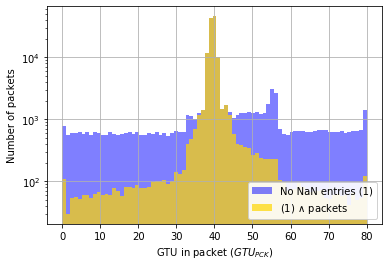

In [75]:
n_bins = 79
plt.figure() 
flight_df.gtu_in_packet.hist(bins=n_bins, alpha=.5, color='blue', range=(0,80), label="No NaN entries (1)")
flight_df_pack.gtu_in_packet.hist(bins=n_bins, alpha=.7, color='gold', range=(0,80), label="(1) $\wedge$ packets")
# flight_df_gtu_36_45_pack.gtu_in_packet.hist(bins=n_bins, alpha=.3, color='blue', range=(0,80), label="$(1) \wedge GTU_{pck} \in [36, 45]$")
# flight_df_gtu_overlap_pack.gtu_in_packet.hist(bins=n_bins, alpha=.3, color='red', range=(0,80), label="$(1) \wedge GTU_{end} > 40 \wedge GTU_{pck} \leq 45$")
plt.legend(loc='lower right', framealpha=.9, facecolor='white', frameon=True)
plt.xlabel('GTU in packet ($GTU_{PCK}$)')
plt.ylabel('Number of packets')
plt.gca().set_yscale('log')
plt.savefig(os.path.join(data_snippets_dir, 'preselection_comparison_gtu_in_packet_pack_vs_no_pack_log.svg'))
plt.show()

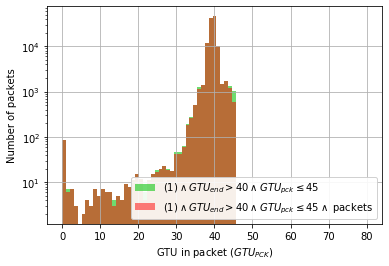

In [76]:
n_bins = 79
plt.figure()
flight_df_gtu_overlap.gtu_in_packet.hist(bins=n_bins, alpha=.7, color='limegreen', range=(0,80), label="$(1) \wedge GTU_{end} > 40 \wedge GTU_{pck} \leq 45$")
flight_df_gtu_overlap_pack.gtu_in_packet.hist(bins=n_bins, alpha=.5, color='red', range=(0,80), label="$(1) \wedge GTU_{end} > 40 \wedge GTU_{pck} \leq 45 \wedge$ packets")
plt.legend(loc='lower right', framealpha=.9, facecolor='white', frameon=True)
plt.xlabel('GTU in packet ($GTU_{PCK}$)')
plt.ylabel('Number of packets')
plt.gca().set_yscale('log')
plt.savefig(os.path.join(data_snippets_dir, 'preselection_comparison_gtu_in_packet_overlap_pack_vs_no_pack_log.svg'))
plt.show()

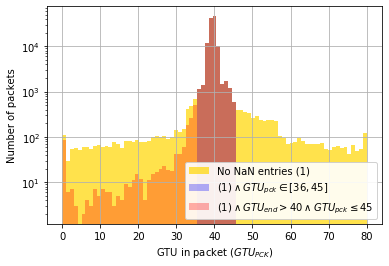

In [77]:
n_bins = 79
plt.figure()
flight_df_pack.gtu_in_packet.hist(bins=n_bins, alpha=.7, color='gold', range=(0,80), label="No NaN entries (1)")
flight_df_gtu_36_45_pack.gtu_in_packet.hist(bins=n_bins, alpha=.3, color='blue', range=(0,80), label="$(1) \wedge GTU_{pck} \in [36, 45]$")
flight_df_gtu_overlap_pack.gtu_in_packet.hist(bins=n_bins, alpha=.3, color='red', range=(0,80), label="$(1) \wedge GTU_{end} > 40 \wedge GTU_{pck} \leq 45$")
plt.legend(loc='lower right', framealpha=.9, facecolor='white', frameon=True)
plt.xlabel('GTU in packet ($GTU_{PCK}$)')
plt.ylabel('Number of packets')
plt.gca().set_yscale('log')
plt.savefig(os.path.join(data_snippets_dir, 'preselection_comparison_gtu_in_packet_log.svg'))
plt.show()

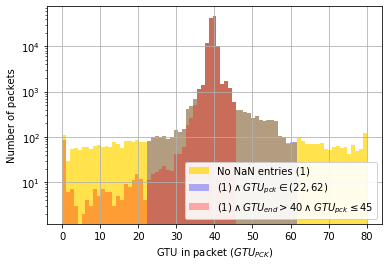

In [78]:
n_bins = 79
plt.figure()
flight_df_pack.gtu_in_packet.hist(bins=n_bins, alpha=.7, color='gold', range=(0,80), label="No NaN entries (1)")
flight_df_as_gtu_40_pack.gtu_in_packet.hist(bins=n_bins, alpha=.3, color='blue', range=(0,80), label="$(1) \wedge GTU_{pck} \in (22, 62)$")
flight_df_gtu_overlap_pack.gtu_in_packet.hist(bins=n_bins, alpha=.3, color='red', range=(0,80), label="$(1) \wedge GTU_{end} > 40 \wedge GTU_{pck} \leq 45$")
plt.legend(loc='lower right', framealpha=.9, facecolor='white', frameon=True)
plt.xlabel('GTU in packet ($GTU_{PCK}$)')
plt.ylabel('Number of packets')
plt.gca().set_yscale('log')
plt.savefig(os.path.join(data_snippets_dir, 'preselection_comparison_w_as_gtu_40_gtu_in_packet_log.svg'))
plt.show()

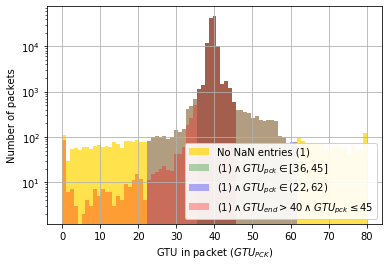

In [79]:
n_bins = 79
plt.figure()
flight_df_pack.gtu_in_packet.hist(bins=n_bins, alpha=.7, color='gold', range=(0,80), label="No NaN entries (1)")
flight_df_gtu_36_45_pack.gtu_in_packet.hist(bins=n_bins, alpha=.3, color='green', range=(0,80), label="$(1) \wedge GTU_{pck} \in [36, 45]$")
flight_df_as_gtu_40_pack.gtu_in_packet.hist(bins=n_bins, alpha=.3, color='blue', range=(0,80), label="$(1) \wedge GTU_{pck} \in (22, 62)$")
flight_df_gtu_overlap_pack.gtu_in_packet.hist(bins=n_bins, alpha=.3, color='red', range=(0,80), label="$(1) \wedge GTU_{end} > 40 \wedge GTU_{pck} \leq 45$")
plt.legend(loc='lower right', framealpha=.9, facecolor='white', frameon=True)
plt.xlabel('GTU in packet ($GTU_{PCK}$)')
plt.ylabel('Number of packets')
plt.gca().set_yscale('log')
plt.savefig(os.path.join(data_snippets_dir, 'preselection_comparison_w_all_gtu_in_packet_log.svg'))
plt.show()

## Statistics of selected events

### Number of events classified "air shower"

In [80]:
np.count_nonzero(flight_df_nonan[cls_column])

2712

In [81]:
np.count_nonzero(flight_df_gtu_36_45[cls_column])

1063

In [82]:
np.count_nonzero(flight_df_gtu_overlap[cls_column])

1106

In [83]:
np.count_nonzero(flight_df_gtu_overlap_pack_nonan[cls_column])

1087

In [84]:
np.count_nonzero(flight_df_gtu_overlap_pack_common_nonan[cls_column])

1063

### Events classified "air shower" - fraction of classified events

In [85]:
np.count_nonzero(flight_df_nonan[cls_column])/len(flight_df_nonan)

0.01313775263045711

In [86]:
np.count_nonzero(flight_df_gtu_overlap_pack_nonan[cls_column]) / num_gtu_36_45_cnz6ec_packets

0.009200870146689126

In [87]:
np.count_nonzero(flight_df_gtu_overlap_pack_common_nonan[cls_column]) / num_gtu_36_45_cnz6ec_packets

0.008997723059733708

### Events classified "air shower" - describe

In [88]:
flight_df_nonan[[cls_column, cls_proba_column]].describe()

,randomforest_cls_on_train_rfecv_est_dropna,randomforest_cls_on_train_rfecv_est_dropna_proba
count,206428.000000,206428.000000
mean,0.013138,0.076805
std,0.113865,0.117941
min,0.000000,0.000000
25%,0.000000,0.001486
50%,0.000000,0.020232
75%,0.000000,0.106528
max,1.000000,0.908622


In [89]:
flight_df_gtu_overlap_pack_nonan[[cls_column, cls_proba_column]].describe()

,randomforest_cls_on_train_rfecv_est_dropna,randomforest_cls_on_train_rfecv_est_dropna_proba
count,119551.000000,119551.000000
mean,0.009092,0.072711
std,0.094920,0.111233
min,0.000000,0.000000
25%,0.000000,0.000647
50%,0.000000,0.016221
75%,0.000000,0.108332
max,1.000000,0.908622


In [90]:
flight_df_gtu_overlap_pack_common_nonan[[cls_column, cls_proba_column]].describe()

,randomforest_cls_on_train_rfecv_est_dropna,randomforest_cls_on_train_rfecv_est_dropna_proba
count,110234.000000,110234.000000
mean,0.009643,0.076684
std,0.097725,0.113289
min,0.000000,0.000000
25%,0.000000,0.000757
50%,0.000000,0.019700
75%,0.000000,0.117390
max,1.000000,0.908622


### Events classified "air shower" - number of events by probability

In [91]:
def num_events_by_proba(
        df, df_label, cls_proba_column=cls_proba_column, 
        show=True, save=True, ax_dict={},
        orient_figsize=(('horizontal', (4,3)), ('vertical', (3,4))), yscale='log', xscale='linear',
        hist_label=None, do_legend=False, ylim=None, legend_kwargs={}, hist_kwargs={}):
    
    from itertools import zip_longest
    
    if not isinstance(hist_label, (list,tuple)):
        hist_label_list = [hist_label]
    else:
        hist_label_list = list(hist_label)
        
    if not isinstance(df, (list,tuple)):
        df_list = [df]
    else:
        df_list = list(df)
    if not isinstance(hist_kwargs, (list,tuple)):
        hist_kwargs_list = [hist_kwargs]
    else:
        hist_kwargs_list = list(hist_kwargs)
    if not isinstance(df_label, (list,tuple)):
        df_label_list = [df_label]
    else:
        df_label_list = list(df_label)
    if not isinstance(cls_proba_column, (list,tuple)):
        cls_proba_column_list = [cls_proba_column]
    else:
        cls_proba_column_list = list(cls_proba_column)
    
    for i, (_df, _df_label) in enumerate(zip(df_list, df_label_list)):
        _cls_proba_column = \
            cls_proba_column_list[i] if i < len(cls_proba_column_list) \
                else cls_proba_column_list[len(cls_proba_column_list) - 1]
        
        print(_df_label)
        print('Tot size: {:<d}'.format(len(_df)))

        for proba in np.arange(0.1, 1.0, 0.1):
            num_gt_proba = np.count_nonzero(_df[_cls_proba_column] > proba)

            i = 1
            while i < 5:
                perc_str = '{v:<.{i}f}'.format(
                    i=i, v=(num_gt_proba / len(_df))*100
                )
                _l = list(set(perc_str.replace('.','')))
                if len(_l) > 1 or '0' not in _l:
                    break
                i += 1

            print('p > {:.2f}: {:<6d}     {} %'.format(
                proba, num_gt_proba, perc_str
            ))
    
    out_ax_dict = {}
    
    for orient_label, figsize in orient_figsize:
        ax_k = (orient_label, figsize)
        if ax_k not in ax_dict:
            fig, _ax = plt.subplots(figsize=figsize)
        else:
            _ax = ax_dict[ax_k]
            fig = _ax.get_figure()
        _ax.grid(linestyle=':') # , which='both'_
        
        _cls_proba_column = None
        _hist_kwargs = {}
        _hist_label = None
        
        for _df, _df_label, _t_cls_proba_column, _hist_label, _t_hist_kwargs in zip_longest(
            df_list, df_label_list, cls_proba_column_list, hist_label_list, hist_kwargs_list
        ):
            
            if _t_cls_proba_column is not None:
                _cls_proba_column = _t_cls_proba_column
            if _t_hist_kwargs is not None:
                _hist_kwargs = _t_hist_kwargs
            if _hist_label is None:
                _hist_label = _df_label
                                
            _t2_hist_kwargs = dict( 
                ax=_ax, figure=fig, 
                bins=100, alpha=1, range=(0,1),
            )
            _t2_hist_kwargs.update(_hist_kwargs)
            _hist_kwargs = _t2_hist_kwargs
            _t3_hist_kwargs = dict(_hist_kwargs)
            _t3_hist_kwargs['label'] = _hist_label
            if _t_hist_kwargs is not None:
                _t3_hist_kwargs.update(_t_hist_kwargs)
            
            _df[_cls_proba_column].hist(**_t3_hist_kwargs)
        
        _ax.set_ylabel('Number of events')
        _ax.set_xlabel('Probability')
        _ax.set_yscale(yscale)
        _ax.set_xscale(xscale)
        if do_legend:
            _ax.legend(**legend_kwargs)
        if ylim:
            _ax.set_ylim(ylim)
        
        if save:
            
            prefix_str = ''
            
            _cls_proba_column = None
            for _df_label, _t_cls_proba_column in zip_longest(df_label_list, cls_proba_column_list):
                if _t_cls_proba_column is not None:
                    _cls_proba_column = _t_cls_proba_column
                if not _df_label.endswith('_'):
                    _df_label += '_'
                if prefix_str:
                    prefix_str += '_'
                prefix_str += _df_label + _cls_proba_column
                
            p = os.path.join(data_snippets_dir, prefix_str +'_distribution_' + orient_label + '.svg')
            print('Saving', p)
            fig.savefig(p, dpi=150)
        
        if show:
            plt.show()
        else:
            out_ax_dict[ax_k] = _ax
    
    if not show:
        return out_ax_dict
    
    return None

In [92]:
mpl.rcParams.update(mpl.rcParamsDefault)
mpl.rcParams['figure.dpi'] = 80

#### flight_df_nonan

flight_df
Tot size: 206428
p > 0.10: 53826      26.1 %
p > 0.20: 27446      13.3 %
p > 0.30: 13411      6.5 %
p > 0.40: 6327       3.1 %
p > 0.50: 2712       1.3 %
p > 0.60: 890        0.4 %
p > 0.70: 216        0.1 %
p > 0.80: 33         0.02 %
p > 0.90: 1          0.0005 %
Saving ver4_machine_learning_flight_classification_tsne_cfg3_20200415_2_randomforest_gtu_40_overlap_cls20200501/flight_df_randomforest_cls_on_train_rfecv_est_dropna_proba_distribution_horizontal.svg


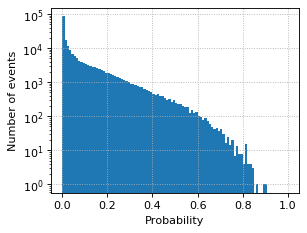

Saving ver4_machine_learning_flight_classification_tsne_cfg3_20200415_2_randomforest_gtu_40_overlap_cls20200501/flight_df_randomforest_cls_on_train_rfecv_est_dropna_proba_distribution_vertical.svg


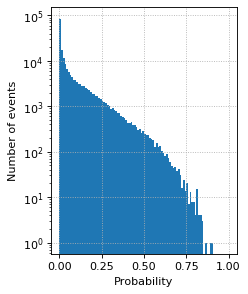

In [93]:
num_events_by_proba(flight_df_nonan, 'flight_df')

flight_df
Tot size: 206428
p > 0.10: 53826      26.1 %
p > 0.20: 27446      13.3 %
p > 0.30: 13411      6.5 %
p > 0.40: 6327       3.1 %
p > 0.50: 2712       1.3 %
p > 0.60: 890        0.4 %
p > 0.70: 216        0.1 %
p > 0.80: 33         0.02 %
p > 0.90: 1          0.0005 %
manually_labeled
Tot size: 4833
p > 0.10: 2248       46.5 %
p > 0.20: 1402       29.0 %
p > 0.30: 762        15.8 %
p > 0.40: 423        8.8 %
p > 0.50: 194        4.0 %
p > 0.60: 73         1.5 %
p > 0.70: 30         0.6 %
p > 0.80: 8          0.2 %
p > 0.90: 1          0.02 %
Saving ver4_machine_learning_flight_classification_tsne_cfg3_20200415_2_randomforest_gtu_40_overlap_cls20200501/flight_df_randomforest_cls_on_train_rfecv_est_dropna_proba_manually_labeled_randomforest_cls_on_train_rfecv_est_dropna_proba_distribution_horizontal.svg


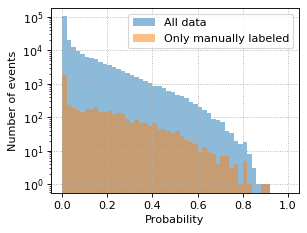

Saving ver4_machine_learning_flight_classification_tsne_cfg3_20200415_2_randomforest_gtu_40_overlap_cls20200501/flight_df_randomforest_cls_on_train_rfecv_est_dropna_proba_manually_labeled_randomforest_cls_on_train_rfecv_est_dropna_proba_distribution_vertical.svg


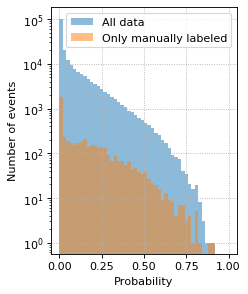

In [94]:
num_events_by_proba(
    [flight_df, flight_df[flight_df[manual_classification_class_number_column] != EVENT_CLASSES['unclassified']] ], 
    ['flight_df', 'manually_labeled'], 
    cls_proba_column=cls_proba_column,
    hist_label=["All data", "Only manually labeled"], 
    hist_kwargs=dict(alpha=0.5, bins=50),
    do_legend=True, save=True)

#### flight_df_pack

flight_df_pack
Tot size: 129174
p > 0.10: 33292      25.8 %
p > 0.20: 16201      12.5 %
p > 0.30: 7120       5.5 %
p > 0.40: 3032       2.3 %
p > 0.50: 1231       1.0 %
p > 0.60: 395        0.3 %
p > 0.70: 90         0.1 %
p > 0.80: 15         0.01 %
p > 0.90: 1          0.001 %
Saving ver4_machine_learning_flight_classification_tsne_cfg3_20200415_2_randomforest_gtu_40_overlap_cls20200501/flight_df_pack_randomforest_cls_on_train_rfecv_est_dropna_proba_distribution_horizontal.svg


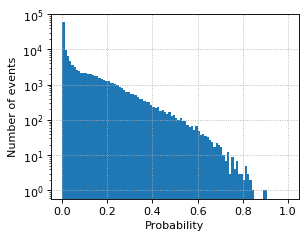

Saving ver4_machine_learning_flight_classification_tsne_cfg3_20200415_2_randomforest_gtu_40_overlap_cls20200501/flight_df_pack_randomforest_cls_on_train_rfecv_est_dropna_proba_distribution_vertical.svg


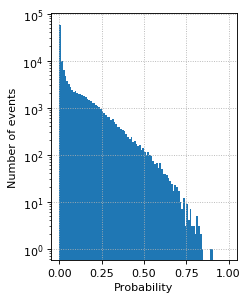

In [95]:
num_events_by_proba(flight_df_pack, 'flight_df_pack')

#### flight_df_gtu_36_45

flight_df_gtu_36_45
Tot size: 118820
p > 0.10: 31191      26.3 %
p > 0.20: 14909      12.5 %
p > 0.30: 6418       5.4 %
p > 0.40: 2656       2.2 %
p > 0.50: 1063       0.9 %
p > 0.60: 333        0.3 %
p > 0.70: 76         0.1 %
p > 0.80: 15         0.01 %
p > 0.90: 1          0.001 %
Saving ver4_machine_learning_flight_classification_tsne_cfg3_20200415_2_randomforest_gtu_40_overlap_cls20200501/flight_df_gtu_36_45_randomforest_cls_on_train_rfecv_est_dropna_proba_distribution_horizontal.svg


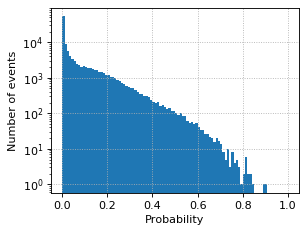

Saving ver4_machine_learning_flight_classification_tsne_cfg3_20200415_2_randomforest_gtu_40_overlap_cls20200501/flight_df_gtu_36_45_randomforest_cls_on_train_rfecv_est_dropna_proba_distribution_vertical.svg


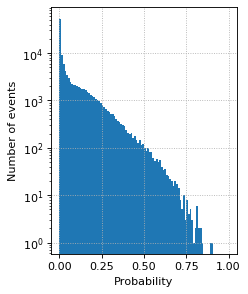

In [96]:
num_events_by_proba(flight_df_gtu_36_45, 'flight_df_gtu_36_45')

#### flight_df_gtu_36_45_pack_nonan

flight_df_gtu_36_45_pack
Tot size: 109027
p > 0.10: 30418      27.9 %
p > 0.20: 14544      13.3 %
p > 0.30: 6219       5.7 %
p > 0.40: 2573       2.4 %
p > 0.50: 1033       0.9 %
p > 0.60: 329        0.3 %
p > 0.70: 75         0.1 %
p > 0.80: 15         0.01 %
p > 0.90: 1          0.001 %
Saving ver4_machine_learning_flight_classification_tsne_cfg3_20200415_2_randomforest_gtu_40_overlap_cls20200501/flight_df_gtu_36_45_pack_randomforest_cls_on_train_rfecv_est_dropna_proba_distribution_horizontal.svg


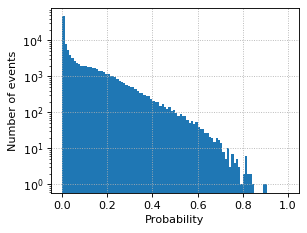

Saving ver4_machine_learning_flight_classification_tsne_cfg3_20200415_2_randomforest_gtu_40_overlap_cls20200501/flight_df_gtu_36_45_pack_randomforest_cls_on_train_rfecv_est_dropna_proba_distribution_vertical.svg


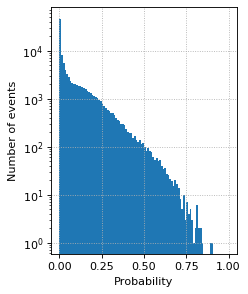

In [97]:
num_events_by_proba(flight_df_gtu_36_45_pack_nonan, 'flight_df_gtu_36_45_pack')

#### flight_df_gtu_overlap

flight_df_gtu_overlap
Tot size: 120293
p > 0.10: 31695      26.3 %
p > 0.20: 15259      12.7 %
p > 0.30: 6604       5.5 %
p > 0.40: 2743       2.3 %
p > 0.50: 1106       0.9 %
p > 0.60: 346        0.3 %
p > 0.70: 82         0.1 %
p > 0.80: 16         0.01 %
p > 0.90: 1          0.001 %
Saving ver4_machine_learning_flight_classification_tsne_cfg3_20200415_2_randomforest_gtu_40_overlap_cls20200501/flight_df_gtu_overlap_randomforest_cls_on_train_rfecv_est_dropna_proba_distribution_horizontal.svg


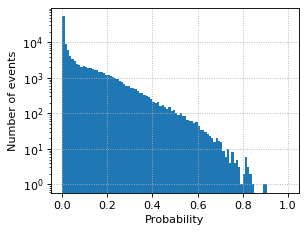

Saving ver4_machine_learning_flight_classification_tsne_cfg3_20200415_2_randomforest_gtu_40_overlap_cls20200501/flight_df_gtu_overlap_randomforest_cls_on_train_rfecv_est_dropna_proba_distribution_vertical.svg


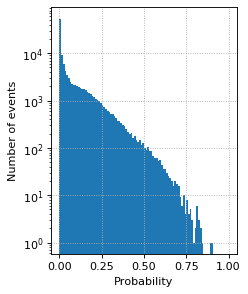

In [98]:
num_events_by_proba(flight_df_gtu_overlap, 'flight_df_gtu_overlap')

#### flight_df_gtu_overlap_pack

flight_df_gtu_overlap_pack
Tot size: 119551
p > 0.10: 31534      26.4 %
p > 0.20: 15166      12.7 %
p > 0.30: 6539       5.5 %
p > 0.40: 2713       2.3 %
p > 0.50: 1087       0.9 %
p > 0.60: 338        0.3 %
p > 0.70: 80         0.1 %
p > 0.80: 15         0.01 %
p > 0.90: 1          0.001 %
Saving ver4_machine_learning_flight_classification_tsne_cfg3_20200415_2_randomforest_gtu_40_overlap_cls20200501/flight_df_gtu_overlap_pack_randomforest_cls_on_train_rfecv_est_dropna_proba_distribution_horizontal.svg


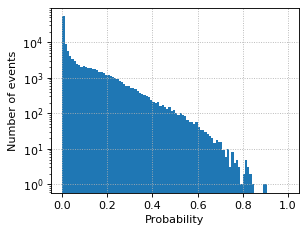

Saving ver4_machine_learning_flight_classification_tsne_cfg3_20200415_2_randomforest_gtu_40_overlap_cls20200501/flight_df_gtu_overlap_pack_randomforest_cls_on_train_rfecv_est_dropna_proba_distribution_vertical.svg


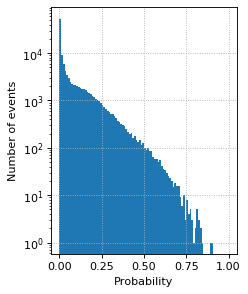

In [99]:
num_events_by_proba(flight_df_gtu_overlap_pack, 'flight_df_gtu_overlap_pack')

#### flight_df_as_gtu_40

flight_df_as_gtu_40
Tot size: 148972
p > 0.10: 38944      26.1 %
p > 0.20: 20233      13.6 %
p > 0.30: 9703       6.5 %
p > 0.40: 4484       3.0 %
p > 0.50: 1922       1.3 %
p > 0.60: 622        0.4 %
p > 0.70: 146        0.1 %
p > 0.80: 23         0.02 %
p > 0.90: 1          0.001 %
Saving ver4_machine_learning_flight_classification_tsne_cfg3_20200415_2_randomforest_gtu_40_overlap_cls20200501/flight_df_as_gtu_40_randomforest_cls_on_train_rfecv_est_dropna_proba_distribution_horizontal.svg


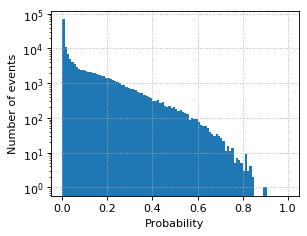

Saving ver4_machine_learning_flight_classification_tsne_cfg3_20200415_2_randomforest_gtu_40_overlap_cls20200501/flight_df_as_gtu_40_randomforest_cls_on_train_rfecv_est_dropna_proba_distribution_vertical.svg


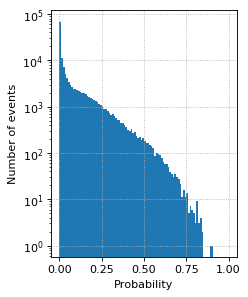

In [100]:
num_events_by_proba(flight_df_as_gtu_40, 'flight_df_as_gtu_40')

#### flight_df_as_gtu_40_pack

flight_df_as_gtu_40_pack
Tot size: 124426
p > 0.10: 32418      26.1 %
p > 0.20: 15756      12.7 %
p > 0.30: 6899       5.5 %
p > 0.40: 2917       2.3 %
p > 0.50: 1183       1.0 %
p > 0.60: 377        0.3 %
p > 0.70: 87         0.1 %
p > 0.80: 15         0.01 %
p > 0.90: 1          0.001 %
Saving ver4_machine_learning_flight_classification_tsne_cfg3_20200415_2_randomforest_gtu_40_overlap_cls20200501/flight_df_as_gtu_40_pack_randomforest_cls_on_train_rfecv_est_dropna_proba_distribution_horizontal.svg


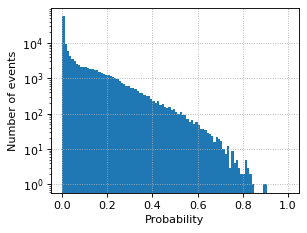

Saving ver4_machine_learning_flight_classification_tsne_cfg3_20200415_2_randomforest_gtu_40_overlap_cls20200501/flight_df_as_gtu_40_pack_randomforest_cls_on_train_rfecv_est_dropna_proba_distribution_vertical.svg


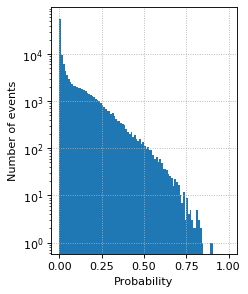

In [101]:
num_events_by_proba(flight_df_as_gtu_40_pack, 'flight_df_as_gtu_40_pack')

flight_df
Tot size: 206428
p > 0.10: 53826      26.1 %
p > 0.20: 27446      13.3 %
p > 0.30: 13411      6.5 %
p > 0.40: 6327       3.1 %
p > 0.50: 2712       1.3 %
p > 0.60: 890        0.4 %
p > 0.70: 216        0.1 %
p > 0.80: 33         0.02 %
p > 0.90: 1          0.0005 %
comparison_flight_df_vs_flight_df_as_gtu_40_pack
Tot size: 124426
p > 0.10: 32418      26.1 %
p > 0.20: 15756      12.7 %
p > 0.30: 6899       5.5 %
p > 0.40: 2917       2.3 %
p > 0.50: 1183       1.0 %
p > 0.60: 377        0.3 %
p > 0.70: 87         0.1 %
p > 0.80: 15         0.01 %
p > 0.90: 1          0.001 %
Saving ver4_machine_learning_flight_classification_tsne_cfg3_20200415_2_randomforest_gtu_40_overlap_cls20200501/comparison_flight_df_vs_flight_df_as_gtu_40_pack_randomforest_cls_on_train_rfecv_est_dropna_proba_distribution_horizontal.svg
Saving ver4_machine_learning_flight_classification_tsne_cfg3_20200415_2_randomforest_gtu_40_overlap_cls20200501/comparison_flight_df_vs_flight_df_as_gtu_40_pack_randomfores

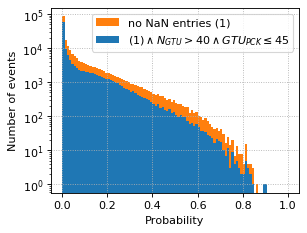

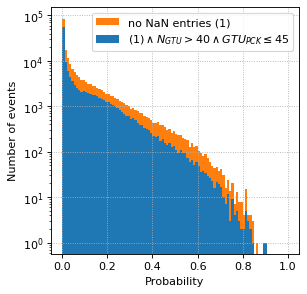

In [102]:
ax_dict = num_events_by_proba(
    flight_df, 'flight_df', show=False, save=False, ax_dict={},
    orient_figsize=(('horizontal', (4,3)), ('vertical', (4,4))),  
    hist_label='no NaN entries (1)', hist_kwargs={'color':'C1'}
)
num_events_by_proba(
    flight_df_as_gtu_40_pack, 'comparison_flight_df_vs_flight_df_as_gtu_40_pack', show=False, save=True, ax_dict=ax_dict, 
    orient_figsize=ax_dict.keys(),  
    yscale='log',  do_legend=True, #ylim=(10**2.5, 10**3.5)
    legend_kwargs={'loc':'upper right'},
    hist_label='$(1) \wedge  N_{GTU} > 40 \wedge GTU_{PCK} \leq 45$', hist_kwargs={'color':'C0'}
)
plt.show()

### Event fractions

#### flight_df_gtu_36_45_pack_nonan

##### Events classified "air shower" - fraction of all events

In [103]:
# this is wrong
np.count_nonzero(flight_df_gtu_36_45_pack_nonan[cls_column])/num_all_events

0.004176842581959922

In [104]:
np.count_nonzero(flight_df_gtu_36_45[cls_column])/num_all_events

0.004298144883468922

In [105]:
np.count_nonzero(flight_df_gtu_36_45_pack_nonan[cls_column])/num_all_packets

0.006964342297761028

##### Events classified "air shower" - fraction of all events in gtu [36, 60]

In [106]:
# this is not correct
np.count_nonzero(flight_df_gtu_36_45_pack_nonan.query('gtu_in_packet >= 36 and gtu_in_packet <= 60')[cls_column])/num_gtu_36_60_events

0.006493588131757606

In [107]:
np.count_nonzero(flight_df_gtu_36_45.query('gtu_in_packet >= 36 and gtu_in_packet <= 60')[cls_column])/num_gtu_36_60_events

0.006682172491828011

In [108]:
np.count_nonzero(flight_df_gtu_36_45[cls_column])/num_gtu_36_60_events

0.006682172491828011

##### Packets classified "air shower" - fraction of all packets

In [109]:
num_cls_1_packets = \
    len(flight_df_gtu_36_45_pack_nonan[flight_df_gtu_36_45_pack_nonan[cls_column] == 1].groupby(
        ['source_file_acquisition', 'packet_id']).count()['event_id'])

In [110]:
print('num_cls_1_packets', num_cls_1_packets)

num_cls_1_packets 1032


In [111]:
num_cls_1_packets/num_all_packets

0.006957600436872585

##### Events classified "air shower" - fraction of all packets triggered in gtu [36, 60]

In [112]:
# this is not principially
num_cls_1_gtu_36_60_packets = \
    len(flight_df_gtu_36_45_pack_nonan[flight_df_gtu_36_45_pack_nonan[cls_column] == 1] \
            .query('gtu_in_packet >= 36 and gtu_in_packet <= 60') \
            .groupby(['source_file_acquisition', 'packet_id']) \
            .count()['event_id'])

In [113]:
print('num_cls_1_gtu_36_60_packets', num_cls_1_gtu_36_60_packets)

num_cls_1_gtu_36_60_packets 1032


In [114]:
num_cls_1_gtu_36_60_packets/num_gtu_36_60_packets

0.007378543595610052

In [115]:
len(flight_df_gtu_36_45[flight_df_gtu_36_45[cls_column] == 1] \
    .query('gtu_in_packet >= 36 and gtu_in_packet <= 60') \
    .groupby(['source_file_acquisition', 'packet_id']) \
    .count()['event_id'])

1062

In [116]:
len(flight_df_gtu_36_45[flight_df_gtu_36_45[cls_column] == 1] \
    .groupby(['source_file_acquisition', 'packet_id']) \
    .count()['event_id'])

1062

#### flight_df_gtu_overlap_pack

##### Events classified "air shower" - fraction of all events

In [117]:
# this is wrong
np.count_nonzero(flight_df_gtu_overlap_pack_nonan[cls_column])/num_all_events

0.004395186724676123

In [118]:
np.count_nonzero(flight_df_gtu_overlap[cls_column])/num_all_events

0.004472011515631823

In [119]:
np.count_nonzero(flight_df_gtu_overlap_pack_nonan[cls_column])/num_all_packets

0.0073284027857369195

##### Events classified "air shower" - fraction of all events in gtu [36, 60]

In [120]:
# this is not correct
np.count_nonzero(
    flight_df_gtu_overlap_pack_nonan.query('gtu_in_packet >= 36 and gtu_in_packet <= 60')[cls_column]
) / num_gtu_36_60_events  # intentional

0.006594166457128489

In [121]:
np.count_nonzero(
    flight_df_gtu_overlap.query('gtu_in_packet >= 36 and gtu_in_packet <= 60')[cls_column]
) / num_gtu_36_60_events

0.006682172491828011

##### Packets classified "air shower" - fraction of all packets

In [122]:
num_cls_1_packets = \
    len(flight_df_gtu_overlap_pack_nonan[flight_df_gtu_overlap_pack_nonan[cls_column] == 1].groupby(
        ['source_file_acquisition', 'packet_id']).count()['event_id'])

In [123]:
print('num_cls_1_packets', num_cls_1_packets)

num_cls_1_packets 1087


In [124]:
num_cls_1_packets/num_all_packets

0.0073284027857369195

#### Events classified "air shower" - fraction of all packets triggered in gtu [36, 60]

In [125]:
# principially this is not correct
num_cls_1_gtu_overlap_packets = \
    len(flight_df_gtu_overlap_pack_nonan[
        flight_df_gtu_overlap_pack_nonan[cls_column] == 1] \
            .query('gtu_in_packet >= 36 and gtu_in_packet <= 60') \
            .groupby(['source_file_acquisition', 'packet_id']) \
            .count()['event_id'])

In [126]:
print('num_cls_1_gtu_36_60_packets', num_cls_1_gtu_36_60_packets)

num_cls_1_gtu_36_60_packets 1032


In [127]:
num_cls_1_gtu_36_60_packets/num_gtu_36_60_packets

0.007378543595610052

### Distribution of classified events by date

In [128]:
mpl.rcParams.update(mpl.rcParamsDefault)

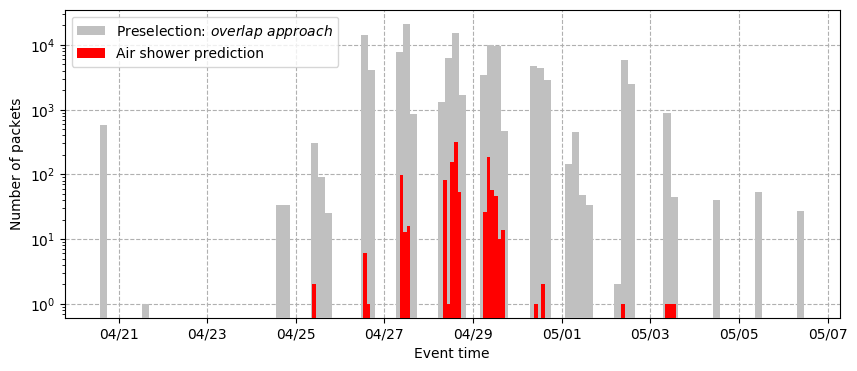

In [129]:
fig, ax = plt.subplots(figsize=(10,4))
ax.grid(which='major', axis='both', linestyle='--', zorder=0)
flight_df_gtu_overlap_pack_nonan['gps_datetime_min'].hist(ax=ax, bins=100, color='silver', label='Preselection: $\it{overlap}$ $\it{approach}$', zorder=3)
flight_df_gtu_overlap_pack_nonan['gps_datetime_min'][flight_df_gtu_overlap_pack_nonan[cls_column] == 1].hist(ax=ax, bins=100, color='red', label='Air shower prediction', zorder=3)
ax.set_yscale('log')
ax.set_ylabel('Number of packets')
ax.set_xlabel('Event time')
ax.xaxis.set_major_formatter(mpl.dates.DateFormatter('%m/%d'))
ax.legend(loc='upper left')
fig.savefig(os.path.join(data_snippets_dir, 'flight_df_gtu_overlap_pack_nonan_distribution_classified_events_by_date_log.svg'))
plt.show()

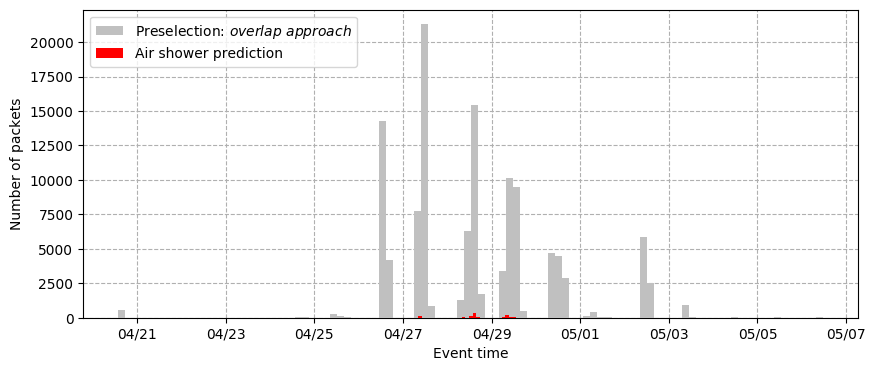

In [130]:
fig, ax = plt.subplots(figsize=(10,4))
ax.grid(which='major', axis='both', linestyle='--', zorder=0)
flight_df_gtu_overlap_pack_nonan['gps_datetime_min'].hist(ax=ax, bins=100, color='silver', label='Preselection: $\it{overlap}$ $\it{approach}$', zorder=3)
flight_df_gtu_overlap_pack_nonan['gps_datetime_min'][flight_df_gtu_overlap_pack_nonan[cls_column] == 1].hist(ax=ax, bins=100, color='red', label='Air shower prediction', zorder=3)
# ax.set_yscale('log')
ax.set_ylabel('Number of packets')
ax.set_xlabel('Event time')
ax.xaxis.set_major_formatter(mpl.dates.DateFormatter('%m/%d'))
ax.legend(loc='upper left')
fig.savefig(os.path.join(data_snippets_dir, 'flight_df_gtu_overlap_pack_nonan_distribution_classified_events_by_date_linear.svg'))
plt.show()

### GTU In packet

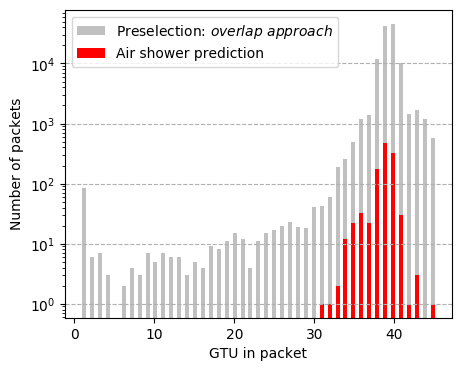

In [131]:
fig, ax = plt.subplots(figsize=(5,4))
ax.grid(which='major', axis='y', linestyle='--')
h = ax.hist(flight_df_gtu_overlap_pack_nonan['gtu_in_packet'], 
            bins=(flight_df_gtu_overlap_pack_nonan['gtu_in_packet'].max() - flight_df_gtu_overlap_pack_nonan['gtu_in_packet'].min())*2 + 1, 
            color='silver', label='Preselection: $\it{overlap}$ $\it{approach}$')
# flight_df_nonan['gtu_in_packet'].hist(ax=ax, bins=65)
# flight_df_nonan['gtu_in_packet'][flight_df_nonan[cls_column] == 1].hist(ax=ax, bins=h[1], color='red', label='Selected candidate events')
ax.hist(flight_df_gtu_overlap_pack_nonan['gtu_in_packet'][flight_df_gtu_overlap_pack_nonan[cls_column] == 1], 
        bins=h[1], color='red', label='Air shower prediction')
ax.set_yscale('log')
ax.set_ylabel('Number of packets')
ax.set_xlabel('GTU in packet')
ax.legend()
fig.savefig(os.path.join(data_snippets_dir, 'flight_df_gtu_overlap_pack_nonan_distribution_classified_events_gtu_in_packet_log.svg'))
plt.show()

In [132]:
# TODO 
# - trigger rate S
# - trigger rate by manual classification

### Trigger rate

In [133]:

def vis_trigger_rate(trigger_datetime_steps_list, trigger_rate_steps_list, file_trigger_p_r_list,
                     ax=None, show=True, ylabel='Number of triggered packets per run [Hz]',
                     marker='o', color=None, alpha=.8, s=10, label=None,
                     scatter_params={}, text_params={},
                     figsize=(20, 6),
                     padding_fraction=.06, p_r_annotation_color='gray',
                     yscale='log', ylim=None, exact_ylim=False,
                     base_figure_pathname=None, recreate_plots=True, savefig_dpi=150, savefig_ext='.png',
                     datetime_range=None, xpadding=datetime.timedelta(days=1)):
    if datetime_range is None:
        min_datetime = np.min(trigger_datetime_steps_list)
        max_datetime = np.max(trigger_datetime_steps_list)
    else:
        min_datetime, max_datetime = datetime_range

    datetime_xlim = (min_datetime - xpadding, max_datetime + xpadding)

    if ax is None:
        fig, ax = plt.subplots(figsize=figsize)

    ax.xaxis.set_major_locator(mpl_dates.DayLocator())
    ax.xaxis.set_major_formatter(mpl_dates.DateFormatter('%m/%d'))
    ax.xaxis.set_minor_locator(mpl_dates.HourLocator(byhour=[6, 12, 18]))

    ax.grid(which='major', axis='both', linestyle='--')
    # plt.gca().grid(which='minor', axis='x', linestyle=':', color="#c0c0c0")

    ax.scatter(
        trigger_datetime_steps_list,
        trigger_rate_steps_list,
        s=s, color=color, alpha=alpha, marker=marker, edgecolors='none',
        label=label,
        **scatter_params
    )

    ylim_min = np.min(trigger_rate_steps_list) if ylim is None else ylim[0]
    ylim_max = np.max(trigger_rate_steps_list) if ylim is None else ylim[1]

    # print(ylim_min, ylim_max)

    ylim_max_p_r_padding = 0
    ylim_max_p_r_text_padding = 0

    if not exact_ylim:
        if yscale == 'log':
            log10_ylim_max = np.log10(ylim_max)
            log10_ylim_min = np.log10(ylim_min)

            # print(log10_ylim_min, log10_ylim_max)

            ylim_padding = (log10_ylim_max - log10_ylim_min) * padding_fraction

            # print(ylim_padding)

            ylim_min = 10 ** (log10_ylim_min - ylim_padding)
            ylim_max = 10 ** (log10_ylim_max + ylim_padding)

            ylim_max_p_r_padding = 10 ** (log10_ylim_max)  # 10 ** (log10_ylim_max + ylim_padding / 3)
            ylim_max_p_r_text_padding = 10 ** (log10_ylim_max + ylim_padding / 2)

        else:
            ylim_padding = (ylim_max - ylim_min) * padding_fraction
            ylim_min = ylim_min - ylim_padding
            ylim_max = ylim_max + ylim_padding
            ylim_max_p_r_padding = ylim_max - ylim_padding
            ylim_max_p_r_text_padding = ylim_max - ylim_padding / 2

    ax.set_yscale(yscale)

    # print(ylim_min, ylim_max)

    ax.set_ylim(ylim_min, ylim_max)

    ax.set_xlim(*datetime_xlim)

    # plt.ylim(1e-1, np.max(trigger_num_per_step)+10)
    ax.set_xlabel('Date [UTC]')
    ax.set_ylabel(ylabel)

    if file_trigger_p_r_list is not None:
        v_prev = file_trigger_p_r_list[0]
        v_x_start = trigger_datetime_steps_list[0]
        v_x_last = v_x_start
        if len(file_trigger_p_r_list) > 1 and len(trigger_datetime_steps_list) > 1:
            for i, (v, v_x) in enumerate(zip(file_trigger_p_r_list[1:], trigger_datetime_steps_list[1:])):
                if v != v_prev or i == len(file_trigger_p_r_list) - 2:
                    ax.plot([v_x_start, v_x_last], [ylim_max_p_r_padding] * 2, color=p_r_annotation_color, linewidth=3)
                    ax.text(v_x_start, ylim_max_p_r_text_padding, 'P={} R={}'.format(*v_prev),
                            color=p_r_annotation_color, **text_params)
                    v_x_start = v_x
                v_prev = v
                v_x_last = v_x

    if base_figure_pathname:
        trigger_rate_scatter_pathname = base_figure_pathname + '_scatter' + savefig_ext
        if not os.path.exists(trigger_rate_scatter_pathname) or recreate_plots:
            plt.savefig(trigger_rate_scatter_pathname, dpi=savefig_dpi)

    if show:
        plt.show()


def calc_trigger_datetime_hist(datetimes_lists):
    min_datetimes = []
    max_datetimes = []

    for datetime_list in datetimes_lists:
        min_datetimes.append(min(datetime_list))
        max_datetimes.append(max(datetime_list))

    return min(min_datetimes), max(max_datetimes)


def trigger_datetime_hist(datetime_list, figsize=(20, 6), color=None, alpha=None,
                          xlabel='Date [UTC]', ylabel='Number of runs',
                          xpadding=datetime.timedelta(days=1),
                          hist_params={}, bin_width_sec=3600,
                          ax=None, show=True,
                          base_figure_pathname=None, recreate_plots=True, savefig_dpi=150, savefig_ext='.svg',
                          hist_bins=None, ret_bins=False, datetime_range=None
                          ):
    if ax is None:
        fig, ax = plt.subplots(figsize=figsize)
    else:
        fig = ax.get_figure()

    ax.xaxis.set_major_locator(mpl_dates.DayLocator())
    ax.xaxis.set_major_formatter(mpl_dates.DateFormatter('%m/%d'))
    ax.xaxis.set_minor_locator(mpl_dates.HourLocator(byhour=[6, 12, 18]))
    ax.grid(which='major', axis='both', linestyle='--')

    if datetime_range is not None:
        min_datetime, max_datetime = datetime_range
    else:
        min_datetime = min(datetime_list)
        max_datetime = max(datetime_list)

    if hist_bins is None:
        hist_bins = \
            int((max_datetime - min_datetime).total_seconds() // bin_width_sec)

        ax.set_xlim(min_datetime - xpadding, max_datetime + xpadding)

    datetime_num_list = mpl_dates.date2num(datetime_list)

    tops, bins, patches = ax.hist(
        datetime_num_list,
        bins=hist_bins,
        range=(min_datetime, max_datetime),
        color=color,
        alpha=alpha,
        **hist_params
    )

    if xlabel is not None:
        ax.set_xlabel(xlabel)

    if ylabel is not None:
        ax.set_ylabel(ylabel)

    if base_figure_pathname:
        fig_pathname = base_figure_pathname + '_datetime_hist' + savefig_ext
        if not os.path.exists(fig_pathname) or recreate_plots:
            plt.savefig(fig_pathname, dpi=savefig_dpi)

    if show:
        plt.show()

    r = [fig, ax]

    if ret_bins:
        r.append(bins)

    return tuple(r)


def trigger_rate_hist(trigger_rate_steps_list, figsize=(20, 6),
                      xlabel='Number of triggered packets per run [Hz]',
                      ylabel='Number of runs',
                      padding_fraction=.10, values_scale='log', color=None, alpha=None,
                      values_lim=None, exact_values_lim=False,
                      orientation='vertical', grid=True,
                      num_bins=30, histogram_bins=None, histogram_args=[], histogram_kwargs={},
                      plot_kwargs={}, ax=None, show=True,
                      base_figure_pathname=None, recreate_plots=True, savefig_dpi=150, savefig_ext='.svg',
                      ret_bins=False, ret_physt=False,
                      trigger_rate_range=None
                      ):
    # TODO histogram rage

    if ax is None:
        fig, ax = plt.subplots(figsize=figsize)
    else:
        fig = ax.get_figure()

    #     datetime_num_list = mpl_dates.date2num(datetime_list)

    #     ax.xaxis.set_major_locator(mpl_dates.DayLocator())
    #     ax.xaxis.set_major_formatter(mpl_dates.DateFormatter('%m/%d'))
    #     ax.xaxis.set_minor_locator(mpl_dates.HourLocator(byhour=[6, 12, 18]))
    if grid:
        ax.grid(which='major', axis='both', linestyle='--')

    #     min_datetime = min(datetime_list) - xpadding
    #     max_datetime = max(datetime_list) + xpadding

    #     hist_bins = \
    #         int((max_datetime - min_datetime).total_seconds()//3600)

    #     print(hist_bins)

    #     ax.set_xlim(min_datetime, max_datetime)

    min_trigger_rate = np.min(trigger_rate_steps_list)
    max_trigger_rate = np.max(trigger_rate_steps_list)

    xlim_min = min_trigger_rate if values_lim is None else values_lim[0]
    xlim_max = max_trigger_rate if values_lim is None else values_lim[1]

    # print(xlim_min, xlim_max)

    xlim_max_p_r_padding = xlim_max - padding_fraction / 3
    xlim_max_p_r_text_padding = xlim_max - padding_fraction / 2

    if not exact_values_lim:
        if values_scale == 'log':
            log10_xlim_max = np.log10(xlim_max)
            log10_xlim_min = np.log10(xlim_min)

            # print(log10_xlim_min, log10_xlim_max)

            xlim_padding = (log10_xlim_max - log10_xlim_min) * padding_fraction

            # print(xlim_padding)

            xlim_min = 10 ** (log10_xlim_min - xlim_padding)
            xlim_max = 10 ** (log10_xlim_max + xlim_padding)

            xlim_max_p_r_padding = 10 ** (log10_xlim_max + xlim_padding / 3)
            xlim_max_p_r_text_padding = 10 ** (log10_xlim_max + xlim_padding / 2)

        else:
            xlim_padding = padding_fraction
            xlim_min = xlim_min - xlim_padding
            xlim_max = xlim_max + xlim_padding
            xlim_max_p_r_padding = xlim_min - xlim_padding / 3
            xlim_max_p_r_text_padding = xlim_max + xlim_padding / 2

    histogram_params = [trigger_rate_steps_list]
    if histogram_bins is None:
        histogram_params.append('exponential' if values_scale == 'log' else 'human')
        if num_bins is not None:
            histogram_params.append(num_bins)
    else:
        histogram_params.append(histogram_bins)
        if num_bins is not None and not isinstance(histogram_params, (list, np.ndarray, tuple)):
            histogram_params.append(num_bins)

    histogram_params += histogram_args

    if trigger_rate_range is not None:
        t_histogram_kwargs = {**histogram_kwargs, 'range': trigger_rate_range}
    else:
        t_histogram_kwargs = trigger_rate_range

    h = physt.histogram(*histogram_params, **t_histogram_kwargs)

    if orientation == 'horizontal':
        h_plot_func = lambda h=h, *kargs, **kwargs: h.plot(*kargs, kind='barh', backend='matplotlib', **kwargs)
        lim_func = ax.set_ylim
        scale_func = ax.set_yscale
        ylabel_func = ax.set_xlabel
        xlabel_func = ax.set_ylabel
    else:
        h_plot_func = h.plot
        lim_func = ax.set_xlim
        scale_func = ax.set_xscale
        xlabel_func = ax.set_xlabel  # intentionally
        ylabel_func = ax.set_ylabel

    h_plot_func(ax=ax, **{'color': color, 'alpha': alpha, **plot_kwargs})

    lim_func(xlim_min, xlim_max)
    scale_func(values_scale)

    if xlabel is not None:
        xlabel_func(xlabel)

    if ylabel is not None:
        ylabel_func(ylabel)

    # log-scaled bins

    #     print(xlim_min, xlim_max)

    #     bins = np.logspace(np.log(min_trigger_rate), np.log(max_trigger_rate), num_bins)
    #     widths = (bins[1:] - bins[:-1])

    #     # Calculate histogram
    #     hist = np.histogram(trigger_rate_steps_list, bins=bins)
    #     # normalize by bin width
    #     hist_norm = hist[0]/widths

    #     print(bins[:-1])
    #     print(hist_norm)

    #     ax.plot(bins[:-1], hist_norm)

    #     ax.bar(bins[:-1], hist_norm, widths, **plot_kwargs)

    #     ax.hist(
    #         trigger_rate_steps_list,
    #         bins=250,
    #         **plot_kwargs
    #    )

    #     n, x, p = plt.hist([datetime.datetime(2018,1,1),  datetime.datetime(2018, 2, 1),
    #                  datetime.datetime(2018,3, 1)])

    if base_figure_pathname:
        fig_pathname = base_figure_pathname + '_trigger_rate_hist' + savefig_ext
        if not os.path.exists(fig_pathname) or recreate_plots:
            plt.savefig(fig_pathname, dpi=savefig_dpi)

    if show:
        plt.show()

    r = [fig, ax]

    if ret_physt:
        r.append(h)
    elif ret_bins:
        r.append(h.bins)

    return tuple(r)


def vis_trigger_rate_w_distributions(
        file_trigger_datetime_list, file_trigger_rate_list, file_trigger_p_r_list=None,
        label=None, color=None, scatter_alpha=0.8, hist_alpha=1, ylim=(10 ** (-2.5), 10 ** (2.5)),
        do_datetime_hist=True, do_trigger_rate_hist=True,
        datetime_yscale='log', datetime_bin_width_sec=3600 * 6,
        vis_trigger_rate_kwargs={}, datetime_hist_kwargs={}, trigger_rate_hist_kwargs={},
        ax_scatter=None, ax_histx=None, ax_histy=None,
        figsize=(10, 6),
        left=0.1, width=0.8, bottom=0.1, height=0.70, hspacing=0.005,
        show=True, legend=False, legend_kwargs={},
        base_figure_pathname=None, recreate_plots=True, savefig_dpi=150, savefig_ext='.png',
        ret_datetime_hist_bins=False, ret_trigger_rate_hist_bins=False,
        datetime_hist_bins=None, trigger_rate_hist_bins=None,
        datetime_range=None, xpadding=datetime.timedelta(days=1)
):
    some_ax_none = False
    some_ax_not_none = False

    for ax in (ax_scatter, ax_histx, ax_histy):
        if ax is None:
            some_ax_none = True
        if ax is not None:
            some_ax_not_none = True

    if some_ax_not_none:
        if ax_histx is None:
            do_datetime_hist = False
        if ax_histy is None:
            do_trigger_rate_hist = False

    if not some_ax_not_none:

        if not do_datetime_hist:
            height = 1 - bottom

        if not do_trigger_rate_hist:
            width = 1 - left

        fig = plt.figure(1, figsize=figsize)

        fig_size_inches = fig.get_size_inches()
        vspacing = hspacing * fig_size_inches[0] / fig_size_inches[1]

        rect_scatter = [left, bottom, width, height]
        rect_histx = [left, bottom + height + vspacing, width, 1 - (bottom + height + vspacing)]
        rect_histy = [left + width + hspacing, bottom, 1 - (left + width + hspacing), height]

        ax_scatter = plt.axes(rect_scatter)
        if do_datetime_hist:
            ax_histx = plt.axes(rect_histx, sharex=ax_scatter)
        if do_trigger_rate_hist:
            ax_histy = plt.axes(rect_histy, sharey=ax_scatter)
    elif ax_scatter is not None:
        fig = ax_scatter.get_figure()
    else:
        fig = None

    vis_trigger_rate(
        file_trigger_datetime_list, file_trigger_rate_list, file_trigger_p_r_list,
        ylim=ylim, label=label, color=color, alpha=scatter_alpha,
        ax=ax_scatter, show=False,
        datetime_range=datetime_range,
        **vis_trigger_rate_kwargs
    )

    trigger_datetime_hist_r = None

    if do_datetime_hist:
        trigger_datetime_hist_r = trigger_datetime_hist(
            file_trigger_datetime_list, bin_width_sec=datetime_bin_width_sec,
            color=color, alpha=hist_alpha,
            ax=ax_histx, show=False,
            ret_bins=ret_datetime_hist_bins,
            hist_bins=datetime_hist_bins,
            datetime_range=datetime_range,
            **datetime_hist_kwargs
        )

        if datetime_yscale is not None:
            ax_histx.set_yscale(datetime_yscale)

    # trigger_rate_hist(otgpp_file_trigger_rate_list, values_lim=(10**(-2.5), 10**(2.5)), ax=ax_histx)

    trigger_rate_hist_r = None

    if do_trigger_rate_hist:
        trigger_rate_hist_r = trigger_rate_hist(
            file_trigger_rate_list, orientation='horizontal',
            color=color, alpha=hist_alpha,
            values_lim=ax_scatter.get_ylim(),
            ax=ax_histy,
            plot_kwargs={'tight_layout': False},
            show=False,
            ret_bins=ret_trigger_rate_hist_bins,
            histogram_bins=trigger_rate_hist_bins,
            trigger_rate_range=ylim if ylim is not None else None,
            **trigger_rate_hist_kwargs
        )

    ax_scatter.tick_params(which='both', axis='both', direction='in', top=True, right=True)

    if do_datetime_hist:
        ax_histx.tick_params(which='both', axis='both', direction='in', labelbottom=False)
        ax_histx.set_xlabel(None)

    if do_trigger_rate_hist:
        ax_histy.tick_params(which='both', axis='both', direction='in', labelleft=False)
        ax_histy.set_ylabel(None)

    if legend:
        legend_for_scatterplots(ax_scatter, legend_kwargs=legend_kwargs)

    if base_figure_pathname:
        fig_pathname = base_figure_pathname + '_scatter_and_hist' + savefig_ext
        if not os.path.exists(fig_pathname) or recreate_plots:
            plt.savefig(fig_pathname, dpi=savefig_dpi)

    if show:
        plt.show()

    # binwidth = 0.25
    # xymax = np.max([np.max(np.fabs(x)), np.max(np.fabs(y))])
    # lim = (int(xymax/binwidth) + 1) * binwidth

    ret = [fig, ax_scatter, ax_histx, ax_histy]

    if ret_datetime_hist_bins:
        ret.append(trigger_datetime_hist_r[-1] if trigger_datetime_hist_r is not None else None)
    if ret_trigger_rate_hist_bins:
        ret.append(trigger_rate_hist_r[-1] if trigger_rate_hist_r is not None else None)

    return tuple(ret)

# -----------------------------------------------------------------

def make_line2d_dot(markerfacecolor='red', marker='o', color='white', **kwargs):
    return matplotlib.lines.Line2D(range(1), range(1), color=color, marker=marker, markerfacecolor=markerfacecolor, **kwargs)


def legend_for_scatterplots(ax, make_handle_func=make_line2d_dot, apply=True, legend_kwargs={}):
    handles = []
    labels = []
    for coll in ax.collections:
        markerfacecolor = np.array(coll.get_facecolors()[0])
        markerfacecolor[3] = 1  # alpha=1
        label = coll.get_label()
        handles.append(make_handle_func(markerfacecolor))
        labels.append(label)

    if apply:
        return ax.legend(handles, labels, **legend_kwargs)
    else:
        return handles, labels


#### All flight HW events

In [134]:
# hw_trigger_num_per_file = joblib.load('trigger_rate_for_l1trg/hw_trg2feee3b0332fbd7fea6241885d90f2aa_one_trg_per_packet_128_trigger_num_per_file.pkl')
hw_trigger_rate_per_file = joblib.load('trigger_rate_for_l1trg/hw_trg2feee3b0332fbd7fea6241885d90f2aa_one_trg_per_packet_128_trigger_rate_per_file.pkl')
hw_file_trigger_datetimes = joblib.load('trigger_rate_for_l1trg/hw_trg2feee3b0332fbd7fea6241885d90f2aa_one_trg_per_packet_128_file_trigger_datetimes.pkl')
# hw_file_trigger_p_r = joblib.load('trigger_rate_for_l1trg/hw_trg2feee3b0332fbd7fea6241885d90f2aa_one_trg_per_packet_128_file_trigger_p_r.pkl')
# hw_file_trigger_timedelta = joblib.load('trigger_rate_for_l1trg/hw_trg2feee3b0332fbd7fea6241885d90f2aa_one_trg_per_packet_128_file_trigger_timedelta.pkl')
# hw_file_indices = joblib.load('trigger_rate_for_l1trg/hw_trg2feee3b0332fbd7fea6241885d90f2aa_one_trg_per_packet_128_file_indices.pkl')

#### All bgf=0.5 events

In [135]:
# bgf05_trigger_num_per_file_list = joblib.load('trigger_rate_for_l1trg/bgf05_with_flatmap2feee3b0332fbd7fea6241885d90f2aa_one_trg_per_packet_128_trigger_num_per_file.pkl')
bgf05_trigger_rate_per_file_list = joblib.load('trigger_rate_for_l1trg/bgf05_with_flatmap2feee3b0332fbd7fea6241885d90f2aa_one_trg_per_packet_128_trigger_rate_per_file.pkl')
bgf05_file_trigger_datetimes_list = joblib.load('trigger_rate_for_l1trg/bgf05_with_flatmap2feee3b0332fbd7fea6241885d90f2aa_one_trg_per_packet_128_file_trigger_datetimes.pkl')
# bgf05_file_trigger_p_r_list = joblib.load('trigger_rate_for_l1trg/bgf05_with_flatmap2feee3b0332fbd7fea6241885d90f2aa_one_trg_per_packet_128_file_trigger_p_r.pkl')
# bgf05_file_trigger_timedelta_list = joblib.load('trigger_rate_for_l1trg/bgf05_with_flatmap2feee3b0332fbd7fea6241885d90f2aa_one_trg_per_packet_128_file_trigger_timedelta.pkl')
# bgf05_file_indices_list = joblib.load('trigger_rate_for_l1trg/bgf05_with_flatmap2feee3b0332fbd7fea6241885d90f2aa_one_trg_per_packet_128_file_indices.pkl')

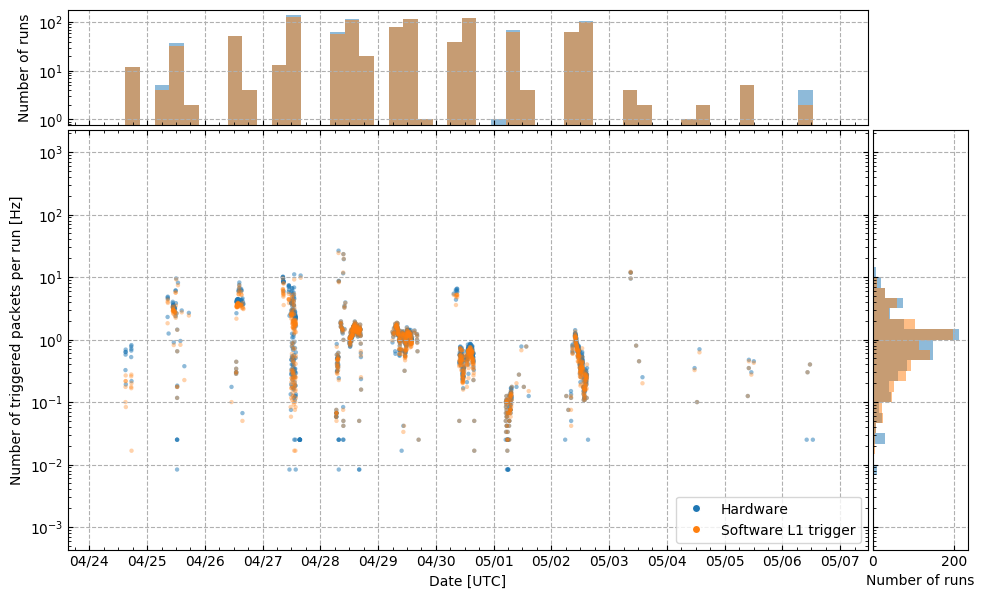

In [136]:
fig, ax_scatter, ax_histx, ax_histy, datetime_bins, trgrt_bins = \
    vis_trigger_rate_w_distributions(
        hw_file_trigger_datetimes,
        hw_trigger_rate_per_file, 
        ylim=(10**(-2.5), 10**(2.5)),
        label='Hardware', color='C0', hist_alpha=.5, scatter_alpha=.5,
        show=False,
        ret_datetime_hist_bins=True, ret_trigger_rate_hist_bins=True
    )
# gray

vis_trigger_rate_w_distributions(
    bgf05_file_trigger_datetimes_list,
    bgf05_trigger_rate_per_file_list,
    ylim=(10**(-2.5), 10**(2.5)), 
    label='Software L1 trigger', color='C1', hist_alpha=.5, scatter_alpha=.35,
    base_figure_pathname=os.path.join(data_snippets_dir, 'trg_rate_1_per_packet_hw_vs_bgf05.png'),
    ax_scatter=ax_scatter, ax_histx=ax_histx, ax_histy=ax_histy,
    legend=True, legend_kwargs={'loc': 'lower right'},
    show=True,
    datetime_hist_bins=datetime_bins, trigger_rate_hist_bins=trgrt_bins
);
# dodgerblue

#### All classified events

In [137]:
all_classified_trigger_datetime_list, all_classified_trigger_rate_list = \
    count_trigger_rate_per_file_from_df(flight_df_nonan,  one_trg_per='packet')

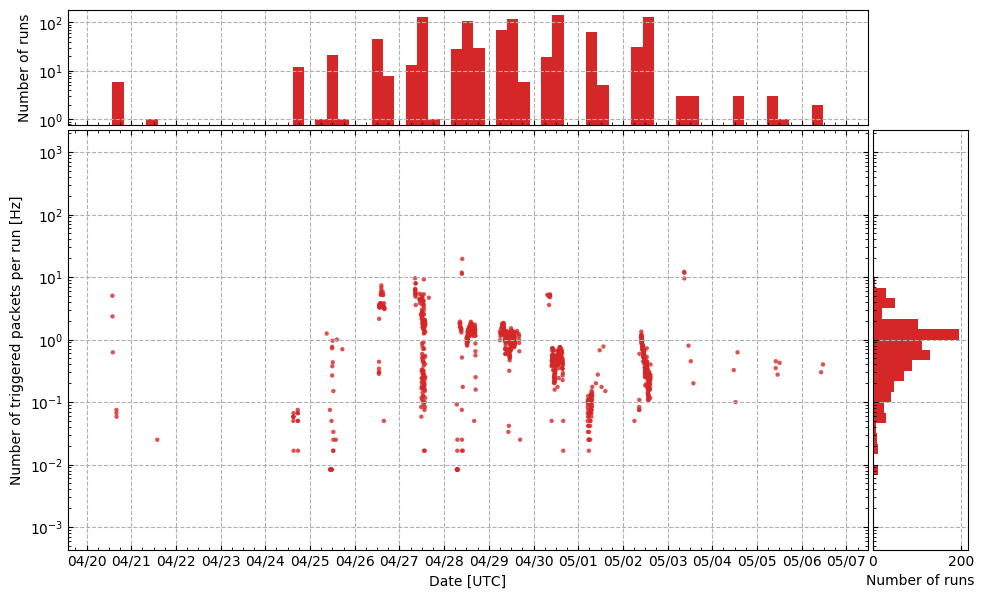

In [138]:
vis_trigger_rate_w_distributions(
    all_classified_trigger_datetime_list, 
    all_classified_trigger_rate_list,
    ylim=(10**(-2.5), 10**(2.5)),
    color='C3',
    base_figure_pathname=os.path.join(data_snippets_dir, 'trg_rate_1_per_packet_classified_all')
);
# limegreen

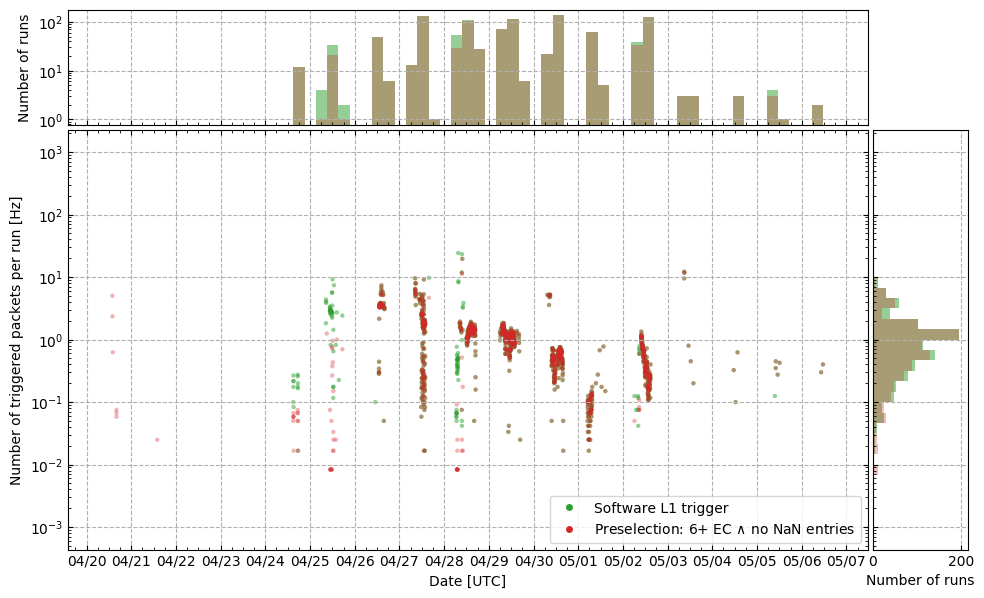

In [139]:
fig, ax_scatter, ax_histx, ax_histy, datetime_bins, trgrt_bins = \
    vis_trigger_rate_w_distributions(
        bgf05_file_trigger_datetimes_list,
        bgf05_trigger_rate_per_file_list,
        ylim=(10**(-2.5), 10**(2.5)),
        label='Software L1 trigger', color='C2', hist_alpha=.5, scatter_alpha=.5,
        show=False,
        ret_datetime_hist_bins=True, ret_trigger_rate_hist_bins=True
    )
#dodgerblue

vis_trigger_rate_w_distributions(
    all_classified_trigger_datetime_list, 
    all_classified_trigger_rate_list,
    ylim=(10**(-2.5), 10**(2.5)), 
    label='Preselection: 6+ EC $\wedge$ no NaN entries', color='C3', hist_alpha=.3, scatter_alpha=.35,
    base_figure_pathname=os.path.join(data_snippets_dir, 'trg_rate_1_per_packet_bgf05_vs_classified'),
    ax_scatter=ax_scatter, ax_histx=ax_histx, ax_histy=ax_histy,
    legend=True, legend_kwargs={'loc': 'lower right'},
    show=True,
    datetime_hist_bins=datetime_bins, trigger_rate_hist_bins=trgrt_bins
);

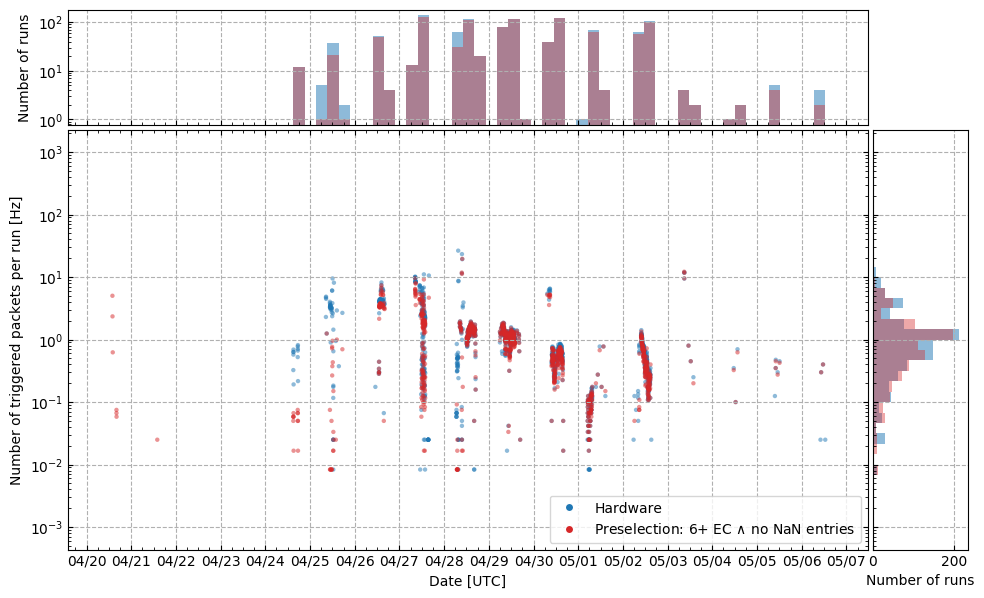

In [140]:
fig, ax_scatter, ax_histx, ax_histy, datetime_bins, trgrt_bins = \
    vis_trigger_rate_w_distributions(
        hw_file_trigger_datetimes,
        hw_trigger_rate_per_file, 
        ylim=(10**(-2.5), 10**(2.5)),
        label='Hardware', color='C0', hist_alpha=.5, scatter_alpha=.5,
        show=False,
        ret_datetime_hist_bins=True, ret_trigger_rate_hist_bins=True
    )

vis_trigger_rate_w_distributions(
    all_classified_trigger_datetime_list, 
    all_classified_trigger_rate_list,
    ylim=(10**(-2.5), 10**(2.5)), 
    label='Preselection: 6+ EC $\wedge$ no NaN entries', color='C3', hist_alpha=.4, scatter_alpha=.5,
    base_figure_pathname=os.path.join(data_snippets_dir, 'trg_rate_1_per_packet_hw_vs_classified'),
    ax_scatter=ax_scatter, ax_histx=ax_histx, ax_histy=ax_histy,
    legend=True, legend_kwargs={'loc': 'lower right'},
    show=True,
    datetime_hist_bins=datetime_bins, trigger_rate_hist_bins=trgrt_bins
);

#### All classified events (preselection flight_df_gtu_overlap_pack_nonan)

In [141]:
gtu_overlap_pack_trigger_datetime_list, gtu_overlap_pack_trigger_rate_list = \
    count_trigger_rate_per_file_from_df(flight_df_gtu_overlap_pack_nonan,  one_trg_per='packet')

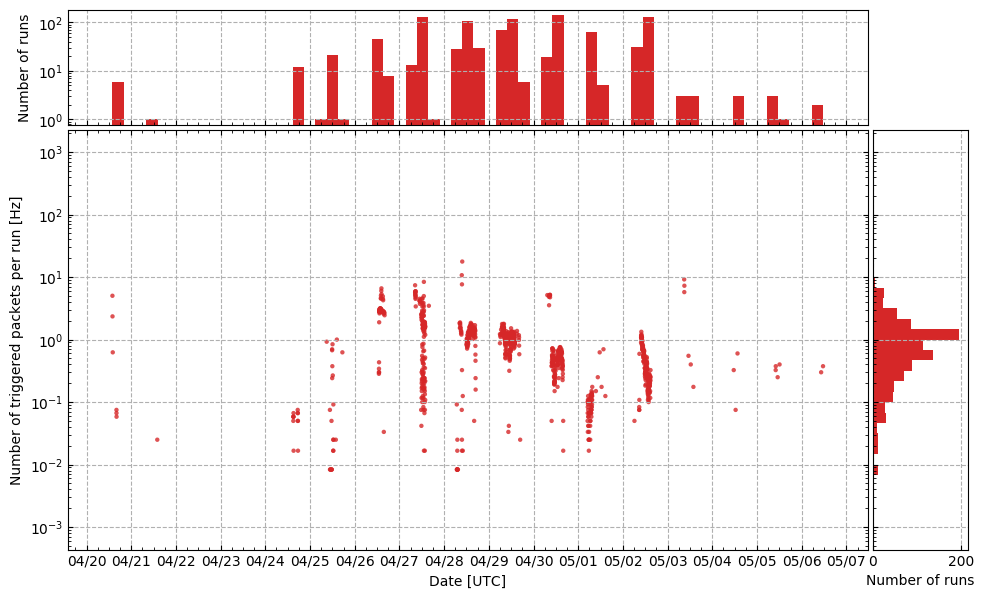

In [142]:
vis_trigger_rate_w_distributions(
    gtu_overlap_pack_trigger_datetime_list, 
    gtu_overlap_pack_trigger_rate_list,
    ylim=(10**(-2.5), 10**(2.5)),
    color='C3',
    base_figure_pathname=os.path.join(data_snippets_dir, 'trg_rate_1_per_packet_gtu_overlap_pack')
);
# limegreen

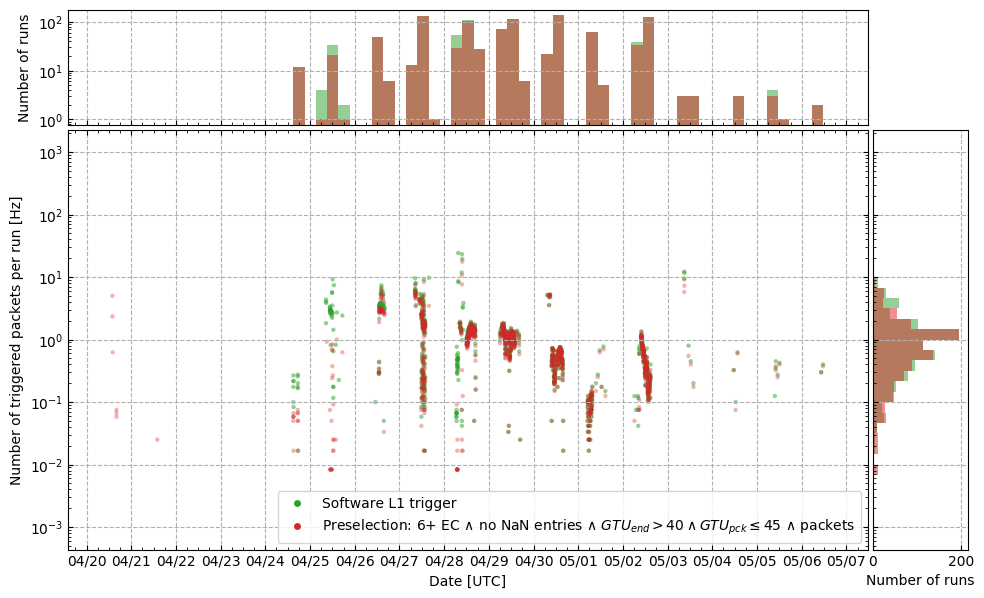

In [143]:
fig, ax_scatter, ax_histx, ax_histy, datetime_bins, trgrt_bins = \
    vis_trigger_rate_w_distributions(
        bgf05_file_trigger_datetimes_list,
        bgf05_trigger_rate_per_file_list,
        ylim=(10**(-2.5), 10**(2.5)),
        label='Software L1 trigger', color='C2', hist_alpha=.5, scatter_alpha=.5,
        show=False,
        ret_datetime_hist_bins=True, ret_trigger_rate_hist_bins=True
    )
#dodgerblue

vis_trigger_rate_w_distributions(
    gtu_overlap_pack_trigger_datetime_list, 
    gtu_overlap_pack_trigger_rate_list,
    ylim=(10**(-2.5), 10**(2.5)), 
    label='Preselection: 6+ EC $\wedge$ no NaN entries $\wedge$ $GTU_{end} > 40 \wedge GTU_{pck} \leq 45$ $\wedge$ packets', 
    color='C3', hist_alpha=.5, scatter_alpha=.35,
    base_figure_pathname=os.path.join(data_snippets_dir, 'trg_rate_1_per_packet_bgf05_vs_gtu_overlap_pack'),
    ax_scatter=ax_scatter, ax_histx=ax_histx, ax_histy=ax_histy,
    legend=True, legend_kwargs={'loc': 'lower right'},
    show=True,
    datetime_hist_bins=datetime_bins, trigger_rate_hist_bins=trgrt_bins
);

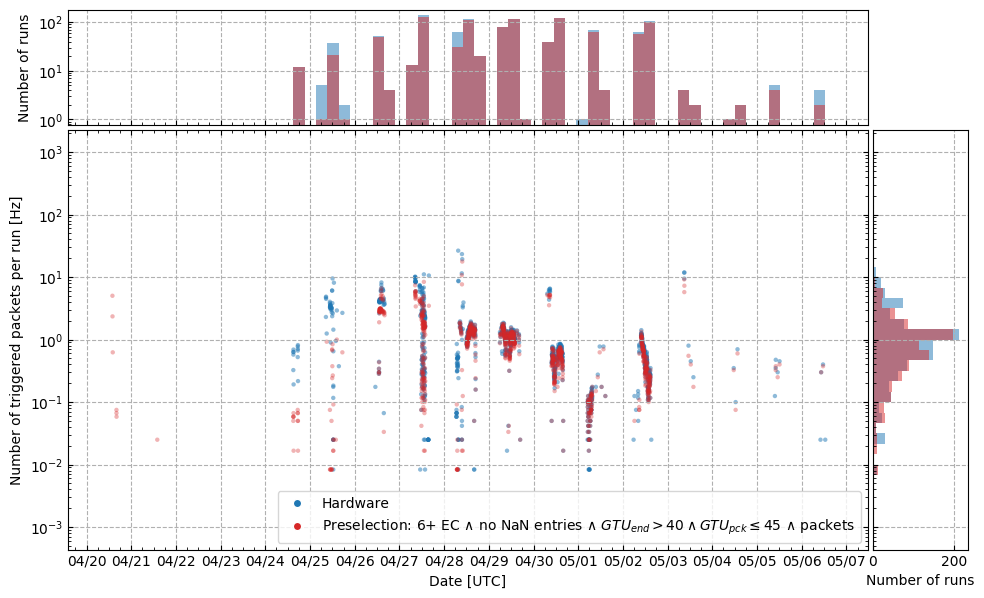

In [144]:
fig, ax_scatter, ax_histx, ax_histy, datetime_bins, trgrt_bins = \
    vis_trigger_rate_w_distributions(
        hw_file_trigger_datetimes,
        hw_trigger_rate_per_file, 
        ylim=(10**(-2.5), 10**(2.5)),
        label='Hardware', color='C0', hist_alpha=.5, scatter_alpha=.5,
        show=False,
        ret_datetime_hist_bins=True, ret_trigger_rate_hist_bins=True
    )

vis_trigger_rate_w_distributions(
    gtu_overlap_pack_trigger_datetime_list, 
    gtu_overlap_pack_trigger_rate_list,
    ylim=(10**(-2.5), 10**(2.5)), 
    label='Preselection: 6+ EC $\wedge$ no NaN entries $\wedge$ $GTU_{end} > 40 \wedge GTU_{pck} \leq 45$ $\wedge$ packets', 
    color='C3', hist_alpha=.5, scatter_alpha=.35,
    base_figure_pathname=os.path.join(data_snippets_dir, 'trg_rate_1_per_packet_hw_vs_gtu_overlap_pack'),
    ax_scatter=ax_scatter, ax_histx=ax_histx, ax_histy=ax_histy,
    legend=True, legend_kwargs={'loc': 'lower right'},
    show=True,
    datetime_hist_bins=datetime_bins, trigger_rate_hist_bins=trgrt_bins
);

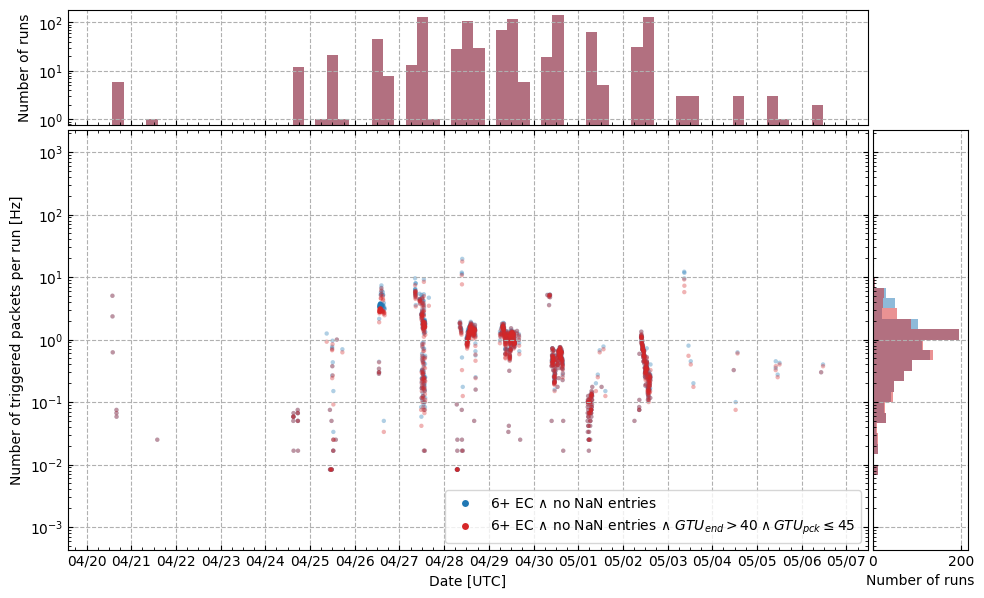

In [145]:
fig, ax_scatter, ax_histx, ax_histy, datetime_bins, trgrt_bins = \
    vis_trigger_rate_w_distributions(
        all_classified_trigger_datetime_list, 
        all_classified_trigger_rate_list,
        ylim=(10**(-2.5), 10**(2.5)), 
        label='6+ EC $\wedge$ no NaN entries', color='C0', hist_alpha=.5, scatter_alpha=.35,
        show=False,
        ret_datetime_hist_bins=True, ret_trigger_rate_hist_bins=True
    )

vis_trigger_rate_w_distributions(
    gtu_overlap_pack_trigger_datetime_list, 
    gtu_overlap_pack_trigger_rate_list,
    ylim=(10**(-2.5), 10**(2.5)), 
    label='6+ EC $\wedge$ no NaN entries $\wedge$ $GTU_{end} > 40 \wedge GTU_{pck} \leq 45$', color='C3', hist_alpha=.5, scatter_alpha=.35,
    base_figure_pathname=os.path.join(data_snippets_dir, 'trg_rate_1_per_packet_bgf05_vs_gtu_overlap_pack'),
    ax_scatter=ax_scatter, ax_histx=ax_histx, ax_histy=ax_histy,
    legend=True, legend_kwargs={'loc': 'lower right'},
    show=True,
    datetime_hist_bins=datetime_bins, trigger_rate_hist_bins=trgrt_bins
);

In [146]:
as_gtu_40_trigger_datetime_list, as_gtu_40_trigger_rate_list = \
    count_trigger_rate_per_file_from_df(flight_df_as_gtu_40,  one_trg_per='packet')

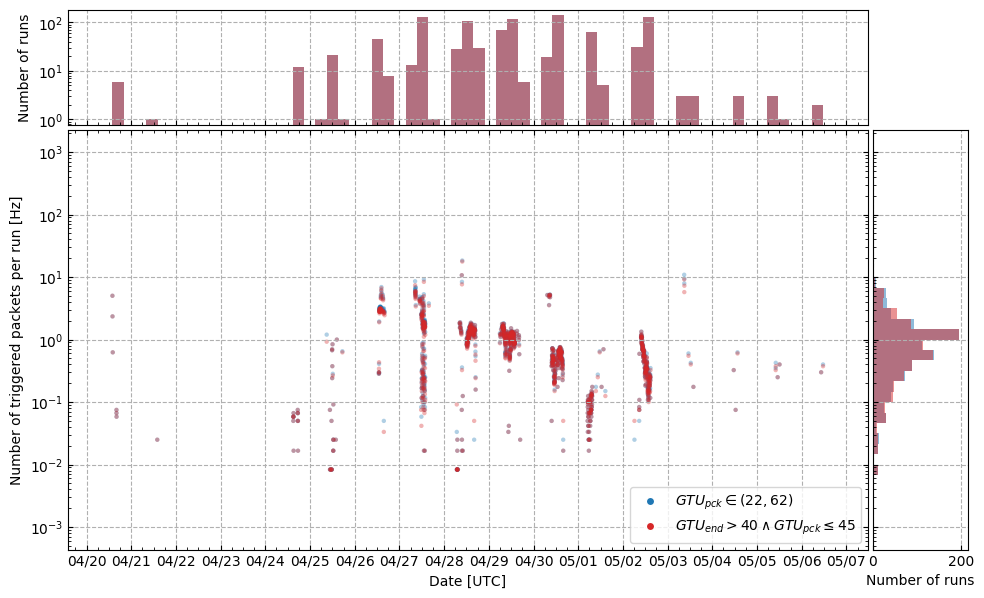

In [147]:
fig, ax_scatter, ax_histx, ax_histy, datetime_bins, trgrt_bins = \
    vis_trigger_rate_w_distributions(
        as_gtu_40_trigger_datetime_list, 
        as_gtu_40_trigger_rate_list,
        ylim=(10**(-2.5), 10**(2.5)), 
        label='$GTU_{pck} \in (22, 62)$', color='C0', hist_alpha=.5, scatter_alpha=.35,
        show=False,
        ret_datetime_hist_bins=True, ret_trigger_rate_hist_bins=True
    )

vis_trigger_rate_w_distributions(
    gtu_overlap_pack_trigger_datetime_list, 
    gtu_overlap_pack_trigger_rate_list,
    ylim=(10**(-2.5), 10**(2.5)), 
    label='$GTU_{end} > 40 \wedge GTU_{pck} \leq 45$', color='C3', hist_alpha=.5, scatter_alpha=.35,
    base_figure_pathname=os.path.join(data_snippets_dir, 'trg_rate_1_per_packet_as_gtu_40_vs_gtu_overlap_pack'),
    ax_scatter=ax_scatter, ax_histx=ax_histx, ax_histy=ax_histy,
    legend=True, legend_kwargs={'loc': 'lower right'},
    show=True,
    datetime_hist_bins=datetime_bins, trigger_rate_hist_bins=trgrt_bins
);

#### Events classified as "air shower"

In [148]:
shower_trigger_datetime_list, shower_trigger_rate_list = \
    count_trigger_rate_per_file_from_df(flight_df_gtu_overlap_pack_nonan[flight_df_gtu_overlap_pack_nonan[cls_column] == 1],  one_trg_per='packet')

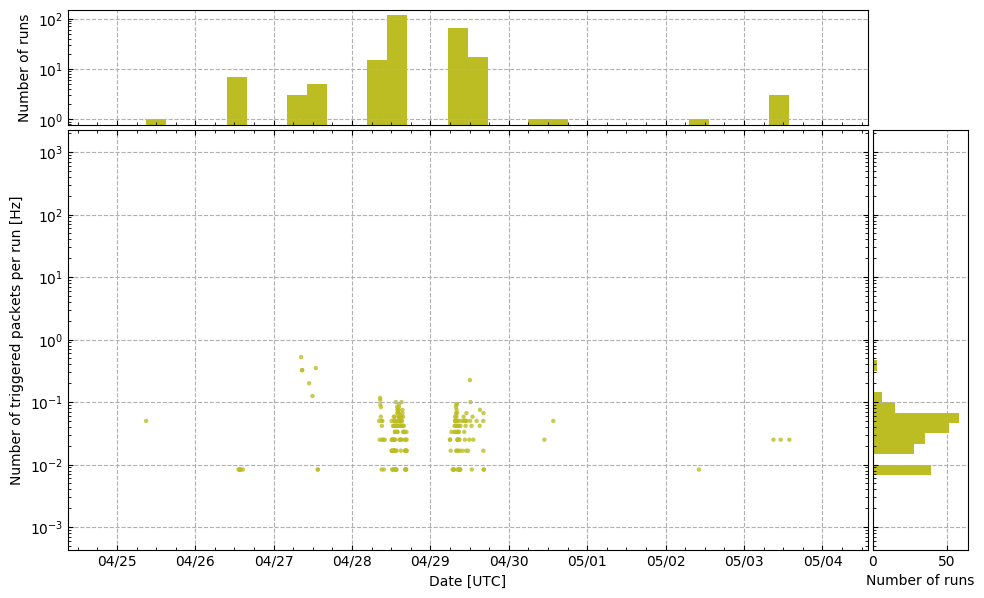

In [149]:
vis_trigger_rate_w_distributions(
    shower_trigger_datetime_list, 
    shower_trigger_rate_list,
    ylim=(10**(-2.5), 10**(2.5)),
    color='C8',
    base_figure_pathname=os.path.join(data_snippets_dir, 'flight_df_gtu_overlap_pack_nonan_trg_rate_1_per_packet_classified_air_shower')
);

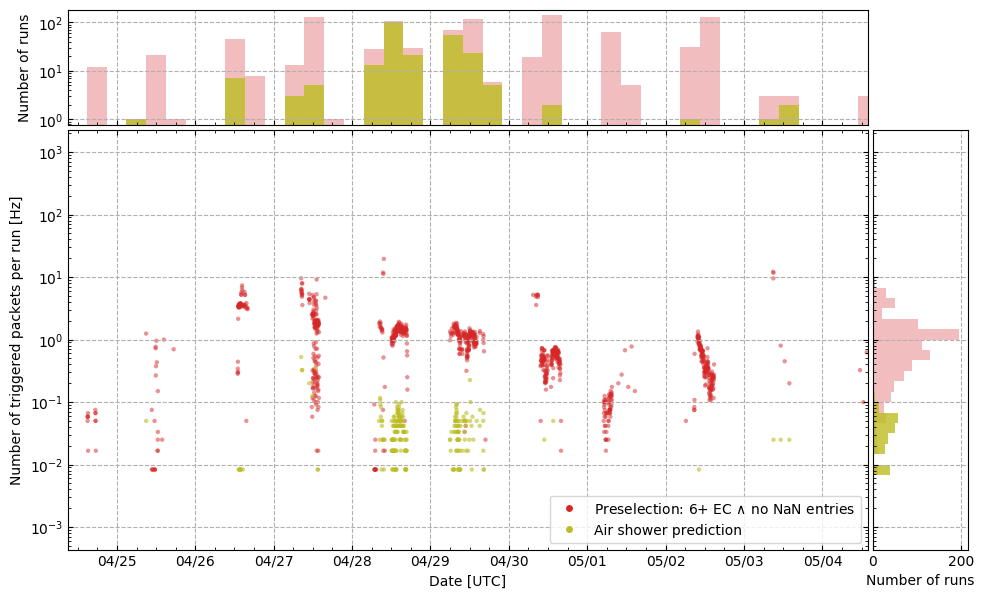

In [150]:
fig, ax_scatter, ax_histx, ax_histy, datetime_bins, trgrt_bins = \
    vis_trigger_rate_w_distributions(
        all_classified_trigger_datetime_list, 
        all_classified_trigger_rate_list,
        ylim=(10**(-2.5), 10**(2.5)),
        label='Preselection: 6+ EC $\wedge$ no NaN entries', color='C3', hist_alpha=.3, scatter_alpha=.5,
        show=False,
        ret_datetime_hist_bins=True, ret_trigger_rate_hist_bins=True
    )

vis_trigger_rate_w_distributions(
    shower_trigger_datetime_list, 
    shower_trigger_rate_list,
    ylim=(10**(-2.5), 10**(2.5)), 
    label='Air shower prediction', color='C8', hist_alpha=.8, scatter_alpha=.6,
    base_figure_pathname=os.path.join(data_snippets_dir, 'flight_df_gtu_overlap_pack_nonan_trg_rate_1_per_packet_classified_vs_selected'),
    ax_scatter=ax_scatter, ax_histx=ax_histx, ax_histy=ax_histy,
    legend=True, legend_kwargs={'loc': 'lower right'},
    show=True,
    datetime_hist_bins=datetime_bins, trigger_rate_hist_bins=trgrt_bins
);

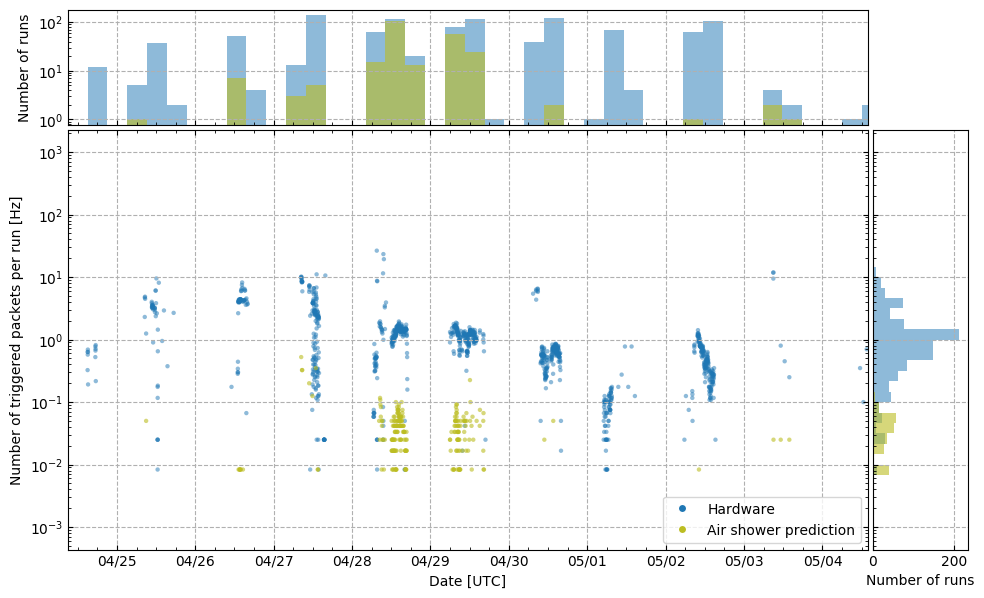

In [151]:
fig, ax_scatter, ax_histx, ax_histy, datetime_bins, trgrt_bins = \
    vis_trigger_rate_w_distributions(
        hw_file_trigger_datetimes,
        hw_trigger_rate_per_file, 
        ylim=(10**(-2.5), 10**(2.5)),
        label='Hardware', color='C0', hist_alpha=.5, scatter_alpha=.5,
        show=False,
        ret_datetime_hist_bins=True, ret_trigger_rate_hist_bins=True
    )

vis_trigger_rate_w_distributions(
    shower_trigger_datetime_list, 
    shower_trigger_rate_list,
    ylim=(10**(-2.5), 10**(2.5)), 
    label='Air shower prediction', color='C8', hist_alpha=.6, scatter_alpha=.6,
    base_figure_pathname=os.path.join(data_snippets_dir, 'flight_df_gtu_overlap_pack_nonan_trg_rate_1_per_packet_hw_vs_selected.'),
    ax_scatter=ax_scatter, ax_histx=ax_histx, ax_histy=ax_histy,
    legend=True, legend_kwargs={'loc': 'lower right'},
    show=True,
    datetime_hist_bins=datetime_bins, trigger_rate_hist_bins=trgrt_bins
);

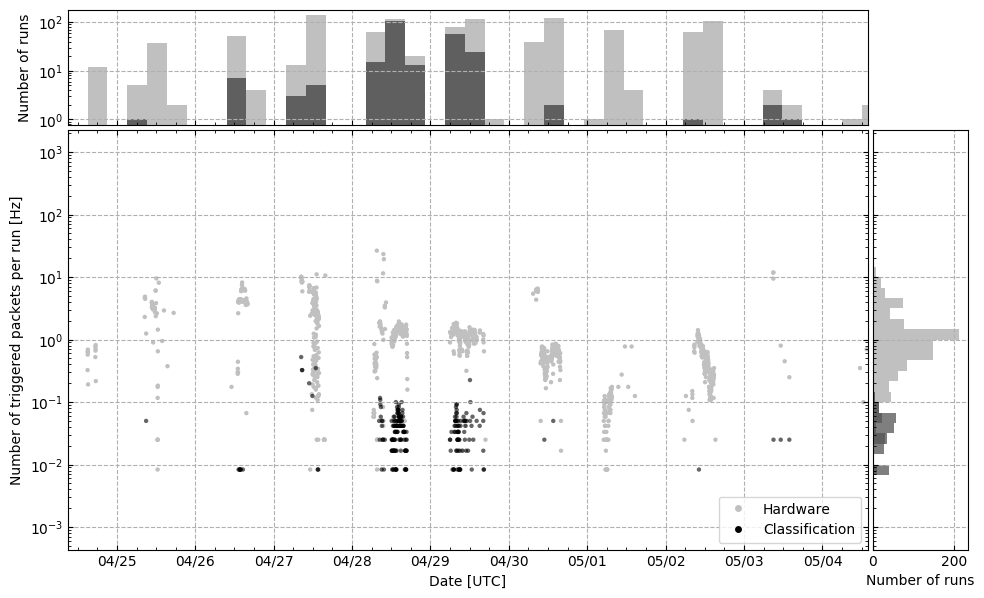

In [152]:
fig, ax_scatter, ax_histx, ax_histy, datetime_bins, trgrt_bins = \
    vis_trigger_rate_w_distributions(
        hw_file_trigger_datetimes,
        hw_trigger_rate_per_file, 
        ylim=(10**(-2.5), 10**(2.5)),
        label='Hardware', color='silver', hist_alpha=1, scatter_alpha=1,
        show=False,
        ret_datetime_hist_bins=True, ret_trigger_rate_hist_bins=True
    )

vis_trigger_rate_w_distributions(
    shower_trigger_datetime_list, 
    shower_trigger_rate_list,
    ylim=(10**(-2.5), 10**(2.5)), 
    label='Classification', color='black', hist_alpha=.5, scatter_alpha=.6,
    base_figure_pathname=os.path.join(data_snippets_dir, 'flight_df_gtu_overlap_pack_nonan_trg_rate_1_per_packet_hw_vs_selected_bw.png'),
    ax_scatter=ax_scatter, ax_histx=ax_histx, ax_histy=ax_histy,
    legend=True, legend_kwargs={'loc': 'lower right'},
    show=True,
    datetime_hist_bins=datetime_bins, trigger_rate_hist_bins=trgrt_bins
);

#### Summary - mean trigger rate

In [153]:
print('Mean trigger rate in hardware data:          ', np.mean(hw_trigger_rate_per_file))
print('Mean trigger rate in feature-extracted data: ', np.mean(bgf05_trigger_rate_per_file_list))
print('Mean trigger rate in classified data:        ', np.mean(all_classified_trigger_rate_list))
print('Mean trigger rate in classifer selected data:', np.mean(shower_trigger_rate_list))

Mean trigger rate in hardware data:           1.448051447935921
Mean trigger rate in feature-extracted data:  1.3001118568232661
Mean trigger rate in classified data:         1.172233333333333
Mean trigger rate in classifer selected data: 0.04464285714285716


### Distribution of classified events by manual classification

In [154]:
sns.set(style="whitegrid")

In [155]:
flight_df_gtu_overlap_pack_nonan[manual_classification_class_label_column].value_counts()

Unclassified                115510
Pixel                          708
Pixel with a blob behind       429
Blob                           415
Top-left EC                    386
Sudden bg. increase            317
Single GTU track               218
Unspecified noise              211
Few pixels                     200
Large blob                     196
Short single GTU track         188
Bright blob                    141
Persistent pixel               134
Noise                          129
2 pix line                      96
Cartesian line                  73
Sparse blobs                    61
Noise with a weak pixel         43
Unspecified                     42
Blob and pixels                 36
Storng light                    18
Name: manual_classification_class_label, dtype: int64

#### Rainbow plots

Withount unclassified
All flight data in the selection


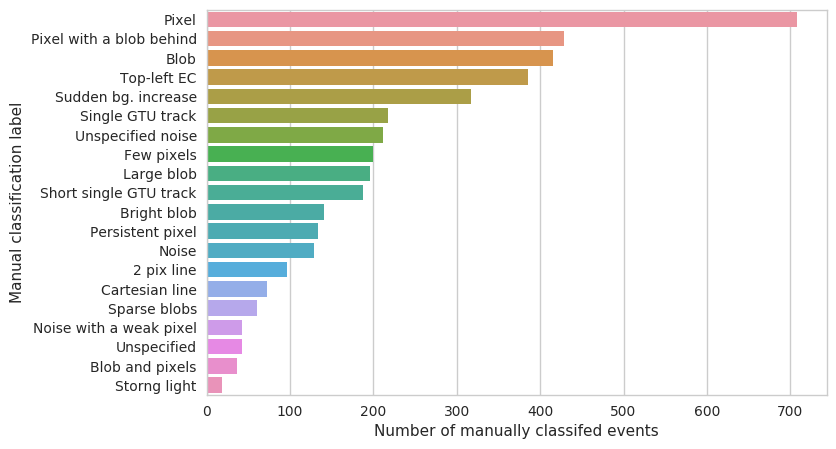

Events classified as positive


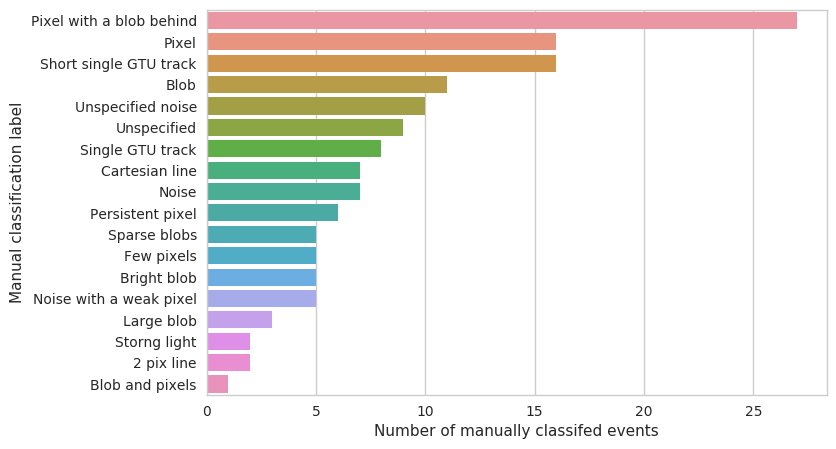

With unclassified
All flight data in the selection


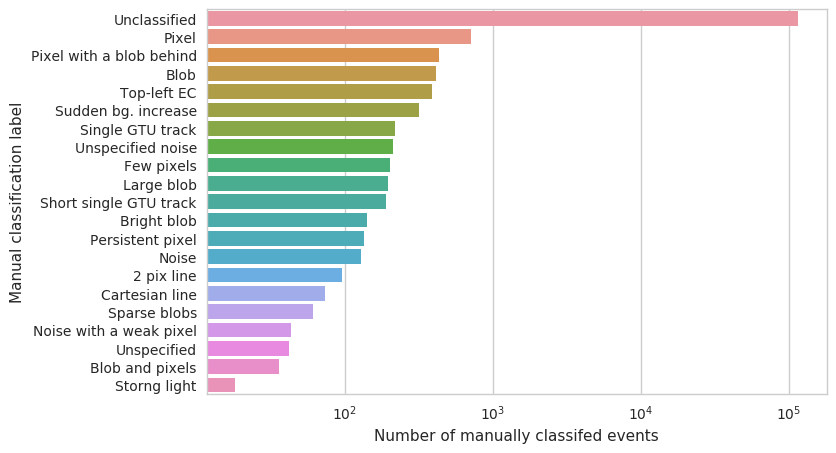

Events classified as positive


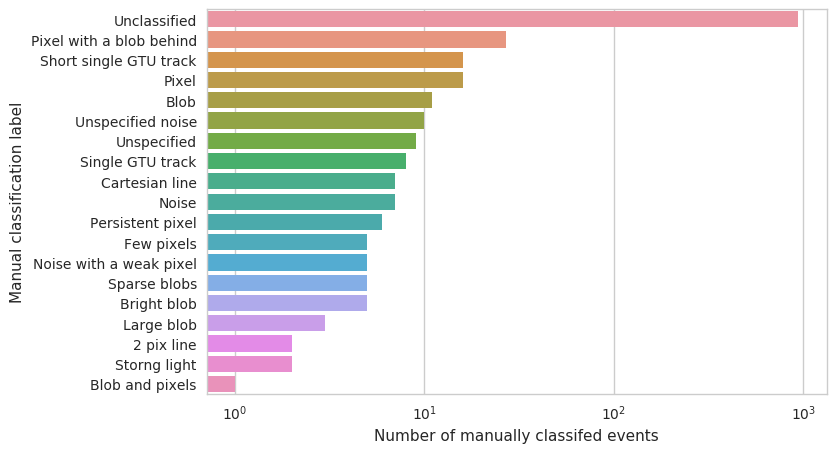

In [156]:
# requires manual_classification_class_label_column

for w_unclassified in [False, True]:
    
    print('{} unclassified'.format('With' if w_unclassified else 'Withount'))
    
    for apply_air_shower_filter in [False, True]:
    
        print('Events classified as positive' if apply_air_shower_filter else 'All flight data in the selection')
    
        subset_df = \
            flight_df_gtu_overlap_pack_nonan[flight_df_gtu_overlap_pack_nonan[manual_classification_class_number_column] != EVENT_CLASSES['unclassified']] \
            if not w_unclassified else \
            flight_df_gtu_overlap_pack_nonan
    
        subset_df = subset_df[subset_df[cls_column] == 1] \
            if apply_air_shower_filter else subset_df
    
        fig, ax = plt.subplots(1, figsize=(8,5))
        sns.countplot(y=manual_classification_class_label_column, 
                      data=subset_df, ax=ax, orient='v',
                      order=subset_df[manual_classification_class_label_column].value_counts().index,
                     )
        
        ax.set_ylabel('Manual classification label')
        ax.set_xlabel('Number of manually classifed events')

        flight_data_manual_classification_class_name_dist_fig_pathname = \
            os.path.join(
                data_snippets_dir, 
                'flight_df_gtu_overlap_pack_nonan_flight_data_manual_classification_class_label_distribution{}{}.svg'.format(
                    '_with_unclassified' if w_unclassified else '',
                    '_positive' if apply_air_shower_filter else ''
                ))

        if w_unclassified:
            ax.set_xscale('log')

        fig.savefig(flight_data_manual_classification_class_name_dist_fig_pathname, dpi=150)
        plt.show()
    
    print('='*50)

##### Another rainbow 
WHat is it doing? - INVESTIGATE puropose and usefulness

Withount unclassified


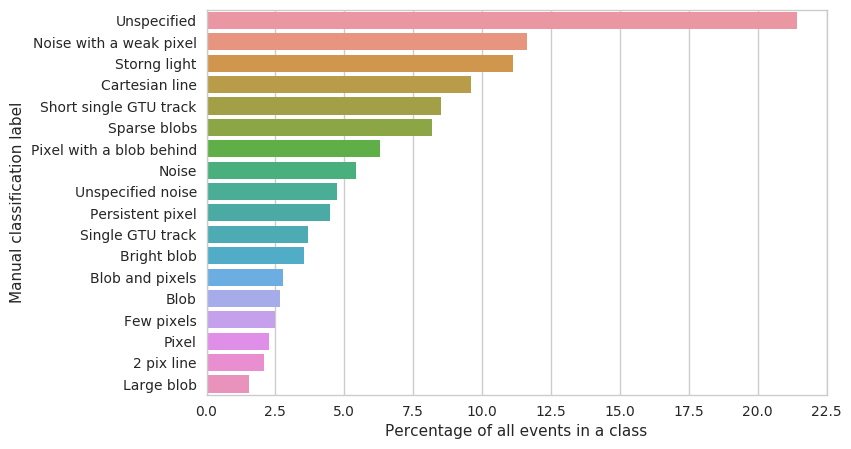

With unclassified


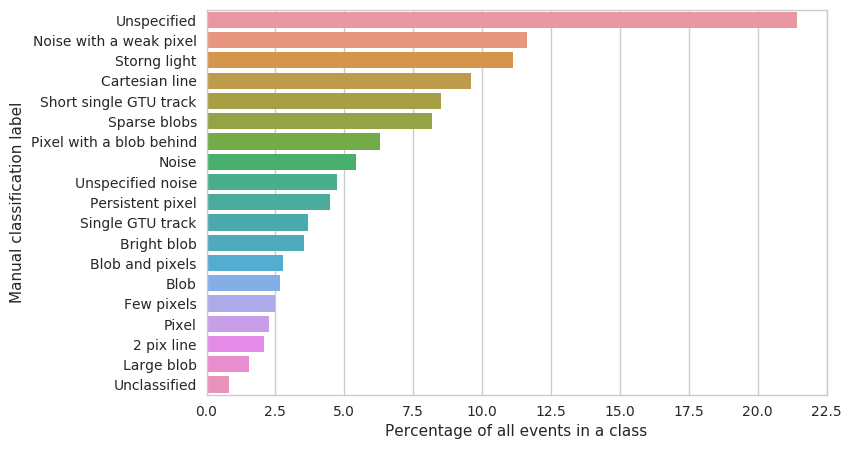

In [157]:
# flight_data_nonan_class_ratios_df

for w_unclassified in [False, True]:
    
    print('{} unclassified'.format('With' if w_unclassified else 'Withount'))

    subset_df = \
        flight_df_gtu_overlap_pack_nonan[
            flight_df_gtu_overlap_pack_nonan[manual_classification_class_number_column] != EVENT_CLASSES['unclassified']
        ] if not w_unclassified else flight_df_gtu_overlap_pack_nonan

    flight_data_nonan_class_ratios_df = \
        subset_df.groupby([manual_classification_class_label_column])[cls_column] \
            .value_counts(normalize=True).rename('percentage').mul(100).reset_index().sort_values(cls_column)

    fig, ax = plt.subplots(1, figsize=(8,5))

    subset_df = flight_data_nonan_class_ratios_df[flight_data_nonan_class_ratios_df[cls_column] == 1]
    
    p = sns.barplot(y=manual_classification_class_label_column, 
                    x="percentage", #hue=cls_column, 
                    data=subset_df, 
                    ax=ax, orient='h',
                    order=subset_df[manual_classification_class_label_column].iloc[
                        np.argsort(-subset_df["percentage"])],
                   )

    ax.set_ylabel('Manual classification label')
    ax.set_xlabel('Percentage of all events in a class')

    flight_data_manual_classification_class_name_dist_fig_pathname = \
        os.path.join(
            data_snippets_dir, 
            'flight_df_gtu_overlap_pack_nonan_flight_data_manual_classification_class_label_normalized_distribution{}.svg'.format(
                '_with_unclassified' if w_unclassified else ''
            ))

#     if w_unclassified:
#         ax.set_xscale('log')

    fig.savefig(flight_data_manual_classification_class_name_dist_fig_pathname, dpi=150)
    plt.show()

#### Ver2 fraction barplot

In [158]:
learning_data_train = np.load(os.path.join(model_evaluation_data_snippets_dir, 'events', 'learning_data_train.npz'))
learning_data_test = np.load(os.path.join(model_evaluation_data_snippets_dir, 'events', 'learning_data_test.npz'))

##### Visualization functions

In [159]:
def manual_classification_fraction_barplot(
        df, mc_cls_num, w_unclassified, file_name_prefix, cls_column=cls_column,
        EVENT_CLASSES=EVENT_CLASSES, INVERSE_EVENT_CLASSES_LABELS=INVERSE_EVENT_CLASSES_LABELS,
        print_info=True, print_fractions=False, fig_width=3, fig_height_line=0.3):
    
    # sns.set(style="whitegrid") # should be called before the function
    
    
    #print('{} unclassified'.format('With' if w_unclassified else 'Withount'))

    subset_df = df[df[mc_cls_num] != EVENT_CLASSES['unclassified']] if not w_unclassified else df
    
    #print('Num. unspecified', np.count_nonzero(subset_df[mc_cls_num] == EVENT_CLASSES['unspecified']))
        
    manual_classification_class_count_df = \
        subset_df.groupby([mc_cls_num])['event_id'].count()

#     print('manual_classification_class_count_df')
#     print(manual_classification_class_count_df)
#     print('----------')
    
    subset_cls_1_df = subset_df[subset_df[cls_column] == 1]
    
    if print_info:
        print('Total num:', len(subset_df))
        print('Num. predicted 1:', len(subset_cls_1_df))
        if w_unclassified:
            print('Total num unclassified:    ', len(df[df[mc_cls_num] == EVENT_CLASSES['unclassified']]))
            print('Total num not unclassified:', len(df[df[mc_cls_num] != EVENT_CLASSES['unclassified']]))
            print('Total num unclassified (pred 1):    ', len(subset_cls_1_df[subset_cls_1_df[mc_cls_num] == EVENT_CLASSES['unclassified']]))
            print('Total num not unclassified (pred 1):', len(subset_cls_1_df[subset_cls_1_df[mc_cls_num] != EVENT_CLASSES['unclassified']]))
    
    manual_classification_class_positive_count_df = \
        subset_cls_1_df.groupby([mc_cls_num])['event_id'].count()

#     print('manual_classification_class_positive_count_df')
#     print(manual_classification_class_positive_count_df)
#     print('----------')
    
#     print(np.isin(manual_classification_class_count_df.index, manual_classification_class_positive_count_df.index))
    
    manual_classification_class_in_positive_count_df = \
        manual_classification_class_count_df[
            np.isin(manual_classification_class_count_df.index, manual_classification_class_positive_count_df.index)
        ]
    
#     print(
#         manual_classification_class_count_df[manual_classification_class_positive_count_df.index]
#     )

    fraction_ser = (
        manual_classification_class_positive_count_df.values / 
        manual_classification_class_count_df[manual_classification_class_positive_count_df.index]
    )
    
    fraction_ser.sort_values(ascending=False, inplace=True)

#     print('fraction_ser')
#     print(fraction_ser)
#     print('--------------')
#     print('manual_classification_class_positive_count_df[fraction_ser]')
#     print(manual_classification_class_positive_count_df[fraction_ser.index] )
#     print('--------------')
#     print('manual_classification_class_count_df[fraction_ser.index].values')
#     print(manual_classification_class_count_df[fraction_ser.index].values)
    
    err = sm_stats_proportion.proportion_confint(
        manual_classification_class_positive_count_df[fraction_ser.index].values,
        manual_classification_class_count_df[fraction_ser.index].values, 
        alpha=0.05, 
        method='beta'
    )
    
    xerr = (
        (fraction_ser - err[0])*100,
        (err[1] - fraction_ser)*100
    )
    
#     print('--------------')
#     print('xerr')
#     print(xerr)
    
#     print([INVERSE_EVENT_CLASSES_LABELS[int(v)] for v in fraction_ser.index])
#     print(fraction_ser*100)
    
    if print_fractions:
        
        for label, fraction, xerr_0, xerr_1 in zip(
                [INVERSE_EVENT_CLASSES_LABELS[int(v)] for v in fraction_ser.index], 
                fraction_ser*100, xerr[0], xerr[1]
        ):
            print('{:<30} {:<5.2f}  {:<5.2f} {:<5.2f}'.format(
                label, fraction, xerr_0, xerr_1
            ))
    
    fig, ax = plt.subplots(1, figsize=(fig_width, len(fraction_ser.index)*fig_height_line))
    p = sns.barplot(
                    y=[INVERSE_EVENT_CLASSES_LABELS[int(v)] for v in fraction_ser.index],
                    x=fraction_ser*100,
                    xerr=xerr,
                    ax=ax, orient='h',
                    color="silver",
                    ecolor="#999999"
                   )
    ax.set_zorder(0)
    ax.patch.set_alpha(0)
    ax2 = ax.twinx()
    ax.set_zorder(3)
    ax2.set_yticks(np.arange(len(fraction_ser)))
    ax2.set_ylim(ax.get_ylim())
    ax2.grid(linestyle=':', color="lightgray")
    ax2.set_yticklabels(
        ['{} / {}'.format(v1, v2) for v1, v2 in zip(
            manual_classification_class_positive_count_df[fraction_ser.index], 
            manual_classification_class_in_positive_count_df[fraction_ser.index])]
    )
    ax2.tick_params(axis='y', colors='gray')

    ax.set_ylabel('Manual classification label')
    ax.set_xlabel('Percentage of all events in a class')

    flight_data_manual_classification_class_name_dist_fig_pathname = \
        os.path.join(
            data_snippets_dir, 
            '{}{}_ver2.svg'.format(
                file_name_prefix, '_with_unclassified' if w_unclassified else ''
            ))
    
    print('Saving', flight_data_manual_classification_class_name_dist_fig_pathname)
    
    fig.savefig(flight_data_manual_classification_class_name_dist_fig_pathname, dpi=150)
    plt.show()
    
    print('-'*100)

##### All labeled (gtu overlap pack)

Total num: 119551
Num. predicted 1: 1087
Total num unclassified:     115510
Total num not unclassified: 4041
Total num unclassified (pred 1):     942
Total num not unclassified (pred 1): 145
Saving ver4_machine_learning_flight_classification_tsne_cfg3_20200415_2_randomforest_gtu_40_overlap_cls20200501/flight_df_gtu_overlap_pack_nonan_flight_data_manual_classification_class_label_normalized_distribution_with_unclassified_ver2.svg


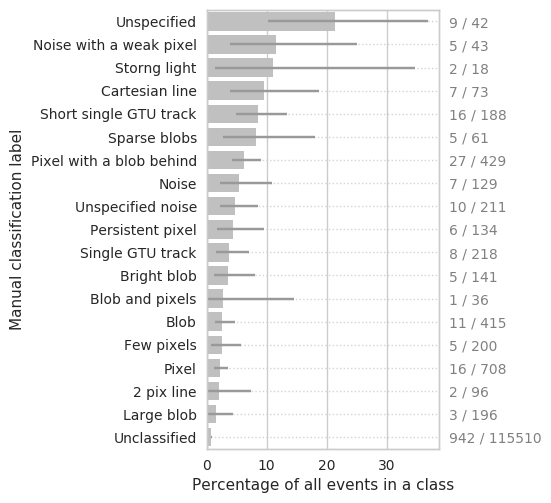

----------------------------------------------------------------------------------------------------
Total num: 4041
Num. predicted 1: 145
Saving ver4_machine_learning_flight_classification_tsne_cfg3_20200415_2_randomforest_gtu_40_overlap_cls20200501/flight_df_gtu_overlap_pack_nonan_flight_data_manual_classification_class_label_normalized_distribution_ver2.svg


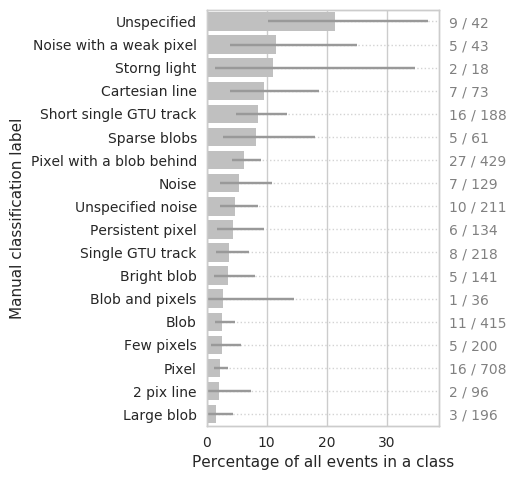

----------------------------------------------------------------------------------------------------


In [160]:
manual_classification_fraction_barplot(
    flight_df_gtu_overlap_pack_nonan, manual_classification_class_number_column, True, 
    'flight_df_gtu_overlap_pack_nonan_flight_data_manual_classification_class_label_normalized_distribution')
manual_classification_fraction_barplot(
    flight_df_gtu_overlap_pack_nonan, manual_classification_class_number_column, False, 
    'flight_df_gtu_overlap_pack_nonan_flight_data_manual_classification_class_label_normalized_distribution')

##### All labeled (flight_df)

Total num: 206428
Num. predicted 1: 2712
Total num unclassified:     201595
Total num not unclassified: 4833
Total num unclassified (pred 1):     2518
Total num not unclassified (pred 1): 194
Saving ver4_machine_learning_flight_classification_tsne_cfg3_20200415_2_randomforest_gtu_40_overlap_cls20200501/flight_df_flight_data_manual_classification_class_label_normalized_distribution_with_unclassified_ver2.svg


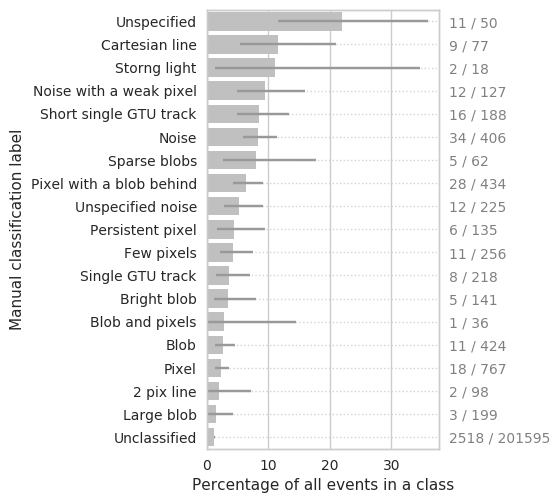

----------------------------------------------------------------------------------------------------
Total num: 4833
Num. predicted 1: 194
Saving ver4_machine_learning_flight_classification_tsne_cfg3_20200415_2_randomforest_gtu_40_overlap_cls20200501/flight_df_flight_data_manual_classification_class_label_normalized_distribution_ver2.svg


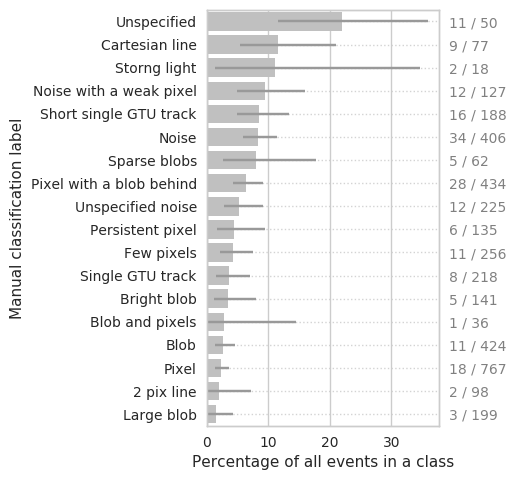

----------------------------------------------------------------------------------------------------


In [161]:
for do_unclassified in [True, False]:
    manual_classification_fraction_barplot(
        flight_df, manual_classification_class_number_column, do_unclassified, 
        'flight_df_flight_data_manual_classification_class_label_normalized_distribution')

##### All labeled in csv
Csv contains state of manual classification at time of the first notebook run???

In [ ]:
# num_classified = np.count_nonzero(
#         flight_df_gtu_overlap_pack_nonan[manual_classification_class_number_column_from_csv] != EVENT_CLASSES['unclassified'])
# print('Num events:', num_classified)
# manual_classification_fraction_barplot(
#     flight_df_gtu_overlap_pack_nonan, manual_classification_class_number_column_from_csv, True, 
#     'flight_df_gtu_overlap_pack_nonan_flight_data_manual_classification_class_{}_label_normalized_distribution'.format(num_classified))
# manual_classification_fraction_barplot(
#     flight_df_gtu_overlap_pack_nonan, manual_classification_class_number_column_from_csv, False, 
#     'flight_df_gtu_overlap_pack_nonan_flight_data_manual_classification_class_{}_label_normalized_distribution'.format(num_classified))

##### All non-train directly from training data dump (gtu overlap pack)

In [ ]:
# EVENT_CLASS_LABLELED_NOISE_FLIGHT = -3
# learning_data_train_labeled_noise_event_id = \
#     learning_data_train['event_id'][learning_data_train['source_class'] == EVENT_CLASS_LABLELED_NOISE_FLIGHT]

# print('Num training set events:', len(learning_data_train_labeled_noise_event_id))

# non_train_mask = \
#     ~flight_df_gtu_overlap_pack_nonan['event_id'].isin(learning_data_train_labeled_noise_event_id)

# num_classified = np.count_nonzero(non_train_mask)

# print('Num events:', num_classified)

# manual_classification_fraction_barplot(
#     flight_df_gtu_overlap_pack_nonan[non_train_mask], manual_classification_class_number_column, True, 
#     'flight_df_gtu_overlap_pack_nonan_flight_data_manual_classification_class_nt_direct_{}_label_normalized_distribution'.format(num_classified))
# manual_classification_fraction_barplot(
#     flight_df_gtu_overlap_pack_nonan[non_train_mask], manual_classification_class_number_column, False, 
#     'flight_df_gtu_overlap_pack_nonan_flight_data_manual_classification_class_nt_direct_{}_label_normalized_distribution'.format(num_classified))

##### All non-train directly from training data dump (flight_df)

In [ ]:
# EVENT_CLASS_LABLELED_NOISE_FLIGHT = -3
# learning_data_train_labeled_noise_event_id = \
#     learning_data_train['event_id'][learning_data_train['source_class'] == EVENT_CLASS_LABLELED_NOISE_FLIGHT]

# print('Num training set events:', len(learning_data_train_labeled_noise_event_id))

# non_train_mask = \
#     ~flight_df['event_id'].isin(learning_data_train_labeled_noise_event_id)

# num_classified = np.count_nonzero(non_train_mask)

# print('Num masked events:', num_classified)

# manual_classification_fraction_barplot(
#     flight_df[non_train_mask], manual_classification_class_number_column, True, 
#     'flight_df_flight_data_manual_classification_class_nt_direct_{}_label_normalized_distribution'.format(num_classified))
# manual_classification_fraction_barplot(
#     flight_df[non_train_mask], manual_classification_class_number_column, False, 
#     'flight_df_flight_data_manual_classification_class_nt_direct_{}_label_normalized_distribution'.format(num_classified))

##### All train directly from learning data dump

In [ ]:
# EVENT_CLASS_LABLELED_NOISE_FLIGHT = -3
# learning_data_train_labeled_noise_event_id = \
#     learning_data_train['event_id'][learning_data_train['source_class'] == EVENT_CLASS_LABLELED_NOISE_FLIGHT]

# print('Num training set events:', len(learning_data_train_labeled_noise_event_id))

# # non negated mask
# train_mask = \
#     flight_df_gtu_overlap_pack_nonan['event_id'].isin(learning_data_train_labeled_noise_event_id)

# num_classified = np.count_nonzero(train_mask)

# print('Num events:', num_classified)

# # manual_classification_fraction_barplot(
# #     flight_df_gtu_overlap_pack_nonan[train_mask], manual_classification_class_number_column, True, 
# #     'flight_df_gtu_overlap_pack_nonan_flight_data_manual_classification_class_tr_direct_{}_label_normalized_distribution'.format(num_classified))
# manual_classification_fraction_barplot(
#     flight_df_gtu_overlap_pack_nonan[train_mask], manual_classification_class_number_column, False, 
#     'flight_df_gtu_overlap_pack_nonan_flight_data_manual_classification_class_tr_direct_{}_label_normalized_distribution'.format(num_classified),
#     print_fractions=True
# )

##### All training directly from learning data dump (flight_df)

In [ ]:
# EVENT_CLASS_LABLELED_NOISE_FLIGHT = -3
# learning_data_train_labeled_noise_event_id = \
#     learning_data_train['event_id'][learning_data_train['source_class'] == EVENT_CLASS_LABLELED_NOISE_FLIGHT]

# print('Num training set events:', len(learning_data_train_labeled_noise_event_id))

# # non negated mask
# train_mask = \
#     flight_df['event_id'].isin(learning_data_train_labeled_noise_event_id)

# num_classified = np.count_nonzero(train_mask)

# print('Num events:', num_classified)

# # manual_classification_fraction_barplot(
# #     flight_df_gtu_overlap_pack_nonan[train_mask], manual_classification_class_number_column, True, 
# #     'flight_df_gtu_overlap_pack_nonan_flight_data_manual_classification_class_tr_direct_{}_label_normalized_distribution'.format(num_classified))
# manual_classification_fraction_barplot(
#     flight_df[train_mask], manual_classification_class_number_column, False, 
#     'flight_df_flight_data_manual_classification_class_train_direct_{}_label_normalized_distribution'.format(num_classified),
#     print_fractions=True
# )

##### All test directly from learning data dump

In [ ]:
# EVENT_CLASS_LABLELED_NOISE_FLIGHT = -3
# learning_data_test_labeled_noise_event_id = \
#     learning_data_test['event_id'][learning_data_test['source_class'] == EVENT_CLASS_LABLELED_NOISE_FLIGHT]

# print('Num training set events:', len(learning_data_test_labeled_noise_event_id))

# # non negated mask
# test_mask = \
#     flight_df_gtu_overlap_pack_nonan['event_id'].isin(learning_data_test_labeled_noise_event_id)

# num_classified = np.count_nonzero(test_mask)

# print('Num events:', num_classified)

# # manual_classification_fraction_barplot(
# #     flight_df_gtu_overlap_pack_nonan[test_mask], manual_classification_class_number_column, True, 
# #     'flight_df_gtu_overlap_pack_nonan_flight_data_manual_classification_class_tr_direct_{}_label_normalized_distribution'.format(num_classified))
# manual_classification_fraction_barplot(
#     flight_df_gtu_overlap_pack_nonan[test_mask], manual_classification_class_number_column, False, 
#     'flight_df_gtu_overlap_pack_nonan_flight_data_manual_classification_class_test_direct_{}_label_normalized_distribution'.format(num_classified),
#     print_fractions=True
# )

##### All test directly from learning data dump (flight_df)

In [ ]:
# EVENT_CLASS_LABLELED_NOISE_FLIGHT = -3
# learning_data_test_labeled_noise_event_id = \
#     learning_data_test['event_id'][learning_data_test['source_class'] == EVENT_CLASS_LABLELED_NOISE_FLIGHT]

# print('Num test set events:', len(learning_data_test_labeled_noise_event_id))

# # non negated mask
# test_mask = \
#     flight_df['event_id'].isin(learning_data_test_labeled_noise_event_id)

# num_classified = np.count_nonzero(test_mask)

# print('Num masked events:', num_classified)

# # manual_classification_fraction_barplot(
# #     flight_df_gtu_overlap_pack_nonan[test_mask], manual_classification_class_number_column, True, 
# #     'flight_df_gtu_overlap_pack_nonan_flight_data_manual_classification_class_tr_direct_{}_label_normalized_distribution'.format(num_classified))
# manual_classification_fraction_barplot(
#     flight_df[test_mask], manual_classification_class_number_column, False, 
#     'flight_df_flight_data_manual_classification_class_test_direct_{}_label_normalized_distribution'.format(num_classified),
#     print_fractions=True
# )

##### Different than original (train/test) csv or unclassified in both

In [ ]:
# non_train_mask = \
#     (flight_df_gtu_overlap_pack_nonan[manual_classification_class_number_column] != 
#      flight_df_gtu_overlap_pack_nonan[manual_classification_class_number_column_from_csv]) \
#     | (
#         (flight_df_gtu_overlap_pack_nonan[manual_classification_class_number_column] == EVENT_CLASSES['unclassified']) &
#         (flight_df_gtu_overlap_pack_nonan[manual_classification_class_number_column_from_csv] == EVENT_CLASSES['unclassified'])
#     )
# #     & (flight_df_gtu_overlap_pack_nonan[manual_classification_class_number_column] != EVENT_CLASSES['unclassified'])

# num_classified = np.count_nonzero(non_train_mask)

# print('Num events:', num_classified)

# manual_classification_fraction_barplot(
#     flight_df_gtu_overlap_pack_nonan[non_train_mask], manual_classification_class_number_column, True, 
#     'flight_df_gtu_overlap_pack_nonan_flight_data_manual_classification_class_nt_{}_label_normalized_distribution'.format(num_classified))
# manual_classification_fraction_barplot(
#     flight_df_gtu_overlap_pack_nonan[non_train_mask], manual_classification_class_number_column, False, 
#     'flight_df_gtu_overlap_pack_nonan_flight_data_manual_classification_class_nt_{}_label_normalized_distribution'.format(num_classified))

#### Reset matplotlib

In [164]:
mpl.rcParams.update(mpl.rcParamsDefault)

### Saving flight data into tsv
(not in the report)

In [165]:
save_flight_data_dump_file = True
overwrite_flight_data_dump_file = False

In [166]:
if save_flight_data_dump_file:
    flight_data_tsv_pathname = os.path.join(data_snippets_dir, 'flight_df_gtu_overlap_pack_nonan_flight_data.tsv.gz')

    if overwrite_flight_data_dump_file or not os.path.exists(flight_data_tsv_pathname):
        print('Saving', flight_data_tsv_pathname)
        flight_df_gtu_overlap_pack_nonan.to_csv(flight_data_tsv_pathname, sep='\t', compression='gzip')
    else:
        print('Already exists', flight_data_tsv_pathname)

Saving ver4_machine_learning_flight_classification_tsne_cfg3_20200415_2_randomforest_gtu_40_overlap_cls20200501/flight_df_gtu_overlap_pack_nonan_flight_data.tsv.gz


In [167]:
for c in flight_df_gtu_overlap_pack_nonan.columns:
    print(c)

source_file_acquisition
packet_id
event_id
timestamp
source_file_acquisition_full
source_file_trigger_full
source_file_trigger
global_gtu
gtu_in_packet
num_gtu
trg_box_per_gtu_max
trg_box_per_gtu_mean
trg_box_per_gtu_mean_gz
trg_pmt_per_gtu_max
trg_pmt_per_gtu_mean
trg_pmt_per_gtu_mean_gz
trg_ec_per_gtu_max
trg_ec_per_gtu_mean
trg_ec_per_gtu_mean_gz
gps_datetime_min
trg_x_y_clusters_sizes_max
trg_x_y_clusters_clu_areas_max
trg_x_y_clusters_max_size_clu_width
trg_x_y_clusters_max_size_clu_height
trg_x_y_clusters_max_peak_clu_width
trg_x_y_clusters_max_peak_clu_height
trg_x_y_clusters_max_peak_clu_size
trg_gtu_x_clusters_max_size_clu_height
trg_gtu_x_clusters_max_peak_clu_width
trg_gtu_x_clusters_max_peak_clu_height
trg_gtu_y_clusters_max_size_clu_height
trg_gtu_y_clusters_max_peak_clu_width
trg_gtu_y_clusters_max_peak_clu_height
orig_x_y_sum
orig_x_y_max
orig_x_y_mean
orig_x_y_mean_gz
proc1_x_y_clusters_sizes_min
proc1_x_y_clusters_sizes_max
proc1_x_y_clusters_clu_areas_max
proc1_x_y_cl

# Visualization of the events

## Visualizing the features

In [ ]:
flight_df_gtu_overlap_pack_nonan[rfecv_selector_on_randomforest__column_names + ['manual_classification_class_number']].head()

### Features used by the model

In [ ]:
len(rfecv_selector_on_randomforest__column_names)

In [ ]:
importances = randomforest_cls_on_train_rfecv_est.feature_importances_
indices = np.argsort(importances)[::-1]


rfecv_selector_on_randomforest__column_names_indices_importances__sorted = \
    sorted(
        [
            (rfecv_selector_on_randomforest__column_names[indices[f]], indices[f], importances[indices[f]]) \
            for f in range(len(rfecv_selector_on_randomforest__column_names)) 
        ], 
        key=lambda e: e[2],
        reverse=True
    )

for column_name, column_indice, column_importance in \
        rfecv_selector_on_randomforest__column_names_indices_importances__sorted:
    print('{:<70}{:.4f}'.format(column_name,column_importance))


rfecv_selector_on_randomforest__column_names__sorted = \
    [e[0] for e in rfecv_selector_on_randomforest__column_names_indices_importances__sorted]

rfecv_selector_on_randomforest__column_indices__sorted = \
    [e[1] for e in rfecv_selector_on_randomforest__column_names_indices_importances__sorted]

### Radvis

Presently not applied optimally, any useful output is not guarateed

In [ ]:
plt.close('all')
sns.set(style="whitegrid")

In [ ]:
# plt.close('all')
# for num_features in range(5,80,20):
#     print('Number of features:\t{}'.format(num_features))
#     f, ax = plt.subplots()
#     f.set_size_inches(20,20)
#     pd.plotting.radviz(
#         flight_df_nonan[rfecv_selector_on_randomforest__column_names__sorted[0:num_features] + ['manual_classification_class_name']], 
#         'manual_classification_class_name', alpha=.8
#     )
#     plt.show()

In [ ]:
mpl.rcParams.update(mpl.rcParamsDefault)

## T-SNE

Using T-SNE computed on flight_df_nonan, visualizing flight_df_gtu_overlap_pack_nonan

In [ ]:
# intentionally commented, to brake the execution here

# %load_ext wurlitzer
# # from sklearn.manifold import TSNE
# import MulticoreTSNE
# from sklearn.externals import joblib

In [ ]:
load_existing_tsne_model = True
refit_tsne_model = False
dump_tsne_embedding = True
show_plots = True

### Fitting

In [ ]:
tsne_hyperparams_dict = dict(
    learning_rate=100,
    n_iter=5000,
    perplexity=50, 
    angle=0.3,
    verbose=10,
    random_state=9621
)

In [ ]:
num_columns_list = list(range(50, len(rfecv_selector_on_randomforest__column_names)+1, 50))

if (len(rfecv_selector_on_randomforest__column_names)-50) % 50 != 0:
    num_columns_list += [len(rfecv_selector_on_randomforest__column_names)]

In [ ]:
num_columns_list

In [ ]:
rfecv_selector_on_randomforest__column_names__sorted

In [ ]:
tsne_hyperparams_dict_md5str = hashlib.md5(';'.join(['{}={}'.format(k,v) for k,v in sorted(tsne_hyperparams_dict.items())]).encode()).hexdigest()

flight_rfecv_columns__X_tsne_dict = {}
tsne_on_flight_nonan_rfecv_columns_X_pathname_dict = {}
tsne_on_flight_nonan_rfecv_columns_divergences_dict = {}
tsne_on_flight_nonan_rfecv_columns_divergences_pathname_dict = {}

for num_columns in num_columns_list:
    
    tsne_on_flight_nonan_rfecv_columns_X_pathname_dict[num_columns] = \
        os.path.join(data_snippets_dir, 'tsne_flight_nonan__cfg_{}__{}_rfecv_columns__X.npy'.format(tsne_hyperparams_dict_md5str, num_columns))
    
    tsne_on_flight_nonan_rfecv_columns_divergences_pathname_dict[num_columns] = \
        os.path.join(data_snippets_dir, 'tsne_flight_nonan__cfg_{}__{}_rfecv_columns__kl_divergence.npy'.format(tsne_hyperparams_dict_md5str, num_columns))
    
    print('Fitting T-SNE of {} features'.format(num_columns))
    print('Pickled file pathname', tsne_on_flight_nonan_rfecv_columns_X_pathname_dict[num_columns])
    
    if refit_tsne_model or not os.path.exists(tsne_on_flight_nonan_rfecv_columns_X_pathname_dict[num_columns]):
        tsne_on_flight_nonan_rfecv_columns = MulticoreTSNE.MulticoreTSNE(**tsne_hyperparams_dict, n_jobs=6)
        flight_rfecv_columns__X_tsne_dict[num_columns] = tsne_on_flight_nonan_rfecv_columns.fit_transform(
            flight_rfecv_columns__X.T[rfecv_selector_on_randomforest__column_indices__sorted[:num_columns+1]].T)
        tsne_on_flight_nonan_rfecv_columns_divergences_dict[num_columns] = tsne_on_flight_nonan_rfecv_columns.kl_divergence_
#         if dump_tsne_model: 
#             joblib.dump(tsne_on_flight_nonan_rfecv_columns, tsne_on_flight_nonan_rfecv_columns_pathname_dict[num_columns], compress=1)
        if dump_tsne_embedding:
            np.save(tsne_on_flight_nonan_rfecv_columns_X_pathname_dict[num_columns], flight_rfecv_columns__X_tsne_dict[num_columns])
            np.save(tsne_on_flight_nonan_rfecv_columns_divergences_pathname_dict[num_columns], tsne_on_flight_nonan_rfecv_columns_divergences_dict[num_columns])
        
    else:
#         tsne_on_flight_nonan_rfecv_columns = joblib.load(tsne_on_flight_nonan_rfecv_columns_pathname_dict[num_columns])
#         flight_rfecv_columns__X_tsne_dict[num_columns] = tsne_on_flight_nonan_rfecv_columns.embedding_
        flight_rfecv_columns__X_tsne_dict[num_columns] = np.load(tsne_on_flight_nonan_rfecv_columns_X_pathname_dict[num_columns])
        tsne_on_flight_nonan_rfecv_columns_divergences_dict[num_columns] = np.load(tsne_on_flight_nonan_rfecv_columns_divergences_pathname_dict[num_columns])

In [ ]:
print(tsne_on_flight_nonan_rfecv_columns_divergences_dict)

In [ ]:
for num_columns, X_tsne in flight_rfecv_columns__X_tsne_dict.items():
    
    x_col_prefix = 'tsne_{}_feat__'.format(num_columns)
    
    flight_df[x_col_prefix + 'X_0'] = np.nan
    flight_df[x_col_prefix + 'X_1'] = np.nan

    flight_df.loc[flight_df['event_id'].isin(flight_df_nonan['event_id']), x_col_prefix + 'X_0'] = flight_rfecv_columns__X_tsne_dict[num_columns][:, 0]
    flight_df.loc[flight_df['event_id'].isin(flight_df_nonan['event_id']), x_col_prefix + 'X_1'] = flight_rfecv_columns__X_tsne_dict[num_columns][:, 1]

# flight_df_nonan = flight_df[~flight_df['had_nan_fields']]

### Updating `flight_df_nonan` with T-SNE dimension values
(not in the report)

In [ ]:
flight_df_nonan = flight_df[~flight_df['had_nan_fields']]

In [ ]:
for num_columns, X_tsne in flight_rfecv_columns__X_tsne_dict.items():
    x_col_prefix = 'tsne_{}_feat__'.format(num_columns)
    flight_df_gtu_overlap_pack[x_col_prefix + 'X_0'] = flight_df.loc[flight_df_gtu_overlap_pack.index][x_col_prefix + 'X_0']
    flight_df_gtu_overlap_pack[x_col_prefix + 'X_1'] = flight_df.loc[flight_df_gtu_overlap_pack.index][x_col_prefix + 'X_1']

In [ ]:
flight_df_gtu_overlap_pack_nonan = flight_df_gtu_overlap_pack[~flight_df_gtu_overlap_pack['had_nan_fields']]

In [ ]:
flight_df_gtu_overlap_pack_nonan.head()

### Visualizing results of T-SNE

In [ ]:
EVENT_CLASSES

#### All classes in a single plot

In [ ]:
# %load_ext autoreload
# %autoreload 2

In [ ]:
import data_analysis_utils

In [ ]:
def check_row_is_randomforest_1(row, cls_column='randomforest_cls_on_train_rfecv_est_dropna'):
    return r[cls_column] == 1

def add_tsne_shower_xy_axes(fig, scatter_plot_ax, df_nonan, annotation_side_frac, annotation_limit=None,
                            highlight_check_func=check_row_is_randomforest_1, highlight_color='red', 
                            event_id_fontsize=8.5, event_id_color='red', cls_column='randomforest_cls_on_train_rfecv_est_dropna', 
                            col_x0='tsne__X_0', col_x1='tsne__X_1', show_event_id=True):
        
    ax_lim_width = (scatter_plot_ax.get_xlim()[1]-scatter_plot_ax.get_xlim()[0])
    annotation_side = annotation_side_frac*ax_lim_width

    shown_images = np.array([[1., 1.]])  # just something big
    
    for _i, (i, r) in enumerate(df_nonan.iterrows()):

        if _i % 10000 == 0:
            print('{}/{}'.format(_i, len(df_nonan)))

        dist = np.sqrt(np.sum(((r[col_x0], r[col_x1]) - shown_images) ** 2, 1))

        if np.min(dist) < annotation_side:
            continue

        shown_images = np.r_[shown_images, [ [r[col_x0], r[col_x1]] ]]

        axes_coords = [ 
            scatter_plot_ax.get_position().x0 + (- scatter_plot_ax.get_xlim()[0] + r[col_x0] - (annotation_side/2) ) * (scatter_plot_ax.get_position().x1 - scatter_plot_ax.get_position().x0)/(scatter_plot_ax.get_xlim()[1]-scatter_plot_ax.get_xlim()[0]) ,
            scatter_plot_ax.get_position().y0 + (- scatter_plot_ax.get_ylim()[0] + r[col_x1] - (annotation_side/2) ) * (scatter_plot_ax.get_position().y1 - scatter_plot_ax.get_position().y0)/(scatter_plot_ax.get_ylim()[1]-scatter_plot_ax.get_ylim()[0]) ,

            annotation_side * (scatter_plot_ax.get_position().x1 - scatter_plot_ax.get_position().x0)/(scatter_plot_ax.get_xlim()[1]-scatter_plot_ax.get_xlim()[0]), 
            annotation_side * (scatter_plot_ax.get_position().y1 - scatter_plot_ax.get_position().y0)/(scatter_plot_ax.get_ylim()[1]-scatter_plot_ax.get_ylim()[0])
        ]

        pax = fig.add_axes(axes_coords)
        if r[cls_column] == 1:
            pax.spines['bottom'].set_color(highlight_color)
            pax.spines['top'].set_color(highlight_color) 
            pax.spines['right'].set_color(highlight_color)
            pax.spines['left'].set_color(highlight_color)
        else:
            pax.set_axis_off()

        pax.set_xticks([])
        pax.set_yticks([])

        data_analysis_utils.visualize_single_event(
            r['source_file_acquisition_full'], 
            r['packet_id'], r['gtu_in_packet'], r['num_gtu'],
            ax_xy=pax, vis_gtux=False, vis_gtuy=False, draw_colorbar=False, 
            xlabel_xy=None, ylabel_xy=None, zlabel_xy=None,
            inverse_means_arr=inverse_means_map
        )
        
        if show_event_id:
            fig.text(
                scatter_plot_ax.get_position().x0 + (- scatter_plot_ax.get_xlim()[0] + r[col_x0] + (annotation_side/2) ) * (scatter_plot_ax.get_position().x1 - scatter_plot_ax.get_position().x0)/(scatter_plot_ax.get_xlim()[1]-scatter_plot_ax.get_xlim()[0]) ,
                scatter_plot_ax.get_position().y0 + (- scatter_plot_ax.get_ylim()[0] + r[col_x1] + (annotation_side/2) ) * (scatter_plot_ax.get_position().y1 - scatter_plot_ax.get_position().y0)/(scatter_plot_ax.get_ylim()[1]-scatter_plot_ax.get_ylim()[0]) ,
                str(r['event_id']),
                fontsize=event_id_fontsize, color=event_id_color, ha='right', va='top', alpha=1
            )

#             print(r['source_file_acquisition_full'], r['packet_id'], r['gtu_in_packet'], r['num_gtu'], r[col_x0], r[col_x1], axes_coords)
#             print('-'*50)

        if annotation_limit is not None and _i > annotation_limit:
            break
        
    # end for

!!! THE FOLLOWING HAS NOT BEEN RUN YET !!!  (old data)

In [ ]:
flight_data_filter_slug = '_gtu_40_overlap'

In [ ]:
# cm = plt.cm.nipy_spectral
# cm = plt.cm.gist_ncar
cm = plt.cm.gist_rainbow
event_classes_for_cm = [v for k, v in EVENT_CLASSES.items() if k != 'unclassified']
cm_norm = mpl.colors.Normalize(min(event_classes_for_cm),max(event_classes_for_cm))
unclassified_class_color = ((0,0,0,1),)
marker_sequence = ['+', 'x', '1', '2', '3', '4']

recreate_plots = False

cls_column = 'randomforest_cls_on_train_rfecv_est_dropna'

for num_columns in num_columns_list:

    print('-'*50)
    print('T-SNE on {} features'.format(num_columns))
    print('-'*50)
    
    num_columns_dirname = 'flight_data{}_feat_{}/all_classes_in_single'.format(flight_data_filter_slug, num_columns)
    
    filename_prefix = 'flight_data{}_feat_{}_'.format(flight_data_filter_slug, num_columns)
    x_col_prefix = 'tsne_{}_feat__'.format(num_columns)
    col_x0 = x_col_prefix + 'X_0'
    col_x1 = x_col_prefix + 'X_1'
    
    os.makedirs(os.path.join(data_snippets_dir, num_columns_dirname), exist_ok=True)
    
    for size_inches, do_unclassified, show_in_notebook, known_class_alpha, unclassified_class_alpha, scatter_s, \
        show_annotations, annotation_side_frac, show_event_id, annotation_limit, savefig_pathname  in (
            
            ((20,20), True, show_plots, 0.7, .02, 10,
             False, 0.02, False, None, 
             os.path.join(data_snippets_dir, num_columns_dirname, filename_prefix + 'tsne_20inch.png')),

            ((20,20), True, show_plots, 0.7, .02, 10,
             True, 0.02, False, None, 
             os.path.join(data_snippets_dir, num_columns_dirname, filename_prefix + 'tsne_annot_20inch.png')),

            ((40,40), True, False, 0.7, .02, 60,
             False, 0.02, True, None, 
             os.path.join(data_snippets_dir, num_columns_dirname, filename_prefix + 'tsne_40inch.png')),

            ((40,40), True, False, 0.7, .02, 60,
             True, 0.02, True, None, 
             os.path.join(data_snippets_dir, num_columns_dirname, filename_prefix + 'tsne_annot_40inch.png')),

            # following configuration is computationally demanding    
#             ((200,200), True, False, 0.8, .1, 80,
#              True, 0.006, True, None, 
#              os.path.join(data_snippets_dir, num_columns_dirname, filename_prefix + 'tsne_annot_200inch.png')),
    ):
        
        print('Size: {}, Pathname: {}'.format(str(size_inches), str(savefig_pathname)))
        
        if savefig_pathname is not None and os.path.exists(savefig_pathname) and not show_in_notebook and not recreate_plots:
            print('Already exists:', savefig_pathname)
            continue
        
        plt.close('all')
        
        f, ax = plt.subplots()
        f.set_size_inches(*size_inches)

        tsne_scatter_labels_dict = {}
        tsne_scatter_labels = []
        tsne_scatter_pathcolls = []

        for ii, (class_name, class_number) in enumerate(sorted(EVENT_CLASSES.items(),key=lambda x: x[1])):
            if class_name == 'unclassified' and not do_unclassified:
                continue

            flight_df_nonan_subset = flight_df_gtu_overlap_pack_nonan[flight_df_gtu_overlap_pack_nonan['manual_classification_class_number']==class_number]

            if len(flight_df_nonan_subset) <= 0:
                continue

            if class_name == 'unclassified':
                class_color = unclassified_class_color
                event_class_alpha = unclassified_class_alpha
            else:
                class_color = [cm(cm_norm(class_number))]
                event_class_alpha = known_class_alpha
            
            for classification_class_num, classification_class_name, subset_marker in (
                (1, 'shower est.', 'o'), (0, 'noise est.', marker_sequence[ii % len(marker_sequence)])
            ):
                flight_df_nonan_subsubset = flight_df_nonan_subset[flight_df_nonan_subset[cls_column] == classification_class_num]
                
                pathcoll = ax.scatter(
                    flight_df_nonan_subsubset[col_x0], 
                    flight_df_nonan_subsubset[col_x1], 
                    c=class_color, 
                    s=80, linewidths=0,
                    alpha=event_class_alpha,
                    marker=subset_marker
                )
                
                pathcoll_for_legend = mpl.lines.Line2D(range(1),range(1), 
                                                       color=class_color[0], markersize=10, marker=subset_marker,
                                                       linewidth=1,  linestyle='none')
                
                tsne_scatter_labels_dict[pathcoll_for_legend] = \
                    (len(flight_df_nonan_subset), '{} ({})'.format(class_name, classification_class_name))
                
#                 print('> Adding to dict tsne_scatter_labels_dict, new len =', len(tsne_scatter_labels_dict), '{}{}{}{}{}'.format(class_color, scatter_s, subset_marker, 0, 'none'))
#                 tsne_scatter_labels.append('{} ({})'.format(class_name, classification_class_name))
#                 tsne_scatter_pathcolls.append(pathcoll_for_legend)

        if show_annotations:
            add_tsne_shower_xy_axes(
                f, ax, flight_df_gtu_overlap_pack_nonan, annotation_side_frac, 
                annotation_limit=annotation_limit, col_x0=col_x0, col_x1=col_x1, show_event_id=show_event_id)

#         ax.legend(tsne_scatter_pathcolls, tsne_scatter_labels)

        if savefig_pathname is not None:
            print('Saving figure: {}'.format(savefig_pathname))
            f.savefig(savefig_pathname)

        if show_in_notebook:    
            plt.show()
                
        tsne_scatter_labels_dict = collections.OrderedDict(sorted(tsne_scatter_labels_dict.items(), key=lambda x: x[1][0], reverse=True))

        f, ax = plt.subplots()
        f.set_size_inches(15,6)

        ax.legend(tsne_scatter_labels_dict.keys(), [v[1] for v in tsne_scatter_labels_dict.values()], 
                  loc='center', fontsize='large', mode='expand', ncol=3)
        ax.set_axis_off()
            
        if savefig_pathname is not None:
            
            savefig_legend_pathname = os.path.splitext(savefig_pathname)[0] + '_legend.svg'
            
            print('Saving figure: {}'.format(savefig_legend_pathname))
            f.savefig(savefig_legend_pathname)
        
        if show_in_notebook:    
            plt.show()
            

# flight_nonan__rfecv_columns_scaled_X__tsne

#### Unclassified and a single class

In [ ]:
cm = plt.cm.gist_rainbow
event_classes_for_cm = [v for k, v in EVENT_CLASSES.items() if k != 'unclassified']
cm_norm = mpl.colors.Normalize(min(event_classes_for_cm),max(event_classes_for_cm))
unclassified_class_color = 'black'
single_class_event_class_alpha_dict = {'unclassified': .005}
single_class_event_class_alpha_default = 1

flight_df_nonan_subset_unclassified = flight_df_gtu_overlap_pack_nonan[flight_df_gtu_overlap_pack_nonan['manual_classification_class_number']==EVENT_CLASSES['unclassified']]

cls_column = 'randomforest_cls_on_train_rfecv_est_dropna'

num_columns_shown_in_notebook =  [False] * len(num_columns_list)
num_columns_shown_in_notebook[0] = num_columns_shown_in_notebook[-1] = show_plots

recreate_plots = True

fig_dpi = 150
fig_size = (8,8)

for num_columns, show_in_notebook in zip(num_columns_list, num_columns_shown_in_notebook):

    filename_prefix = 'flight_data{}_feat_{}_'.format(flight_data_filter_slug, num_columns)
    x_col_prefix = 'tsne_{}_feat__'.format(num_columns)
    col_x0 = x_col_prefix + 'X_0'
    col_x1 = x_col_prefix + 'X_1'
    
    num_columns_dirname = 'flight_data{}_feat_{}/by_single_class'.format(flight_data_filter_slug, num_columns)
    os.makedirs(os.path.join(data_snippets_dir, num_columns_dirname), exist_ok=True)
    
    print('-'*50)
    print('T-SNE on {} features'.format(num_columns))
    print('-'*50)

    for class_name, class_number in sorted(EVENT_CLASSES.items(),key=lambda x: x[1]):

        if class_name == 'unclassified':
            continue

        flight_df_nonan_subset = flight_df_gtu_overlap_pack_nonan[flight_df_gtu_overlap_pack_nonan['manual_classification_class_number']==class_number]

        if len(flight_df_nonan_subset) <= 0:
            continue
            
        savefig_pathname = os.path.join(data_snippets_dir, num_columns_dirname, filename_prefix + 'tsne_{}.png'.format(class_name))

        print('-'*30)
        print(class_name)
        print(savefig_pathname)
        print('-'*30)

        if os.path.exists(savefig_pathname) and not show_in_notebook and not recreate_plots:
            print('Already exists', savefig_pathname)
            continue

        plt.close('all')
        
        f, ax = plt.subplots()
        f.set_size_inches(fig_size)

        tsne_scatter_labels = []
        tsne_scatter_pathcolls = []

        for t_class_name, t_class_number, t_class_color, subset_df in (
                ('unclassified', EVENT_CLASSES['unclassified'], unclassified_class_color, flight_df_nonan_subset_unclassified), 
                (class_name, class_number, cm(cm_norm(class_number)), flight_df_nonan_subset)
        ):

            if t_class_name in single_class_event_class_alpha_dict:
                event_class_alpha = single_class_event_class_alpha_dict[t_class_name]
            else:
                event_class_alpha = single_class_event_class_alpha_default

            t_class_color_l = (t_class_color, )
                
            for classification_class_num, classification_class_name, subset_marker in (
                (1, 'shower est.', 'o'), (0, 'noise est.', 'x')
            ):
                subsubset_df = subset_df[subset_df[cls_column]==classification_class_num]
                pathcoll = ax.scatter(
                    subsubset_df[col_x0], 
                    subsubset_df[col_x1], 
                    c=t_class_color_l, 
                    s=80, linewidths=0,
                    alpha=event_class_alpha,
                    marker=subset_marker
                )

                pathcoll_for_legend = mpl.lines.Line2D(range(1),range(1), 
                                                       color=t_class_color, markersize=10, marker=subset_marker,
                                                       linewidth=1,  linestyle='none')
                
                tsne_scatter_labels.append('{} ({})'.format(t_class_name, classification_class_name))
                tsne_scatter_pathcolls.append(pathcoll_for_legend)

        ax.legend(tsne_scatter_pathcolls, tsne_scatter_labels)
        
        if savefig_pathname is not None:
            print('Saving figure: {}'.format(savefig_pathname))
            f.savefig(savefig_pathname, dpi=fig_dpi)
        
        if show_in_notebook:
            plt.show()

# flight_nonan__rfecv_columns_scaled_X__tsne

### T-SNE Data after classification

In [ ]:
cls_column = 'randomforest_cls_on_train_rfecv_est_dropna'

cm = plt.cm.coolwarm
event_classes_for_cm = [flight_df_gtu_overlap_pack_nonan[cls_column].min(), flight_df_gtu_overlap_pack_nonan[cls_column].max()]
cm_norm = mpl.colors.Normalize(min(event_classes_for_cm),max(event_classes_for_cm))
# unclassified_class_color = 'black'
unclassified_class_marker='x'
known_class_marker_fallback = 'o'

num_columns_shown_in_notebook =  [False] * len(num_columns_list)
num_columns_shown_in_notebook[0] = num_columns_shown_in_notebook[-1] = show_plots

# cls_column
# cls_proba_column

recreate_plots = False

fig_dpi = 150

for num_columns, show_in_notebook in zip(num_columns_list, num_columns_shown_in_notebook):

    filename_prefix = 'flight_data{}_feat_{}_'.format(flight_data_filter_slug, num_columns)
    x_col_prefix = 'tsne_{}_feat__'.format(num_columns)
    col_x0 = x_col_prefix + 'X_0'
    col_x1 = x_col_prefix + 'X_1'
    
    num_columns_dirname = 'flight_data{}_feat_{}/by_classification_result'.format(flight_data_filter_slug, num_columns)
    os.makedirs(os.path.join(data_snippets_dir, num_columns_dirname), exist_ok=True)
    
    print('-'*50)
    print('T-SNE on {} features'.format(num_columns))
    print('-'*50)

    for size_inches, show_in_notebook, proba_limit, known_class_alpha, unclassified_class_alpha, print_counts, \
        always_cross_marker, show_annotations, annotation_side_frac, show_event_id, annotation_limit, savefig_pathname  in (
            ((8, 8), show_in_notebook, .5, (0.01, 0.1), (0.01, 0.1), True, 
             True, False, 0.02, False, None, 
             os.path.join(data_snippets_dir, num_columns_dirname, filename_prefix + 'proba05_tsne_low_intensity_shower_8_inches.png')),
            ((8, 8), show_in_notebook, .7, (0.05, 0.5), (0.01, 0.5), True, 
             True, False, 0.02, False, None, 
             os.path.join(data_snippets_dir, num_columns_dirname, filename_prefix + 'proba07_tsne_low_intensity_shower_8_inches.png')),
            ((8, 8), show_in_notebook, .8, (0.01, 1), (0.01, 1), True, 
             True, False, 0.02, False, None, 
             os.path.join(data_snippets_dir, num_columns_dirname, filename_prefix + 'proba08_tsne_low_intensity_shower_8_inches.png')),
#             ((15, 15), show_in_notebook, (0.5, 0.7), (0.01, 0.3), False, 
#              False, 0.02, False, None, 
#              os.path.join(data_snippets_dir, num_columns_dirname, filename_prefix + 'tsne_high_intensity_shower_15_inches.png')),
#             ((20, 20), show_in_notebook, (0.5, 0.7), (0.01, 0.3), False, 
#              True, 0.02, False, None, 
#              os.path.join(data_snippets_dir, num_columns_dirname, filename_prefix + 'tsne_annot_20_inches.png')),
            ((40, 40), False, .5, (0.6, 0.7), (0.05, 0.6), False, 
             False, False, 0.02, True, None, 
             os.path.join(data_snippets_dir, num_columns_dirname, filename_prefix + 'tsne_40_inches.png')),
            ((40, 40), False, .7, (0.6, 0.7), (0.05, 0.6), False, 
             False, False, 0.02, True, None, 
             os.path.join(data_snippets_dir, num_columns_dirname, filename_prefix + 'proba07_tsne_40_inches.png')),
            ((40, 40), False, .8, (0.6, 0.7), (0.05, 0.6), False, 
             False, True, 0.02, True, None, 
             os.path.join(data_snippets_dir, num_columns_dirname, filename_prefix + 'proba08_tsne_annot_40_inches.png')),
#     #       following configuration is computationally and I/O  demanding    
#             ((200,200), False, .7, (0.8, 1), (0.1, 0.8), False, 
#              False, True, 0.006, True, None, 
#              os.path.join(data_snippets_dir, num_columns_dirname, filename_prefix + 'proba07_tsne_annot_200_inches.png')),
    ):
        
        print('Size: {}, show annotations: {}'.format(str(size_inches), str(show_annotations)))
        
        if savefig_pathname is not None and os.path.exists(savefig_pathname) and not show_in_notebook and not recreate_plots:
            print('Already exists:', savefig_pathname)
            continue
        
        plt.close('all')
        
        f, ax = plt.subplots()
        f.set_size_inches(*size_inches)

#         tsne_scatter_labels = []
#         tsne_scatter_pathcolls = []
        tsne_scatter_labels_dict = {}

        for class_name, class_number in sorted(EVENT_CLASSES.items(),key=lambda x: x[1]):
            if print_counts:
                print('Class: {}'.format(class_name))

            for cls_est_value in event_classes_for_cm:

                flight_df_nonan_subset = flight_df_gtu_overlap_pack_nonan[
                    (flight_df_gtu_overlap_pack_nonan['manual_classification_class_number']==class_number) & \
                    (flight_df_gtu_overlap_pack_nonan[cls_column]==cls_est_value)
                ]
                
                if cls_est_value == 1 and proba_limit is not None:
                    flight_df_nonan_subset = flight_df_nonan_subset[flight_df_nonan_subset[cls_proba_column] > proba_limit]
                
                if print_counts:
                    print('  classified {}: {} events'.format(
                        'shower' if cls_est_value == 1 else 'noise', 
                        len(flight_df_nonan_subset)))

                if len(flight_df_nonan_subset) <= 0:
                    continue

                if class_name == 'unclassified':
                    event_class_alpha = unclassified_class_alpha[cls_est_value]
                    class_marker = unclassified_class_marker
                else:
                    if always_cross_marker:
                        class_marker = known_class_marker_fallback
                    else:
                        class_marker = '${}$'.format(class_number)
                        
                    event_class_alpha = known_class_alpha[cls_est_value]

                class_color = cm(cm_norm(cls_est_value))

                pathcoll = ax.scatter(
                    flight_df_nonan_subset[col_x0], 
                    flight_df_nonan_subset[col_x1], 
                    c=[class_color], 
                    s=80, linewidths=0,
                    alpha=event_class_alpha,
                    marker=class_marker
                )

                pathcoll_for_legend = mpl.lines.Line2D(range(1),range(1), 
                                                       color=class_color, markersize=10, marker=class_marker,
                                                       linewidth=1,  linestyle='none')
                
                tsne_scatter_labels_dict[pathcoll_for_legend] = \
                    (len(flight_df_nonan_subset), '{} ({}: {})'.format(
                    class_name, 
                    'air shower' if cls_est_value==1 else 'noise',
                     len(flight_df_nonan_subset)
                ))
                
        if show_annotations:
            add_tsne_shower_xy_axes(
                f, ax, 
                flight_df_gtu_overlap_pack_nonan[flight_df_gtu_overlap_pack_nonan[cls_column]==1], 
                annotation_side_frac, annotation_limit=annotation_limit, col_x0=col_x0, col_x1=col_x1, show_event_id=show_event_id)

        
        ax.legend(
            [mpl.lines.Line2D(range(1),range(1), 
                              color=cm(cm_norm(cls_est_value)), 
                              markersize=10, marker=unclassified_class_marker,
                              linewidth=1,  linestyle='none') \
                   for cls_est_value in event_classes_for_cm],
            ['noise prediction', 'air shower prediction',], fontsize='large', 
        #    loc='center', mode='expand', ncol=3
        )
            
        if savefig_pathname is not None:
            print('Saving figure: {}'.format(savefig_pathname))
            f.savefig(savefig_pathname, dpi=fig_dpi)

        if show_in_notebook:
            plt.show()
        
        tsne_scatter_labels_dict = collections.OrderedDict(sorted(tsne_scatter_labels_dict.items(), key=lambda x: x[1][0], reverse=True))

        f, ax = plt.subplots()
        f.set_size_inches(15,6)

        ax.legend(tsne_scatter_labels_dict.keys(), [v[1] for v in tsne_scatter_labels_dict.values()], 
                  loc='center', fontsize='large', mode='expand', ncol=3)
        ax.set_axis_off()
            
        if savefig_pathname is not None:
            
            savefig_legend_pathname = os.path.splitext(savefig_pathname)[0] + '_legend.svg'
            
            print('Saving figure: {}'.format(savefig_legend_pathname))
            f.savefig(savefig_legend_pathname, dpi=fig_dpi)
        
        if show_in_notebook:    
            plt.show()
    
# flight_nonan__rfecv_columns_scaled_X__tsne

In [ ]:
cls_column = 'randomforest_cls_on_train_rfecv_est_dropna'

cm = plt.cm.coolwarm
event_classes_for_cm = [flight_df_gtu_overlap_pack_nonan[cls_column].min(), flight_df_gtu_overlap_pack_nonan[cls_column].max()]
cm_norm = mpl.colors.Normalize(min(event_classes_for_cm),max(event_classes_for_cm))
# unclassified_class_color = 'black'
unclassified_class_marker='x'

num_columns_shown_in_notebook =  [False] * len(num_columns_list)
num_columns_shown_in_notebook[0] = num_columns_shown_in_notebook[-1] = show_plots

recreate_plots = False

fig_dpi = 150

for num_columns, show_in_notebook in zip(num_columns_list, num_columns_shown_in_notebook):

    filename_prefix = 'flight_data{}_feat_{}_'.format(flight_data_filter_slug, num_columns)
    x_col_prefix = 'tsne_{}_feat__'.format(num_columns)
    col_x0 = x_col_prefix + 'X_0'
    col_x1 = x_col_prefix + 'X_1'
    
    num_columns_dirname = 'flight_data{}_feat_{}/by_classification_result'.format(flight_data_filter_slug, num_columns)
    os.makedirs(os.path.join(data_snippets_dir, num_columns_dirname), exist_ok=True)
    
    print('-'*50)
    print('T-SNE on {} features'.format(num_columns))
    print('-'*50)

    for size_inches, show_in_notebook, known_class_alpha, unclassified_class_alpha, print_counts, \
        show_annotations, annotation_side_frac, show_event_id, annotation_limit, savefig_pathname  in (
            ((15, 15), show_in_notebook, (0.5, 0.7), (0.01, 0.06), True, 
             False, 0.02, False, None, 
             os.path.join(data_snippets_dir, num_columns_dirname, filename_prefix + 'tsne_low_intensity_shower_15_inches.png')),
            ((15, 15), show_in_notebook, (0.5, 0.7), (0.01, 0.3), False, 
             False, 0.02, False, None, 
             os.path.join(data_snippets_dir, num_columns_dirname, filename_prefix + 'tsne_high_intensity_shower_15_inches.png')),
            ((20, 20), show_in_notebook, (0.5, 0.7), (0.01, 0.3), False, 
             True, 0.02, False, None, 
             os.path.join(data_snippets_dir, num_columns_dirname, filename_prefix + 'tsne_annot_20_inches.png')),
            ((40, 40), False, (0.6, 0.7), (0.05, 0.6), False, 
             False, 0.02, True, None, 
             os.path.join(data_snippets_dir, num_columns_dirname, filename_prefix + 'tsne_40_inches.png')),
            ((40, 40), False, (0.6, 0.7), (0.05, 0.6), False, 
             True, 0.02, True, None, 
             os.path.join(data_snippets_dir, num_columns_dirname, filename_prefix + 'tsne_annot_40_inches.png')),
    #       following configuration is computationally and I/O  demanding    
#             ((200,200),  False, (0.8, 1), (0.1, 0.8), False, 
#              True, 0.006, True, None, 
#              os.path.join(data_snippets_dir, num_columns_dirname, filename_prefix + 'tsne_annot_200_inches.png')),
    ):
        
        print('Size: {}, show annotations: {}'.format(str(size_inches), str(show_annotations)))
        
        if savefig_pathname is not None and os.path.exists(savefig_pathname) and not show_in_notebook and not recreate_plots:
            print('Already exists:', savefig_pathname)
            continue
        
        plt.close('all')
        
        f, ax = plt.subplots()
        f.set_size_inches(*size_inches)

#         tsne_scatter_labels = []
#         tsne_scatter_pathcolls = []
        tsne_scatter_labels_dict = {}

        for class_name, class_number in sorted(EVENT_CLASSES.items(),key=lambda x: x[1]):
            if print_counts:
                print('Class: {}'.format(class_name))

            for cls_est_value in event_classes_for_cm:

                flight_df_nonan_subset = flight_df_gtu_overlap_pack_nonan[
                    (flight_df_gtu_overlap_pack_nonan['manual_classification_class_number']==class_number) & \
                    (flight_df_gtu_overlap_pack_nonan[cls_column]==cls_est_value)
                ]

                if print_counts:
                    print('  classified {}: {} events'.format(
                        'shower' if cls_est_value == 1 else 'noise', 
                        len(flight_df_nonan_subset)))

                if len(flight_df_nonan_subset) <= 0:
                    continue

                if class_name == 'unclassified':
                    event_class_alpha = unclassified_class_alpha[cls_est_value]
                    class_marker = unclassified_class_marker
                else:
                    event_class_alpha = known_class_alpha[cls_est_value]
                    class_marker = '${}$'.format(class_number)

                class_color = cm(cm_norm(cls_est_value))

                pathcoll = ax.scatter(
                    flight_df_nonan_subset[col_x0], 
                    flight_df_nonan_subset[col_x1], 
                    c=[class_color], 
                    s=80, linewidths=0,
                    alpha=event_class_alpha,
                    marker=class_marker
                )

                pathcoll_for_legend = mpl.lines.Line2D(range(1),range(1), 
                                                       color=class_color, markersize=10, marker=class_marker,
                                                       linewidth=1,  linestyle='none')
                
                tsne_scatter_labels_dict[pathcoll_for_legend] = \
                    (len(flight_df_nonan_subset), '{} ({}: {})'.format(
                    class_name, 
                    'air shower' if cls_est_value==1 else 'noise',
                     len(flight_df_nonan_subset)
                ))
                
        if show_annotations:
            add_tsne_shower_xy_axes(
                f, ax, 
                flight_df_gtu_overlap_pack_nonan[flight_df_gtu_overlap_pack_nonan[cls_column]==1], 
                annotation_side_frac, annotation_limit=annotation_limit, col_x0=col_x0, col_x1=col_x1, show_event_id=show_event_id)

        
        ax.legend(
            [mpl.lines.Line2D(range(1),range(1), 
                              color=cm(cm_norm(cls_est_value)), 
                              markersize=10, marker=unclassified_class_marker,
                              linewidth=1,  linestyle='none') \
                   for cls_est_value in event_classes_for_cm],
            ['noise prediction', 'air shower prediction',], fontsize='large', 
        #    loc='center', mode='expand', ncol=3
        )
            
        if savefig_pathname is not None:
            print('Saving figure: {}'.format(savefig_pathname))
            f.savefig(savefig_pathname, dpi=fig_dpi)

        if show_in_notebook:
            plt.show()
        
        tsne_scatter_labels_dict = collections.OrderedDict(sorted(tsne_scatter_labels_dict.items(), key=lambda x: x[1][0], reverse=True))

        f, ax = plt.subplots()
        f.set_size_inches(15,6)

        ax.legend(tsne_scatter_labels_dict.keys(), [v[1] for v in tsne_scatter_labels_dict.values()], 
                  loc='center', fontsize='large', mode='expand', ncol=3)
        ax.set_axis_off()
            
        if savefig_pathname is not None:
            
            savefig_legend_pathname = os.path.splitext(savefig_pathname)[0] + '_legend.svg'
            
            print('Saving figure: {}'.format(savefig_legend_pathname))
            f.savefig(savefig_legend_pathname, dpi=fig_dpi)
        
        if show_in_notebook:    
            plt.show()
    
# flight_nonan__rfecv_columns_scaled_X__tsne

## Clustering T-SNE data

In [ ]:
import sklearn.cluster
# from sklearn import cluster, datasets, mixture

In [ ]:
def davies_bouldin_score(X, labels):
    from sklearn.preprocessing import LabelEncoder
    from sklearn.utils import safe_indexing, check_X_y
    from sklearn.metrics.cluster.unsupervised import check_number_of_labels
    from sklearn.metrics.pairwise import pairwise_distances
    # form 0.20
    X, labels = check_X_y(X, labels)
    le = LabelEncoder()
    labels = le.fit_transform(labels)
    n_samples, _ = X.shape
    n_labels = len(le.classes_)
    check_number_of_labels(n_labels, n_samples)

    intra_dists = np.zeros(n_labels)
    centroids = np.zeros((n_labels, len(X[0])), dtype=np.float)
    for k in range(n_labels):
        cluster_k = safe_indexing(X, labels == k)
        centroid = cluster_k.mean(axis=0)
        centroids[k] = centroid
        intra_dists[k] = np.average(pairwise_distances(
            cluster_k, [centroid]))

    centroid_distances = pairwise_distances(centroids)

    if np.allclose(intra_dists, 0) or np.allclose(centroid_distances, 0):
        return 0.0

    score = (intra_dists[:, None] + intra_dists) / centroid_distances
    score[score == np.inf] = np.nan
    return np.mean(np.nanmax(score, axis=1))


### DBSCAN clustering

#### Comparison of different scoring methods in relation to EPS

In [ ]:
# eps_list = []
# eps_num_clusters_list = []
# silhouette_score_list = []
# calinski_harabaz_score_list = []
# davies_bouldin_score_list = []

# for eps_v in np.arange(1-0.4,3.4,0.1):
#     print(eps_v)
#     eps_list.append(eps_v)
#     dbscan_on_tsne = sklearn.cluster.DBSCAN(eps=eps_v, algorithm='ball_tree')
#     flight_nonan__tsne__dbscan_y_pred = dbscan_on_tsne.fit_predict(flight_df_nonan[[col_x0,col_x1]].values)
    
#     eps_num_clusters_list.append(len(np.unique(flight_nonan__tsne__dbscan_y_pred)))
    
#     print(' > len(clusters) =', eps_num_clusters_list[-1])

#     silhouette_score_list.append(
#         sklearn.metrics.silhouette_score(flight_df_nonan[[col_x0,col_x1]].values, flight_nonan__tsne__dbscan_y_pred, sample_size=10000)
#     )
#     print(' > silhouette_score =', silhouette_score_list[-1])
#     calinski_harabaz_score_list.append(
#         sklearn.metrics.calinski_harabaz_score(flight_df_nonan[[col_x0,col_x1]].values, flight_nonan__tsne__dbscan_y_pred)
#     )
#     print(' > calinski_harabaz_score =', calinski_harabaz_score_list[-1])
#     davies_bouldin_score_list.append(
#         davies_bouldin_score(flight_df_nonan[[col_x0,col_x1]].values, flight_nonan__tsne__dbscan_y_pred)
#     )
#     print(' > davies_bouldin_score = ', davies_bouldin_score_list[-1])

In [ ]:
# fig, axs = plt.subplots(2,1, sharex=True, constrained_layout=True)
# fig.set_size_inches(10,4*2)
# axs[0].plot(eps_list, eps_num_clusters_list, label='Cluster size')
# axs[0].legend()
# axs[0].set_ylabel('Cluster size')
# axs[1].plot(eps_list, (np.array(silhouette_score_list)-np.min(silhouette_score_list))/(np.max(silhouette_score_list)-np.min(silhouette_score_list)), label='silhouette_score_list')  
# axs[1].plot(eps_list, (np.array(calinski_harabaz_score_list)-np.min(calinski_harabaz_score_list))/(np.max(calinski_harabaz_score_list)-np.min(calinski_harabaz_score_list)), label='calinski_harabaz_score_list')  
# axs[1].plot(eps_list, (np.array(davies_bouldin_score_list)-np.min(davies_bouldin_score_list))/(np.max(davies_bouldin_score_list)-np.min(davies_bouldin_score_list)), label='davies_bouldin_score_list')  
# axs[1].set_ylabel('Normalized score')
# axs[1].set_xlabel('EPS')
# axs[1].legend()
# plt.show()

#### Optimization to find an optimal EPS according to the scoring method

The scoring method mught not be optimal, the goal was to make it more systematic than a guessed value.

In [ ]:
# from scipy.optimize import minimize as sp_opt_minimize
# from scipy.optimize import minimize_scalar as sp_opt_minimize_scalar

In [ ]:
# def cluster_data_fun(eps_v, vals_arr):
#     dbscan_on_tsne = sklearn.cluster.DBSCAN(eps=eps_v, algorithm='ball_tree')
#     pred_arr = dbscan_on_tsne.fit_predict(vals_arr)
    
#     calinski_harabaz_score = \
#         sklearn.metrics.calinski_harabaz_score(vals_arr, pred_arr)
    
# #     print('eps_v =', eps_v, 'calinski_harabaz_score=', calinski_harabaz_score)
    
#     return 1/calinski_harabaz_score

In [ ]:
# rerun_dbcan_eps_optimization = False

In [ ]:
# dbscan_eps_dict_plk_pathname = os.path.join(data_snippets_dir, 'dbscan_eps_dict.pkl')
# optimzer_minimize_bonds = (0.5, 5.5)
 
# _dbscan_eps_dict_plk_pathname_exists = os.path.exists(dbscan_eps_dict_plk_pathname)

dbscan_eps_dict = {}

# for now using constatnt eps value, optimization was not satisfactory

for num_columns in num_columns_list:
    dbscan_eps_dict[num_columns] = 1.9

# if not rerun_dbcan_eps_optimization and _dbscan_eps_dict_plk_pathname_exists:
#     print('Loading:', dbscan_eps_dict_plk_pathname)
#     dbscan_eps_dict = joblib.load(dbscan_eps_dict_plk_pathname)

# if rerun_dbcan_eps_optimization or not _dbscan_eps_dict_plk_pathname_exists \
#         or np.any([not (n in dbscan_eps_dict) for n in num_columns_list]): 
    
#     for num_columns in num_columns_list:

#         print('-'*50)
#         print('T-SNE on {} features'.format(num_columns))
#         print('-'*50)
    
#         if not rerun_dbcan_eps_optimization and num_columns in dbscan_eps_dict:
#             print('Already available:', dbscan_eps_dict[num_columns])
#             continue
        
#         col_prefix = 'tsne_{}_feat__'.format(num_columns)
#         col_x0 = col_prefix + 'X_0'
#         col_x1 = col_prefix + 'X_1'
#         col_dbscan_y = col_prefix + 'dbscan_y'

#         # opt_res = sp_opt_minimize(cluster_data_fun, 1.6, args=(flight_df_nonan[[col_x0,col_x1]].values),
#         #                           bounds=[(0.5, 10)], method='Nelder-Mead')

#         opt_res = sp_opt_minimize_scalar(cluster_data_fun, args=(flight_df_nonan[[col_x0,col_x1]].values), 
#                                          bounds=optimzer_minimize_bonds, method='bounded', options=dict(maxiter=50))
  
#         print('x: {}; success: {}; status: {}; message: {}'.format(
#             opt_res.x, opt_res.success, opt_res.status, opt_res.message))
        
#         dbscan_eps_dict[num_columns] = opt_res.x
    
#     print('Saving:', dbscan_eps_dict_plk_pathname)
    
#     joblib.dump(dbscan_eps_dict, dbscan_eps_dict_plk_pathname)

for num_columns in num_columns_list:
    
    print('-'*50)
    print('T-SNE on {} features'.format(num_columns))
    print('-'*50)
    
    col_prefix = 'tsne_{}_feat__'.format(num_columns)
    col_x0 = col_prefix + 'X_0'
    col_x1 = col_prefix + 'X_1'
    col_dbscan_y = col_prefix + 'dbscan_y'
    
    eps_value = dbscan_eps_dict[num_columns]
        
    dbscan_on_tsne = sklearn.cluster.DBSCAN(eps=eps_value, algorithm='ball_tree')
    flight_nonan__tsne__dbscan_y_pred = dbscan_on_tsne.fit_predict(flight_df_gtu_overlap_pack_nonan[[col_x0,col_x1]].values)
    
    flight_df_gtu_overlap_pack[col_dbscan_y] = np.nan
    flight_df_gtu_overlap_pack.loc[flight_df_gtu_overlap_pack['event_id'].isin(flight_df_gtu_overlap_pack_nonan['event_id']), col_dbscan_y] = flight_nonan__tsne__dbscan_y_pred
    
    dbscan_on_tsne_classes = np.unique(flight_nonan__tsne__dbscan_y_pred)

    print('EPS:', eps_value)
    print('Number of clusters:', len(dbscan_on_tsne_classes))

#### Updating `flight_df_gtu_overlap_pack_nonan` with cluster numbers
(not in the report)

In [ ]:
flight_df_gtu_overlap_pack_nonan = flight_df_gtu_overlap_pack[~flight_df_gtu_overlap_pack['had_nan_fields']]

#### Visualization of the clusters

In [ ]:
plt.close('all')

recreate_plots = True

dbscan_cm = plt.cm.gist_rainbow
# dbscan_cm = plt.cm.prism
dbscan_on_tsne_classes_for_cm = [v for v in dbscan_on_tsne_classes if v > 0]
dbscan_cm_norm = mpl.colors.Normalize(min(dbscan_on_tsne_classes_for_cm),max(dbscan_on_tsne_classes_for_cm))
dbscan_unclassified_class_color = 'black'

event_class_alpha = 0.1

num_columns_shown_in_notebook =  [False] * len(num_columns_list)
num_columns_shown_in_notebook[0] = num_columns_shown_in_notebook[-1] = show_plots

fig_size = (20, 20)
fig_dpi = 150

for num_columns, show_in_notebook in zip(num_columns_list, num_columns_shown_in_notebook):

    print('-'*50)
    print('T-SNE on {} features'.format(num_columns))
    print('-'*50)

    col_prefix = 'tsne_{}_feat__'.format(num_columns)

    col_x0 = col_prefix + 'X_0'
    col_x1 = col_prefix + 'X_1'
    col_dbscan_y = col_prefix + 'dbscan_y'

    eps_value = dbscan_eps_dict[num_columns]
    
    num_columns_dirname = 'flight_data{}_feat_{}/dbscan_clusters'.format(flight_data_filter_slug, num_columns)
    os.makedirs(os.path.join(data_snippets_dir, num_columns_dirname), exist_ok=True)
        
    savefig_pathname = os.path.join(
        data_snippets_dir, num_columns_dirname, 'flight_data{}_feat_{}_tsne_dbscan_{}.png'.format(flight_data_filter_slug, num_columns, '{:.2f}'.format(eps_value).replace('.', '_')))
    
    if savefig_pathname is not None and os.path.exists(savefig_pathname) and not show_in_notebook and not recreate_plots:
        print('Already exists:', savefig_pathname)
        continue

    plt.close('all')
        
    f, ax = plt.subplots()
    f.set_size_inches(fig_size)

    tsne_scatter_labels_dict = {}

    for cluster_number in sorted(dbscan_on_tsne_classes):

        flight_df_nonan_subset = flight_df_gtu_overlap_pack_nonan[flight_df_gtu_overlap_pack_nonan[col_dbscan_y]==cluster_number]

        if len(flight_df_nonan_subset) <= 0:
            continue

        if cluster_number < 0:
            class_color = dbscan_unclassified_class_color
        else:
            class_color = dbscan_cm(dbscan_cm_norm(cluster_number))

        class_marker = '${:d}$'.format(cluster_number)

        pathcoll = ax.scatter(
            flight_df_nonan_subset[col_x0], 
            flight_df_nonan_subset[col_x1], 
            c=[class_color], 
            s=80, linewidths=0,
            alpha=event_class_alpha,
            marker=class_marker
        )

        pathcoll_for_legend = mpl.lines.Line2D(range(1),range(1), 
                                               color=class_color, markersize=10, marker=class_marker,
                                               linewidth=1,  linestyle='none')

        tsne_scatter_labels_dict[pathcoll_for_legend] = \
            (len(flight_df_nonan_subset), '{} ({})'.format(cluster_number, len(flight_df_nonan_subset)))


    if savefig_pathname is not None:
        print('Saving figure: {}'.format(savefig_pathname))
        f.savefig(savefig_pathname, dpi=fig_dpi)

    if show_in_notebook:
        plt.show()

    tsne_scatter_labels_dict = collections.OrderedDict(sorted(tsne_scatter_labels_dict.items(), key=lambda x: x[1][0], reverse=True))

    f, ax = plt.subplots()
    f.set_size_inches(15,6)

    ax.legend(tsne_scatter_labels_dict.keys(), [v[1] for v in tsne_scatter_labels_dict.values()], 
              loc='center', fontsize='large', mode='expand', ncol=8)
    ax.set_axis_off()
    
    if savefig_pathname is not None:
        savefig_legend_pathname = os.path.splitext(savefig_pathname)[0] + '_legend.svg'
        print('Saving figure: {}'.format(savefig_legend_pathname))
        f.savefig(savefig_legend_pathname, dpi=fig_dpi)

    if show_in_notebook:
        plt.show()

#### Cluster membership distribution

In [ ]:
recreate_plots = True

num_columns_shown_in_notebook =  [True] * len(num_columns_list)
# num_columns_shown_in_notebook[0] = num_columns_shown_in_notebook[-1] = show_plots

fig_size = (20, 4)
fig_dpi = 150

for num_columns, show_in_notebook in zip(num_columns_list, num_columns_shown_in_notebook):

    print('-'*50)
    print('T-SNE on {} features'.format(num_columns))
    print('-'*50)

    col_dbscan_y = 'tsne_{}_feat__dbscan_y'.format(num_columns)

    eps_value = dbscan_eps_dict[num_columns]
    
    num_columns_dirname = 'flight_data{}_feat_{}'.format(flight_data_filter_slug, num_columns)
    os.makedirs(os.path.join(data_snippets_dir, num_columns_dirname), exist_ok=True)
    
    savefig_pathname_format = os.path.join(
        data_snippets_dir, num_columns_dirname, 'flight_data{}_feat_{}_tsne_dbscan_{}_{{}}_cluster_membership.png'.format(flight_data_filter_slug, num_columns, '{:.2f}'.format(eps_value).replace('.', '_')))
    
    if savefig_pathname is not None and os.path.exists(savefig_pathname) and not show_in_notebook and not recreate_plots:
        print('Already exists:', savefig_pathname)
        continue

    dbscan_on_tsne_classes_range = np.max(dbscan_on_tsne_classes) - np.min(dbscan_on_tsne_classes)
    
    plt.close('all')
    
    for yscale in ['log','linear']:
        f, ax = plt.subplots()
        f.set_size_inches(*fig_size)
        ax.set_yscale(yscale)
        
        flight_df_gtu_overlap_pack_nonan[col_dbscan_y].hist(
            ax=ax, bins=2*dbscan_on_tsne_classes_range+2, 
            range=(np.min(dbscan_on_tsne_classes), np.max(dbscan_on_tsne_classes)+1))
        
        ax.set_xlabel('Cluster number')
        ax.set_ylabel('Number of events')
        
        savefig_pathname = savefig_pathname_format.format(yscale)

        if show_in_notebook:
            plt.show()

#### Cluster size distribution

In [ ]:
recreate_plots = True

num_columns_shown_in_notebook =  [True] * len(num_columns_list)
# num_columns_shown_in_notebook[0] = num_columns_shown_in_notebook[-1] = show_plots

fig_size = (10,4)
fig_dpi = 150

for num_columns, show_in_notebook in zip(num_columns_list, num_columns_shown_in_notebook):
    print('-'*50)
    print('T-SNE on {} features'.format(num_columns))
    print('-'*50)

    col_dbscan_y = 'tsne_{}_feat__dbscan_y'.format(num_columns)

    eps_value = dbscan_eps_dict[num_columns]
    
    num_columns_dirname = 'flight_data{}_feat_{}'.format(flight_data_filter_slug, num_columns)
    os.makedirs(os.path.join(data_snippets_dir, num_columns_dirname), exist_ok=True)
        
    savefig_pathname = os.path.join(
        data_snippets_dir, num_columns_dirname, 'flight_data{}_feat_{}_tsne_dbscan_{}_cluster_size_distribution.png'.format(
            flight_data_filter_slug, num_columns, '{:.2f}'.format(eps_value).replace('.', '_')))
    
    if savefig_pathname is not None and os.path.exists(savefig_pathname) and not show_in_notebook and not recreate_plots:
        print('Already exists:', savefig_pathname)
        continue

    plt.close('all')
        
    f, ax = plt.subplots(figsize=fig_size)
    flight_df_gtu_overlap_pack_nonan[['event_id', col_dbscan_y]].groupby(col_dbscan_y).count()['event_id'].hist(bins=200, ax=ax) 
    ax.set_xlabel('Cluster size')
    ax.set_ylabel('Count')
    ax.set_yscale('log')
    # ax.set_xscale('log')
    
    if savefig_pathname is not None and (not os.path.exists(savefig_pathname) or recreate_plots):
        f.savefig(savefig_pathname)
    
    if show_in_notebook:
        plt.show()

##### Number of events in a cluster by a class of an event

In [ ]:
# cls_column = 'randomforest_cls_on_train_rfecv_est_dropna'

cm = plt.cm.gist_rainbow
event_classes_for_cm = [v for k, v in EVENT_CLASSES.items() if k != 'unclassified']
cm_norm = mpl.colors.Normalize(min(event_classes_for_cm),max(event_classes_for_cm))
unclassified_class_color = 'black'

num_columns_shown_in_notebook =  [False] * len(num_columns_list)
num_columns_shown_in_notebook[-1] = show_plots

scatter_fig_size = (8, 8)
hist_fig_size = (15, 2.5)
fig_dpi = 150

recreate_plots = True

use_simple_marker=True

for num_columns, show_in_notebook in zip(num_columns_list, num_columns_shown_in_notebook):

    print('-'*50)
    print('T-SNE on {} features'.format(num_columns))
    print('-'*50)

    col_prefix = 'tsne_{}_feat__'.format(num_columns)

    col_x0 = col_prefix + 'X_0'
    col_x1 = col_prefix + 'X_1'
    col_dbscan_y = col_prefix + 'dbscan_y'

    eps_value = dbscan_eps_dict[num_columns]
    
    num_columns_dirname = 'flight_data{}_feat_{}/dbscan_cluster_numbers_by_event_class/scatter_size_{}x{}'.format(flight_data_filter_slug, num_columns, *scatter_fig_size)
    os.makedirs(os.path.join(data_snippets_dir, num_columns_dirname), exist_ok=True)
    
    tsne_X_0_range = np.min(flight_df_gtu_overlap_pack_nonan[col_x0]), np.max(flight_df_gtu_overlap_pack_nonan[col_x0])
    tsne_X_1_range = np.min(flight_df_gtu_overlap_pack_nonan[col_x1]), np.max(flight_df_gtu_overlap_pack_nonan[col_x1])

    single_class_event_class_alpha_dict = {'unclassified': .003}
    single_class_event_class_alpha_default = 1

    dbscan_on_tsne_classes_range = np.max(dbscan_on_tsne_classes) - np.min(dbscan_on_tsne_classes)

    for class_name, class_number in sorted(EVENT_CLASSES.items(),key=lambda x: x[1]):

        flight_df_nonan_subset = flight_df_gtu_overlap_pack_nonan[flight_df_gtu_overlap_pack_nonan['manual_classification_class_number']==class_number]

        print('-'*30)
        print('  {} ({})'.format(class_name, len(flight_df_nonan_subset)))
        print('-'*30)

        savefig_pathname_format = os.path.join(
            data_snippets_dir, num_columns_dirname, 'flight_data{}_feat_{}_tsne_dbscan_{}_clusters_for_{}_{{}}.{{}}'.format(
                flight_data_filter_slug, num_columns, '{:.2f}'.format(eps_value).replace('.', '_'), class_name))

        hist_savefig_pathname = savefig_pathname_format.format('cluster_number_hist', 'svg')
        scatter_savefig_pathname = savefig_pathname_format.format('scatter', 'png')
        entries_per_class_file_pathname = savefig_pathname_format.format('entries_per_class', 'txt')

#         if np.all([p is not None and os.path.exists(p) for p in (
#                 hist_savefig_pathname, scatter_savefig_pathname, entries_per_class_file_pathname
#             )]) and \
#                 not show_in_notebook and not recreate_plots:
#             print('Already exists:', savefig_pathname)
#             continue
         
        plt.close('all')
        
        with open(entries_per_class_file_pathname, 'w') as entries_per_class_file:

            print('-'*30, file=entries_per_class_file)
            print('  {} ({})'.format(class_name, len(flight_df_nonan_subset)), file=entries_per_class_file)
            print('-'*30, file=entries_per_class_file)
            
            if len(flight_df_nonan_subset) <= 0:
                print('Empty')
                continue

            unsorted_cluster_numbers_str = '  ' + \
                '  '.join('{:3d} ({:5d}){}'.format(cluster_number, r['event_id'], '\n' if (i+1) % 10 == 0 else '') \
                    for i, (cluster_number, r) in enumerate(flight_df_nonan_subset[['event_id', col_dbscan_y]].groupby(col_dbscan_y).count().iterrows()))

            sorted_cluster_numbers_str = '  ' + \
                '  '.join('{:3d} ({:5d}){}'.format(cluster_number, r['event_id'], '\n' if (i+1) % 10 == 0 else '') \
                        for i, (cluster_number, r) in \
                            enumerate(sorted(flight_df_nonan_subset[['event_id', col_dbscan_y]].groupby(col_dbscan_y).count().iterrows(), 
                                   key=lambda x: x[1]['event_id'], reverse=True)))
            
            for f in (sys.stdout, entries_per_class_file):
                print(unsorted_cluster_numbers_str, file=f)

                if unsorted_cluster_numbers_str != sorted_cluster_numbers_str:
                    print('  Sorted:', file=f)
                    print(sorted_cluster_numbers_str, file=f)
            
        save_hist_plot = hist_savefig_pathname is not None and (not os.path.exists(hist_savefig_pathname) or recreate_plots)

        if show_in_notebook or save_hist_plot:

            f, ax = plt.subplots(figsize=hist_fig_size)
            flight_df_nonan_subset[col_dbscan_y].hist(ax=ax, bins=2*dbscan_on_tsne_classes_range+2, 
                                                         range=(np.min(dbscan_on_tsne_classes), np.max(dbscan_on_tsne_classes)+1))
            ax.set_xlabel('Cluster number')
            ax.set_ylabel('Number of events')
            ax.set_title('Cluster numbers for class "{}"'.format(class_name))

            if save_hist_plot:
                print('Saving plot', hist_savefig_pathname)
                f.savefig(hist_savefig_pathname, dpi=fig_dpi)

            if show_in_notebook:
                plt.show()

        if class_name != 'unclassified':

            save_scatter_plot = scatter_savefig_pathname is not None and (not os.path.exists(scatter_savefig_pathname) or recreate_plots)

            if show_in_notebook or save_scatter_plot:
                f, ax = plt.subplots(figsize=scatter_fig_size)
                ax.set_xlim(*tsne_X_0_range)
                ax.set_ylim(*tsne_X_1_range)

            else:
                f, ax = None, None

            tsne_scatter_labels = []
            tsne_scatter_pathcolls = []

            for cluster_number in flight_df_nonan_subset[col_dbscan_y].unique():
        #         print(cluster_number)

                flight_df_nonan_subset_other = flight_df_gtu_overlap_pack_nonan[(flight_df_gtu_overlap_pack_nonan['manual_classification_class_number'] != class_number) & 
                                                                              (flight_df_gtu_overlap_pack_nonan[col_dbscan_y] == cluster_number)]
                flight_df_nonan_subsubset = flight_df_nonan_subset[(flight_df_nonan_subset[col_dbscan_y] == cluster_number)]

                for subset_df, t_class_name, event_class_alpha, t_class_color in (
                    (flight_df_nonan_subset_other, 'Other classes', single_class_event_class_alpha_dict['unclassified'], unclassified_class_color),
                    (flight_df_nonan_subsubset, class_name, single_class_event_class_alpha_default, cm(cm_norm(class_number)))
                ):
        #             print('  -',t_class_name,len(subset_df))

                    if len(subset_df) <= 0:
                        continue

                    for classification_class_num, classification_class_name, subset_marker in (
                        (1, 'shower est.', 'o'), (0, 'noise est.', 'x' if use_simple_marker else '${}$'.format(cluster_number) )
                    ):  
                        subsubset_df = subset_df[subset_df[cls_column]==classification_class_num]

        #                 print('    -',classification_class_name, len(subsubset_df))

                        if show_in_notebook or save_scatter_plot:

                            pathcoll = ax.scatter(
                                subsubset_df[col_x0], 
                                subsubset_df[col_x1], 
                                c=[t_class_color], 
                                s=80, linewidths=0,
                                alpha=event_class_alpha,
                                marker=subset_marker
                            )

        #                 if class_name != 'unclassified':
        #                     tsne_scatter_labels.append('{}: {} ({})'.format(cluster_number, t_class_name, classification_class_name))
        #                     tsne_scatter_pathcolls.append(pathcoll)
        #     ax.legend(tsne_scatter_pathcolls, tsne_scatter_labels)

            if save_scatter_plot:
                print('Saving plot', scatter_savefig_pathname)
                f.savefig(scatter_savefig_pathname, dpi=fig_dpi)   

            if show_in_notebook:
                plt.show()
    

##### Number of event classes by a cluster

In [ ]:
small_cluster_threshold = 5  # number of events, if less cluster is not visualized

In [ ]:
clusters_visualized = {}
clusters_small = {}
clusters_empty = []

for num_columns in num_columns_list:

    print('-'*50)
    print('T-SNE on {} features'.format(num_columns))
    print('-'*50)
    
    col_prefix = 'tsne_{}_feat__'.format(num_columns)
    col_dbscan_y = col_prefix + 'dbscan_y'
    
    for cluster_number in sorted(dbscan_on_tsne_classes):

        flight_df_nonan_subset = flight_df_gtu_overlap_pack_nonan[
            (flight_df_gtu_overlap_pack_nonan[col_dbscan_y]==cluster_number) & \
            (flight_df_gtu_overlap_pack_nonan['manual_classification_class_number'] != EVENT_CLASSES['unclassified'])
        ]

        if len(flight_df_nonan_subset) <= 0:
            clusters_empty.append(cluster_number)
        elif len(flight_df_nonan_subset) < small_cluster_threshold:
            clusters_small[cluster_number] = len(flight_df_nonan_subset) 
        else:
            clusters_visualized[cluster_number] = len(flight_df_nonan_subset) 

    print('Num. empty clusters: ', len(clusters_empty))
    print()
    print(', '.join(str(c) for c in clusters_empty))
    print('-'*80)
    print()

    for dataset_name, dataset_dict in (('small', clusters_small), 
                                       ('visualized', clusters_visualized)):
        print('Num. {} clusters: {}'.format(dataset_name, len(dataset_dict)))
        print()

        for cluster_number, subset_len in sorted(dataset_dict.items(), key=lambda x: x[1], reverse=True):
            cluster_events = flight_df_gtu_overlap_pack_nonan[flight_df_gtu_overlap_pack_nonan[col_dbscan_y]==cluster_number]
            cluster_classes_counts = \
                cluster_events[
                    cluster_events['manual_classification_class_number'] != EVENT_CLASSES['unclassified']
                ][['event_id', 'manual_classification_class_number']] \
                    .groupby('manual_classification_class_number').count() \
                    .sort_values('event_id',ascending=False)

            print('\t{:<5d} -  {:>3} classified ev, {:>2} unique ev classes, {:>5} ev in cluster  '.format(
                cluster_number, subset_len, len(cluster_classes_counts), len(cluster_events),
            ))
            print()
            print('\t      --   ' +
            ', '.join('{} ({})'.format(INVERSE_EVENT_CLASSES[class_number],r['event_id']) for class_number, r in \
                          cluster_classes_counts.head(small_cluster_threshold).iterrows()),
                '...' if len(cluster_classes_counts) > small_cluster_threshold else ''
            )
            print('\n')

        print('-'*80)
        print()

In [ ]:
cls_column = 'randomforest_cls_on_train_rfecv_est_dropna'

cm = plt.cm.gist_rainbow
event_classes_for_cm = [v for k, v in EVENT_CLASSES.items() if k != 'unclassified']
cm_norm = mpl.colors.Normalize(min(event_classes_for_cm),max(event_classes_for_cm))
unclassified_class_color = 'black'

single_class_event_class_alpha_dict = {'unclassified': .01}
single_class_event_class_alpha_default = 0.7

event_class_numbers = list([v for k, v in EVENT_CLASSES.items() if k != 'unclassified'])
event_class_numbers_range = np.max(event_class_numbers) - np.min(event_class_numbers)

num_columns_shown_in_notebook =  [False] * len(num_columns_list)
num_columns_shown_in_notebook[-1] = show_plots

recreate_plots = False

scatter_fig_size = (15, 15)
barplot_fig_size = (15, 2.5)
fig_dpi = 150


class_sizes_ser = \
    flight_df_gtu_overlap_pack_nonan[flight_df_gtu_overlap_pack_nonan['manual_classification_class_number']!=EVENT_CLASSES['unclassified']] \
        [['event_id','manual_classification_class_number']] \
            .groupby('manual_classification_class_number') \
            .count()['event_id']


print(class_sizes_ser)


for num_columns, show_in_notebook in zip(num_columns_list, num_columns_shown_in_notebook):

    print('-'*50)
    print('T-SNE on {} features'.format(num_columns))
    print('-'*50)

    col_prefix = 'tsne_{}_feat__'.format(num_columns)

    col_x0 = col_prefix + 'X_0'
    col_x1 = col_prefix + 'X_1'
    col_dbscan_y = col_prefix + 'dbscan_y'

    eps_value = dbscan_eps_dict[num_columns]
    
    num_columns_dirname = 'flight_data{}_feat_{}/dbscan_event_classes_by_cluster_number'.format(flight_data_filter_slug, num_columns)
    os.makedirs(os.path.join(data_snippets_dir, num_columns_dirname), exist_ok=True)
    
    tsne_X_0_range = np.min(flight_df_gtu_overlap_pack_nonan[col_x0]), np.max(flight_df_gtu_overlap_pack_nonan[col_x0])
    tsne_X_1_range = np.min(flight_df_gtu_overlap_pack_nonan[col_x1]), np.max(flight_df_gtu_overlap_pack_nonan[col_x1])

    barplot_ind = np.arange(len(event_class_numbers))
    # barplot_xlabels = [INVERSE_EVENT_CLASSES[v] for v in event_class_numbers]
    # '#{}: {}'.format(v, INVERSE_EVENT_CLASSES[v])

    for cluster_number in sorted(dbscan_on_tsne_classes):
        
        savefig_pathname_format = os.path.join(
            data_snippets_dir, num_columns_dirname, 'flight_data{}_feat_{}_manual_cls_classes_for_tsne_dbscan_{}_cluster_{}_{{}}.{{}}'.format(
                flight_data_filter_slug, num_columns, '{:.2f}'.format(eps_value).replace('.', '_'), cluster_number))

        barplot_savefig_pathname_format = savefig_pathname_format.format('manual_classes_barplot_{}_yaxis', 'svg')
        
        barplot_savefig_pathname_raw = barplot_savefig_pathname_format.format('raw')
        barplot_savefig_pathname_normalized = barplot_savefig_pathname_format.format('normalized')
        barplot_savefig_pathname_normalized_all = barplot_savefig_pathname_format.format('normalized_all')
        barplot_savefig_pathname_normalized_weighted_all = barplot_savefig_pathname_format.format('normalized_weighted_all')
        
        scatter_savefig_pathname = savefig_pathname_format.format('scatter', 'png')
        entries_per_cluster_file_pathname = savefig_pathname_format.format('entries_per_cluster', 'txt')
        

#         if np.all([p is not None and os.path.exists(p) for p in (
#                 hist_savefig_pathname, scatter_savefig_pathname, entries_per_class_file_pathname
#             )]) and \
#                 not show_in_notebook and not recreate_plots:
#             print('Already exists:', savefig_pathname)
#             continue

        cluster_events_df = flight_df_gtu_overlap_pack_nonan[flight_df_gtu_overlap_pack_nonan[col_dbscan_y]==cluster_number]

        cluster_classes_counts = \
            cluster_events_df[
                cluster_events_df['manual_classification_class_number'] != EVENT_CLASSES['unclassified']
            ][['event_id', 'manual_classification_class_number']] \
                .groupby('manual_classification_class_number').count() \
    #             .sort_values('event_id',ascending=False)  # intentionally not sorted

        flight_df_nonan_subset = \
            cluster_events_df[cluster_events_df['manual_classification_class_number'] != EVENT_CLASSES['unclassified']]

        flight_df_nonan_subset_unclassified = \
            cluster_events_df[cluster_events_df['manual_classification_class_number'] == EVENT_CLASSES['unclassified']]
        
        with open(entries_per_cluster_file_pathname, 'w') as entries_per_cluster_file:
            for f in (sys.stdout, entries_per_cluster_file):
                print('-'*80, file=f)
                print('Cluster {:<5d} -  {:>3} classified events, {:>2} unique event classes, {:>5} events in cluster'.format(
                    cluster_number, len(flight_df_nonan_subset), len(cluster_classes_counts), len(cluster_events_df)
                ), file=f)
                print()

                if len(flight_df_nonan_subset) <= 0:
                    print('\t      --   Empty', file=f)
                    #continue
                else:
                    print('\t      --   ' +
                        ', '.join('{} (no. {}, count {})'.format(INVERSE_EVENT_CLASSES[class_number], class_number, r['event_id']) \
                              for class_number, r in cluster_classes_counts.iterrows()), 
                        file=f
                    )

                if len(flight_df_nonan_subset) < small_cluster_threshold:
                    print('\t      --   Small cluster (IGNORED)', file=f)
                    #continue

                print('\n', file=f)
        
        if len(flight_df_nonan_subset) <= 0 or len(flight_df_nonan_subset) < small_cluster_threshold:
            continue

        barplot_class_num_events = [0]*len(event_class_numbers)
        barplot_class_norm_num_events = [0]*len(event_class_numbers)
        barplot_class_norm_num_events = [0]*len(event_class_numbers)
        barplot_class_clufrac_events = [0]*len(event_class_numbers)
        barplot_class_norm_clufrac_events = [0]*len(event_class_numbers)
        barplot_xlabels = []
        
        for i, class_number in enumerate(event_class_numbers):
    #         print('->',class_number,' ',len(cluster_classes_counts), cluster_classes_counts.index, class_number in cluster_classes_counts.index)
    #         barplot_xlabels.append(INVERSE_EVENT_CLASSES[class_number])
            if class_number not in cluster_classes_counts.index:
                barplot_xlabels.append('')
    #             barplot_xlabels[-1] += ' (0)'
                continue
            barplot_class_num_events[i] = cluster_classes_counts.loc[class_number]['event_id']
            # INTENTIONALLY USING flight_df
            barplot_class_norm_num_events[i] = \
                cluster_classes_counts.loc[class_number]['event_id']/len(flight_df[flight_df['manual_classification_class_number'] == class_number])
            barplot_class_clufrac_events[i] = \
                cluster_classes_counts.loc[class_number]['event_id']/len(cluster_events_df)
            barplot_class_norm_clufrac_events[i] = \
                barplot_class_clufrac_events[i] * class_sizes_ser.max() / class_sizes_ser[class_number]

            barplot_xlabels.append(INVERSE_EVENT_CLASSES[class_number])
    #         barplot_xlabels[-1] += ' ({})'.format(barplot_class_num_events[i])

        plt.close('all')
    
        for barplot_num_events_list, ylabel_extra, do_single_class, barplot_pathname in (
            (barplot_class_num_events, '', True, barplot_savefig_pathname_raw), 
            (barplot_class_norm_num_events, ' (normalized)', True, barplot_savefig_pathname_normalized),
            (barplot_class_clufrac_events, ' (normalized to all clu. events)', True, barplot_savefig_pathname_normalized_all),
            (barplot_class_norm_clufrac_events, ' (wighted, normalized to all clu. events)', True, barplot_savefig_pathname_normalized_weighted_all)
        ):
            if not do_single_class and np.count_nonzero(barplot_xlabels) < 2:
                continue
            
            save_bar_plot = barplot_pathname is not None and (not os.path.exists(barplot_pathname) or recreate_plots)
            
            if save_bar_plot or show_in_notebook:
            
                f, ax = plt.subplots(figsize=barplot_fig_size)
                ax.bar(barplot_ind, barplot_num_events_list)
                ax.set_xticks(barplot_ind)
                ax.set_xticklabels(barplot_xlabels, rotation=45, ha="right")
                ax.set_xlabel('Class (manual_classification_class_number)')
                ax.set_ylabel('Number of events' + ylabel_extra)
                ax.set_title('Classes for cluster "{}"'.format(cluster_number))

                if save_scatter_plot:
                    print('Saving plot', barplot_pathname)
                    f.savefig(barplot_pathname, dpi=fig_dpi)   

                if show_in_notebook:
                    plt.show()
        
        save_scatter_plot = scatter_savefig_pathname is not None and (not os.path.exists(scatter_savefig_pathname) or recreate_plots)
        
        plt.close('all')
        
        if save_scatter_plot or show_in_notebook:
            f, ax = plt.subplots()
            f.set_size_inches(*scatter_fig_size)
            ax.set_xlim(*tsne_X_0_range)
            ax.set_ylim(*tsne_X_1_range)
        else:
            f = ax = None

        tsne_scatter_labels = []
        tsne_scatter_pathcolls = []

        for class_name, class_number in sorted(EVENT_CLASSES.items(),key=lambda x: x[1]):

            if class_name == 'unclassified':
                flight_df_nonan_subsubset = \
                    flight_df_nonan_subset_unclassified
            else:
                flight_df_nonan_subsubset = flight_df_nonan_subset[flight_df_nonan_subset['manual_classification_class_number']==class_number]

            if len(flight_df_nonan_subsubset) <= 0:
                continue

    #         t_class_name, t_class_number, t_class_color, subset_df = \
    #             class_name, class_number, cm(cm_norm(class_number)), flight_df_nonan_subsubset

            if class_name in single_class_event_class_alpha_dict:
                event_class_alpha = single_class_event_class_alpha_dict[class_name]
            else:
                event_class_alpha = single_class_event_class_alpha_default

            if class_name == 'unclassified':
                class_color = unclassified_class_color
            else:
                class_color = cm(cm_norm(class_number))

            for classification_class_num, classification_class_name, subset_marker in (
                (1, 'shower est.', 'o'), (0, 'noise est.', '${}$'.format(cluster_number))
            ):  
                subsubset_df = flight_df_nonan_subsubset[flight_df_nonan_subsubset[cls_column]==classification_class_num]
    #                 print('    -',classification_class_name, len(subsubset_df))
                if len(subsubset_df) <= 0:
                    continue
                
                if save_scatter_plot or show_in_notebook:

                    pathcoll = ax.scatter(
                        subsubset_df[col_x0], 
                        subsubset_df[col_x1], 
                        c=[class_color], 
                        s=80, linewidths=0,
                        alpha=event_class_alpha,
                        marker=subset_marker
                    )
                    
                    pathcoll_for_legend = mpl.lines.Line2D(range(1),range(1), 
                                                           color=class_color, markersize=10, marker=subset_marker,
                                                           linewidth=1,  linestyle='none')
                    
                    tsne_scatter_labels.append('{} ({})'.format(class_name, classification_class_name))
                    tsne_scatter_pathcolls.append(pathcoll_for_legend)

        if save_scatter_plot or show_in_notebook:
            ax.legend(tsne_scatter_pathcolls, tsne_scatter_labels)

        if save_scatter_plot:
            print('Saving plot', scatter_savefig_pathname)
            f.savefig(scatter_savefig_pathname, dpi=fig_dpi)
            
        if show_in_notebook:
            plt.show()

# Save classification results

In [ ]:
# commented out for debugging purposes

# classification_column_names = [col for col in flight_df_gtu_overlap_pack_nonan.columns \
#                                if col.startswith('tsne_') or \
#                                        col == cls_column or col == cls_proba_column or \
#                                        col == event_v3_storage_provider_flight.data_table_pk]
# classification_column_type = [(int \
#                                if col == cls_column or col.endswith('dbscan_y') or \
#                                        col == event_v3_storage_provider_flight.data_table_pk or \
#                                        col == event_v3_storage_provider_flight.data_table_pk \
#                                    else float) \
#                               for col in classification_column_names]

# classification_columns = list(zip(classification_column_names, classification_column_type))


# print('-'*50)
# print(subset_classification_slug)
# print(classification_column_names)

# event_v3_storage_provider_flight.create_classification_table(subset_classification_slug, classification_columns)

# event_v3_storage_provider_flight.save_classification_data(
#     subset_classification_slug, 
#     flight_df_gtu_overlap_pack_nonan[classification_column_names].values, classification_columns, 
#     num_inserts_at_once=1000, morgify=False
# )

In [ ]:
#event_v3_storage_provider_flight.connection.reset()

In [ ]:
# flight_nonan_classified_shower_pathname = os.path.join(data_snippets_dir, 'flight_nonan_classified shower.tsv')

In [ ]:
# flight_df_nonan[flight_df_nonan['randomforest_cls_on_train_kbest400_128_est_dropna']==1].to_csv(flight_nonan_classified_shower_pathname, sep='\t')

In [ ]:
# TODO select clusters with positive classification (sort by the number of classifications) show distribution of event types

In [ ]:

# flight_df_nonan_subset[['dbscan_tsne_y','manual_classification_class_number'].hist('dbscan_tsne_y', figsize=(24,4), bins=2*len(dbscan_on_tsne_classes)+1)

# plt.show()

In [ ]:
# THIS IS NOT WHAT IS DESIRED - values should be split into features ?
# flight_nonan__cls_tsneclu_corr_df = \
#     flight_df_nonan[['dbscan_tsne_y', 'manual_classification_class_number']].corr()
# f, ax = plt.subplots(figsize=(28,22))
# plt.close('all')
# sns.heatmap(flight_nonan__cls_tsneclu_corr_df, cmap='inferno', annot=True)
# plt.show()

In [ ]:
#     f, ax = plt.subplots()
#     f.set_size_inches(8,4)
#     flight_df_nonan_subset[['dbscan_tsne_y', 'manual_classification_class_number']].plot.bar(by='dbscan_tsne_y', ax=ax)
    

In [ ]:
# flight_nonan__tsne__gmm_y_pred = gmm.predict(flight_df_nonan[['tsne_X_0','tsne_X_1']].values)

In [ ]:
# flight_data__k50best_var_th_scaled_X = \
#     k50best_f_classif_selector_on_var_th_sc_train.transform(
#         var_th_selector_on_scaled_train.transform(
#             standard_scaler_on_train.transform(
#                 unl_flight_df[analyzed_common_df_columns].dropna().values)
#         )
#     )

# randomforest_classifier_on_train_kbest50__X_flight = flight_data__k50best_var_th_scaled_X
# randomforest_classifier_on_train_kbest50__y_flight_pred = \
#     randomforest_classifier_on_train_kbest50.predict(randomforest_classifier_on_train_kbest50__X_flight)